In [11]:
import optuna
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import seaborn as sns
import math
from tqdm.notebook import tqdm
import os
import numpy as np
import mplfinance as mpf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import List, Tuple, Dict, Optional
import numpy as np
import optuna
from optuna.trial import FrozenTrial

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (18, 10)
#plt.rcParams['axes.facecolor'] = 'black'
sns.set_palette('Spectral')
optuna.logging.set_verbosity(optuna.logging.WARNING)

from typing import List, Tuple, Dict
from optuna.trial import FrozenTrial

def find_best_trial_equal_importance(
    trials: List[FrozenTrial],
    directions: List[str],
    weights: Optional[List[float]] = None,
) -> Tuple[
    float,                 # best_score
    int,                   # best_trial_number
    Dict,                  # best_params
    List[float],           # best_values (raw, как они лежат в trial.values)
    List[float],           # best_norm_values (нормализованные 0-1, после учёта направления)
]:
    """
    Подбирает «лучший» трейл для многокритериальной задачи Optuna
    путём свер­тывания всех N целей в один агрегированный скор.

    Алгоритм
    --------
    1. Для каждой цели i вычисляем min_i и max_i по всем трейлам.
    2. Нормируем значения:
          • Если directions[i] == 'minimize':
                norm = (max_i - value) / (max_i - min_i)
          • Если directions[i] == 'maximize':
                norm = (value - min_i) / (max_i - min_i)
       В результате большие norm всегда «лучше».
    3. Считаем взвешенную сумму нормированных целей.
       Если `weights` не переданы, все веса = 1 / N.
    4. Отдаём трейл с максимальным агрегированным скором.

    Параметры
    ---------
    trials       : список FrozenTrial от Optuna.
    directions   : список строк 'minimize' / 'maximize', той же длины, что trial.values.
    weights      : список весов той же длины; если None – все равные.

    Возвращает
    ----------
    best_score        : итоговый взвешенный скор (чем больше, тем лучше).
    best_trial_number : trial.number победителя.
    best_params       : trial.params победителя.
    best_values       : исходные trial.values победителя.
    best_norm_values  : нормированные значения победителя (0-1).
    """

    if len(trials) == 0:
        raise ValueError("Список trials пуст.")

    # отфильтруем трейлы без значений
    trials = [t for t in trials if t.values is not None]
    if len(trials) == 0:
        raise ValueError("Нет completed trials с values.")

    n_obj = len(directions)
    if any(len(t.values) != n_obj for t in trials):
        raise ValueError("Не у всех trials одинаковое число objectives.")

    # равные веса, если не заданы
    if weights is None:
        weights = [1.0 / n_obj] * n_obj
    if not np.isclose(sum(weights), 1.0):
        # нормализуем, чтобы сумма была 1
        s = sum(weights)
        weights = [w / s for w in weights]

    # мин/макс по каждому objective
    mins = np.min([t.values for t in trials], axis=0)
    maxs = np.max([t.values for t in trials], axis=0)

    # защита от degenerate-случаев (max == min)
    spans = np.where(maxs - mins == 0, 1.0, maxs - mins)

    best_score = float("-inf")
    best_trial: Optional[FrozenTrial] = None
    best_norm_values: List[float] = []

    for t in trials:
        norms = []
        for i, (v, d) in enumerate(zip(t.values, directions)):
            if d == "minimize":
                norm = (maxs[i] - v) / spans[i]
            elif d == "maximize":
                norm = (v - mins[i]) / spans[i]
            else:
                raise ValueError(f"Непонятное направление {d!r} (i={i})")
            norms.append(norm)

        aggregated = float(np.dot(weights, norms))

        if aggregated > best_score:
            best_score = aggregated
            best_trial = t
            best_norm_values = norms

    return (
        best_score,
        best_trial.number,
        best_trial.params,
        list(best_trial.values),
        best_norm_values,
    )

def plot_price_with_indicators_mplfinance(df, ticker, regime = 'P',save_path=None):
    """
    Отрисовывает график движения цены с индикаторами и сигналами покупки/продажи, используя mplfinance.

    Args:
        df (pd.DataFrame): DataFrame с данными о цене и индикаторах.
        ticker (str): Тикер акции для заголовка графика.
        save_path (str, optional): Путь для сохранения графика. Если None, то график покажется.
    """
    # Копируем DataFrame, чтобы не менять оригинал
    df = df.copy()

    # Преобразуем столбец time в datetime и делаем индексом
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")

    # Создаем список дополнительных панелей для индикаторов (без объема)
    apds = []


    if "pmax" in df.columns:
        apds.append(mpf.make_addplot(df["pmax"], color="red", ylabel="PMAX", panel=0))
    if "ma" in df.columns:
        apds.append(mpf.make_addplot(df["ma"], color="blue", ylabel="VAR", panel=0))
    if "var" in df.columns:
        apds.append(mpf.make_addplot(df["var"], color="blue", ylabel="VAR", panel=0))
    if "ema" in df.columns:
        apds.append(mpf.make_addplot(df["ema"], color="purple", ylabel="EMA", panel=0))
    if "adaptive_ma" in df.columns:
        apds.append(mpf.make_addplot(df["adaptive_ma"], color="blue", ylabel="VAR", panel=0))
    if "adaptive_pmax" in df.columns:
        apds.append(mpf.make_addplot(df["adaptive_pmax"], color="purple", ylabel="EMA", panel=0))

    if "regime" in df.columns and regime == 'R':
        # Генерация цветовой карты по количеству уникальных режимов
        unique_regimes = sorted(df['regime'].unique())
        colors = plt.cm.get_cmap('tab10', len(unique_regimes))
        
        for i, reg in enumerate(unique_regimes):
            # Создаем линию на уровне 5% от минимума
            reg_line = (df["low"] * 1.05).where(df["regime"] == reg)
            apds.append(mpf.make_addplot(
                reg_line,
                type='line',
                color=colors(i),
                panel=0
            ))
    if "normalized_target" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["normalized_target"], color="blue", ylabel="Regime", panel=2))

    if "predicted_p" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["predicted_p"], color="black", ylabel="Regime", panel=2))

    # Подготовка сигналов для отрисовки
    buy_signals = df[df["buy_signal"]]
    sell_signals = df[df["sell_signal"]]

    # Создаем Series для сигналов, выровненные по индексу основного DataFrame
    buy_series = pd.Series(index=df.index, dtype='float64')
    buy_series[buy_signals.index] = buy_signals['open']

    sell_series = pd.Series(index=df.index, dtype='float64')
    sell_series[sell_signals.index] = sell_signals['open']

    # Добавляем сигналы покупки
    if not buy_signals.empty:
        apds.append(mpf.make_addplot(
            buy_series,
            type='scatter',
            markersize=50,
            marker='^',
            color='green',
            label='Buy Signal',
            panel=0
        ))

    # Добавляем сигналы продажи
    if not sell_signals.empty:
        apds.append(mpf.make_addplot(
            sell_series,
            type='scatter',
            markersize=50,
            marker='v',
            color='red',
            label='Sell Signal',
            panel=0
        ))

    # Подготовка vlines (единый словарь)
    vlines_dict = {}
    if not buy_signals.empty:
        vlines_dict['vlines'] = buy_signals.index.to_list()
        vlines_dict['linewidths'] = 0.5
        vlines_dict['colors'] = ['green'] * len(buy_signals)
        vlines_dict['alpha'] = 0.5

    if not sell_signals.empty:
        if 'vlines' in vlines_dict:
            vlines_dict['vlines'].extend(sell_signals.index.to_list())
            vlines_dict['colors'].extend(['red'] * len(sell_signals))
        else:
            vlines_dict['vlines'] = sell_signals.index.to_list()
            vlines_dict['linewidths'] = 0.5
            vlines_dict['colors'] = ['red'] * len(sell_signals)
            vlines_dict['alpha'] = 0.5

    # Отрисовка графика с mplfinance
    plot_kwargs = dict(
        type="candle",
        style="yahoo",
        title=f"График цены {ticker} с индикаторами",
        ylabel="Цена",
        addplot=apds,
        show_nontrading=False,
        figsize=(18, 10),
        warn_too_much_data=len(df) + 1,
    )

    if "volume" in df.columns:
        plot_kwargs["volume"] = True
        plot_kwargs["panel_ratios"] = (6, 3)
    if vlines_dict:
        plot_kwargs["vlines"] = vlines_dict

    if save_path:
        plot_kwargs["savefig"] = save_path

    mpf.plot(df, **plot_kwargs)
    
def plot_3d_metrics(trials, x_label='среднее значение f1', y_label='среднее значение AUC ROC', z_label='стандартное отклонение f1', deffs=None, directions=['максимизировать', 'максимизировать', 'минимизировать']):
    """
    Функция для построения 3D-графика на основе результатов Optuna.

    Параметры:
    -----------
    trials : list
        Список объектов `optuna.trial.FrozenTrial` из study.trials.
    x_label : str, optional
        Название для оси X (по умолчанию 'среднее значение f1').
    y_label : str, optional
        Название для оси Y (по умолчанию 'среднее значение AUC ROC').
    z_label : str, optional
        Название для оси Z (по умолчанию 'стандартное отклонение f1').
    deffs : list, optional
        Пороговые значения для фильтрации trials (по умолчанию None).
    directions : list, optional
        Направления оптимизации для каждой метрики (по умолчанию ['максимизировать', 'максимизировать', 'минимизировать']).
    """
    print(len(trials))

    # Сопоставление направлений с операторами сравнения
    direction_to_operator = {
        'максимизировать': lambda a, b: a > b,
        'минимизировать': lambda a, b: a < b
    }

    # Фильтрация trials
    if deffs is None:
        trials = [trial for trial in trials if trial.values is not None]
    else:
        trials = [
            trial for trial in trials
            if trial.values is not None
            and direction_to_operator[directions[0]](trial.values[0], deffs[0])
            and direction_to_operator[directions[1]](trial.values[1], deffs[1])
            and direction_to_operator[directions[2]](trial.values[2], deffs[2])
        ]

    print(len(trials))

    # Извлечение значений метрик
    x_vals = [trial.values[0] for trial in trials]
    y_vals = [trial.values[1] for trial in trials]
    z_vals = [trial.values[2] for trial in trials]

    # Форматирование параметров для hover text
    def format_params(params):
        return '<br>'.join([f"{key}: {value}" for key, value in params.items()])

    # Создание текста для hover
    hover_texts = [
        f"Number: {trial.number}<br>"
        f"{x_label}: {trial.values[0]:.4f}<br>"
        f"{y_label}: {trial.values[1]:.4f}<br>"
        f"{z_label}: {trial.values[2]:.4f}<br>"
        f"Params:<br>{format_params(trial.params)}"
        for trial in trials
    ]

    # Создание 3D-графика
    fig = go.Figure(data=[go.Scatter3d(
        x=x_vals, y=y_vals, z=z_vals,
        mode='markers',
        marker=dict(
            size=4,
            color=x_vals,  # Цветовая шкала может быть привязана к одной из метрик
            colorscale='Viridis',
            opacity=0.8
        ),
        text=hover_texts,  # Добавляем hover text
        hoverinfo='text'   # Указываем, что при наведении нужно показывать текст
    )])

    # Добавление меток к осям
    fig.update_layout(
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title=z_label
        ),
        title="3 метрики через Optuna"
    )

    # Отображение графика
    fig.show()

def prepare_regime_params(optuna_params):
    """
    Преобразует параметры из формата Optuna в два словаря: базовые параметры режимов и параметры расчета.
    
    Args:
        optuna_params (dict): Словарь с параметрами из Optuna
        
    Returns:
        dict: Словарь с двумя ключами: 'base_params' (параметры режимов) и 'calc_params' (остальные параметры)
    """
    # Инициализируем словари для базовых параметров и параметров расчета
    start_params = {}
    base_params = {}
    calc_params = {}
    
    # Сначала обрабатываем параметры режимов (0-4)

    start_params['moving_average_length'] = optuna_params.get('moving_average_length', 14)
    start_params['atr_period'] = optuna_params.get('atr_period', 10)
    for regime in range(5):
        regime_key = f'regime_{regime}_'
        regime_params = {}
        
        # Основные параметры режима
        regime_params['average_type'] = optuna_params.get(f'{regime_key}average_type', 'SMA')
        regime_params['moving_average_length'] = optuna_params.get(f'{regime_key}ma_length', 50)
        regime_params['atr_period'] = optuna_params.get(f'{regime_key}atr_period', 14)
        regime_params['atr_multiplier'] = optuna_params.get(f'{regime_key}atr_multiplier', 3.0)
        
        # Параметры AMA, если они есть
        ama_atr_period = optuna_params.get(f'{regime_key}ama_atr_period')
        ama_min_period = optuna_params.get(f'{regime_key}ama_min_period')
        ama_max_period = optuna_params.get(f'{regime_key}ama_max_period')
        
        if regime_params['average_type'] == 'AMA' and all(p is not None for p in [ama_atr_period, ama_min_period, ama_max_period]):
            regime_params['ama_params'] = {
                'atr_period': int(ama_atr_period),
                'min_period': int(ama_min_period),
                'max_period': int(ama_max_period)
            }
        
        base_params[regime] = regime_params
    
    # Теперь собираем все остальные параметры в calc_params
    other_params = [
        'rsi_length', 'use_smoothing', 'smoothing_length', 'smoothing_type',
        'alma_sigma', 'rsi_overbought', 'rsi_oversold', 'use_knn',
        'knn_neighbors', 'knn_lookback', 'knn_weight', 'feature_count',
        'use_filter', 'filter_method', 'filter_strength', 'sma_length',
        'ema_length', 'rsi_helbuth'
    ]
    
    for param in other_params:
        if param in optuna_params:
            calc_params[param] = optuna_params[param]
    
    return {
        'start_params': start_params,
        'base_params': base_params,
        'calc_params': calc_params
    }

def pair_and_clean_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Оставляет только первый buy после flat и первый sell после buy.
    Гарантирует, что каждая покупка имеет свою продажу.
    """
    df = df.copy()
    # пусть V5 уже записал нам в df['buy_signal'], df['sell_signal'] — raw-сигналы
    buy_raw  = df['buy_signal'].values
    sell_raw = df['sell_signal'].values

    # обнуляем
    df['buy_signal']  = False
    df['sell_signal'] = False

    in_pos = False
    for i in range(len(df)):
        if not in_pos and buy_raw[i]:
            # открываем новую сделку
            df.iat[i, df.columns.get_loc('buy_signal')] = True
            in_pos = True
        elif in_pos and sell_raw[i]:
            # закрываем
            df.iat[i, df.columns.get_loc('sell_signal')] = True
            in_pos = False
        # все остальные raw-сигналы игнорируем

    # если позиция осталась открытой — принудительный выход на последнем баре
    if in_pos and len(df)>0:
        df.iat[len(df)-1, df.columns.get_loc('sell_signal')] = True

    return df

import joblib

from collections import deque
import numpy as np

class MachineLearningRSI:
    def __init__(self,
                 rsi_length=300,
                 use_smoothing=True,
                 smoothing_length=268,
                 smoothing_type='ALMA',
                 alma_sigma=6,
                 rsi_overbought=70,
                 rsi_oversold=30,
                 use_knn=True,
                 knn_neighbors=7,
                 knn_lookback=500,
                 knn_weight=0.6,
                 feature_count=5,
                 use_filter=True,
                 filter_method='Kalman',
                 filter_strength=0.7,
                 sma_length=20 + 7*24*4*3,
                 ema_length=21 + 7*24*4*3
                 ):

        # Базовые параметры
        self.rsi_length = rsi_length
        self.use_smoothing = use_smoothing
        self.smoothing_length = smoothing_length
        self.smoothing_type = smoothing_type
        self.alma_sigma = alma_sigma

        # Пороговые уровни
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold

        # Параметры KNN
        self.use_knn = use_knn
        self.knn_neighbors = knn_neighbors
        self.knn_lookback = knn_lookback
        self.knn_weight = knn_weight
        self.feature_count = feature_count

        # Фильтрация
        self.use_filter = use_filter
        self.filter_method = filter_method
        self.filter_strength = filter_strength

        self.sma_length = sma_length
        self.ema_length = ema_length

    def calculate_rsi(self, close: pd.Series, length: int) -> pd.Series:
        """Расчет RSI через RMA аналогично PineScript ta.rsi"""
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def smooth(self, series: pd.Series) -> pd.Series:
        """Корректный ALMA"""
        if self.smoothing_type == 'SMA':
            return series.rolling(self.smoothing_length).mean()
        elif self.smoothing_type == 'EMA':
            return series.ewm(span=self.smoothing_length, adjust=False).mean()
        elif self.smoothing_type == 'ALMA':
            m = self.smoothing_length
            offset = 0.85
            sigma = self.alma_sigma

            def alma(series):
                window = np.arange(m)
                weights = np.exp(-((window - offset * (m-1))**2) / (2*(sigma**2)))
                weights /= weights.sum()
                return np.convolve(series, weights, mode='valid')

            def alma_causal(series: pd.Series, length: int = 9, offset: float = 0.85, sigma: float = 6) -> pd.Series:
                """
                Казуальная реализация ALMA (Arnaud Legoux Moving Average)
                Использует только прошлые и текущие значения, без lookahead bias.
                """
                if length > len(series):
                    return pd.Series(np.nan, index=series.index)

                # Предвычисление весов ALMA
                window = np.arange(length)
                m = offset * (length - 1)
                s = length / sigma
                weights = np.exp(-((window - m) ** 2) / (2 * s ** 2))
                weights /= weights.sum()

                # Применяем ALMA казуально (rolling + dot product)
                alma_vals = []
                for i in range(length - 1, len(series)):
                    window_data = series.iloc[i - length + 1:i + 1]
                    if window_data.isnull().any():
                        alma_vals.append(np.nan)
                    else:
                        alma_vals.append(np.dot(weights, window_data.values))

                # Паддинг NaN в начало, чтобы сохранить индекс
                alma_series = pd.Series([np.nan] * (length - 1) + alma_vals, index=series.index)

                return alma_series

            alma_series = alma_causal(series.fillna(method='ffill'), m, offset, sigma)#, index=series.index[pad:-pad])
            #alma_series = alma_series.reindex(series.index, method='nearest')
            return alma_series
        else:
            return series

    def feature_extraction(self, close: pd.Series, rsi: pd.Series) -> pd.DataFrame:
        """Извлечение признаков для KNN"""
        features = pd.DataFrame(index=close.index)
        features['rsi'] = self.normalize(rsi, self.knn_lookback)

        if self.feature_count >= 2:
            features['momentum_rsi'] = self.normalize(rsi.diff(3), self.knn_lookback)
        if self.feature_count >= 3:
            features['volatility_rsi'] = self.normalize(rsi.rolling(10).std(), self.knn_lookback)
        if self.feature_count >= 4:
            features['slope_rsi'] = self.normalize(self.get_slope(rsi, 5), self.knn_lookback)
        if self.feature_count >= 5:
            features['momentum_price'] = self.normalize(close.diff(5), self.knn_lookback)

        return features.dropna()

    def normalize(self, series: pd.Series, period: int) -> pd.Series:
        """Мин-макс нормализация"""
        min_val = series.rolling(period).min()
        max_val = series.rolling(period).max()
        norm = (series - min_val) / (max_val - min_val)
        return norm.clip(0, 1)

    def get_slope(self, series: pd.Series, window: int) -> pd.Series:
        """Расчет наклона линейной регрессии"""
        idx = np.arange(window)
        def linreg(x):
            A = np.vstack([idx, np.ones(len(idx))]).T
            m, c = np.linalg.lstsq(A, x, rcond=None)[0]
            return m
        return series.rolling(window).apply(linreg, raw=True)

    def apply_knn(self, features: pd.DataFrame, rsi: pd.Series) -> pd.Series:
        """
        Оптимизированная, но идентичная оригиналу версия KNN.
        Сохраняет точную математику оригинального apply_knn_b с ускорением через BallTree.
        """
        # Сохраняем структуру как в оригинале
        full_index = rsi.index
        common_index = features.index.intersection(rsi.index)
        features = features.loc[common_index]
        rsi = rsi.loc[common_index]

        enhanced_rsi = pd.Series(index=full_index, data=np.nan)
        enhanced_rsi.loc[rsi.index] = rsi

        if len(features) < self.knn_lookback:
            return enhanced_rsi

        feature_array = features.values
        rsi_array = rsi.values

        # Основное изменение: BallTree строится на скользящем окне
        for t in range(self.knn_lookback, len(feature_array)):
            window_start = t - self.knn_lookback
            window_end = t
            X_window = feature_array[window_start:window_end]
            y_window = rsi_array[window_start:window_end]

            # Строим дерево только на текущем окне
            tree = BallTree(X_window, metric='euclidean')
            distances, indices = tree.query(feature_array[t].reshape(1, -1),
                                          k=self.knn_neighbors)

            # Точное воспроизведение оригинальной логики взвешивания
            weights = np.where(distances[0] < 1e-6, 1.0, 1.0 / distances[0])
            prediction = np.average(y_window[indices[0]], weights=weights)

            idx = common_index[t]
            enhanced_rsi.loc[idx] = (1 - self.knn_weight) * rsi.loc[idx] + self.knn_weight * prediction

        return enhanced_rsi

    def kalman_filter(self, series: pd.Series) -> pd.Series:
        """Калман-фильтр с параметрами ближе к PineScript"""
        n = len(series)
        xhat = np.full(n, np.nan)
        P = np.zeros(n)
        R = self.filter_strength * 0.1  # Очень маленький measurement noise
        Q = self.filter_strength * 0.01  # Очень маленький process noise

        first_valid_idx = series.first_valid_index()
        if first_valid_idx is None:
            return pd.Series(xhat, index=series.index)

        first_idx = series.index.get_loc(first_valid_idx)
        xhat[first_idx] = series.iloc[first_idx]
        P[first_idx] = 1.0

        for k in range(first_idx + 1, n):
            if np.isnan(series.iloc[k]):
                xhat[k] = xhat[k - 1]
                P[k] = P[k - 1] + Q
            else:
                xhatminus = xhat[k-1]
                Pminus = P[k-1] + Q
                K = Pminus / (Pminus + R)
                xhat[k] = xhatminus + K * (series.iloc[k] - xhatminus)
                P[k] = (1 - K) * Pminus

        return pd.Series(xhat, index=series.index)

    def filter_series(self, series: pd.Series) -> pd.Series:
        """Применение фильтрации к финальному RSI"""
        if self.filter_method == 'None':
            return series
        elif self.filter_method == 'Kalman':
            return self.kalman_filter(series)
        elif self.filter_method == 'DoubleEMA':
            ema1 = series.ewm(span=int(self.filter_strength * 10)).mean()
            ema2 = ema1.ewm(span=int(self.filter_strength * 5)).mean()
            return ema2
        elif self.filter_method == 'ALMA':
            return self.smooth(series)
        else:
            return series

    def week_level(self, close):
        sma_length = self.sma_length
        ema_length = self.ema_length

        # Вычисление 20-недельной SMA
        SMA_20w = close.rolling(window=sma_length, min_periods=1).mean()

        # Вычисление 21-недельной EMA
        MA_21w = close.ewm(span=ema_length, adjust=False).mean()

        return SMA_20w, MA_21w


    def fit(self, close: pd.Series) -> pd.Series:
        """Основная функция расчёта"""
        rsi = self.calculate_rsi(close, self.rsi_length)
        if self.use_smoothing:
            rsi = self.smooth(rsi)
        if self.use_knn:
            features = self.feature_extraction(close, rsi)

            rsi = self.apply_knn(features, rsi)

        if self.use_filter:
            rsi = self.filter_series(rsi)

        sma, ma = self.week_level(close)

        return rsi.clip(0, 100), sma, ma


class TinkoffHistoricalDataCollector:
    def __init__(self):
        self.sma_state = {}

    def generateVar(self, high_array, low_array, moving_average_length=10):
        valpha = 2 / (moving_average_length + 1)
        hl2 = (high_array + low_array) / 2

        before_val = hl2[0] if len(hl2) > 0 else 0

        vud1 = []
        vdd1 = []
        for current_hl2 in hl2:
            if current_hl2 > before_val:
                vud1.append(current_hl2 - before_val)
                vdd1.append(0)
            elif current_hl2 < before_val:
                vdd1.append(before_val - current_hl2)
                vud1.append(0)
            else:
                vud1.append(0)
                vdd1.append(0)
            before_val = current_hl2

        def calculate_window_sums(arr, window_size=9):
          return [sum(arr[max(0, i - window_size + 1):i+1]) for i in range(len(arr))]

        vUD = calculate_window_sums(vud1, 9)
        vDD = calculate_window_sums(vdd1, 9)

        vUD_ar = np.array(vUD)
        vDD_ar = np.array(vDD)

        epsilon = 1e-10
        with np.errstate(divide='ignore', invalid='ignore'):
            vCMO = np.divide(vUD_ar - vDD_ar, vUD_ar + vDD_ar + epsilon)

        vCMO = np.nan_to_num(vCMO, nan=0.0)

        var = []
        var_before = 0.0
        for i in range(len(hl2)):
            if i < len(vCMO):
                cmo = abs(vCMO[i])
                var_current = (valpha * cmo * hl2[i]) + (1 - valpha * cmo) * var_before
            else:
                var_current = var_before
            var.append(var_current)
            var_before = var_current

        return np.array(var)

    def generateAma(self, high_array, low_array, close_array, atr_period=14, min_period=5, max_period=50):
        """
        Генерация адаптивного скользящего среднего на основе волатильности.

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param atr_period: Период для расчета ATR.
        :param min_period: Минимальный период скользящего среднего.
        :param max_period: Максимальный период скользящего среднего.
        :return: Массив значений адаптивного скользящего среднего.
        """
        # Рассчитываем ATR
        atr = self._calculate_atr(high_array, low_array, close_array, atr_period)

        # Нормализуем ATR для использования в качестве коэффициента
        normalized_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-10)

        # Рассчитываем динамический период
        dynamic_period = min_period + (max_period - min_period) * normalized_atr

        # Рассчитываем адаптивное скользящее среднее (гибрид SMA и EMA)
        adaptive_ma = np.zeros_like(close_array)
        for i in range(len(close_array)):
            if i < int(dynamic_period[i]):
                adaptive_ma[i] = np.mean(close_array[:i+1])  # SMA для начальных значений
            else:
                period = int(dynamic_period[i])
                alpha = 2 / (period + 1)
                adaptive_ma[i] = alpha * close_array[i] + (1 - alpha) * adaptive_ma[i-1]  # EMA

        return adaptive_ma

    def _calculate_atr(self, high_array, low_array, close_array, period=14):
        """
        Рассчитывает Average True Range (ATR).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param period: Период для расчета ATR.
        :return: Массив значений ATR.
        """
        tr = np.zeros_like(high_array)
        tr[0] = high_array[0] - low_array[0]

        for i in range(1, len(high_array)):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - close_array[i-1])
            lc = abs(low_array[i] - close_array[i-1])
            tr[i] = max(hl, hc, lc)

        atr = np.zeros_like(tr)
        atr[period-1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i-1] * (period-1) + tr[i]) / period

        return atr

    def generateAtr(self, high_array, low_array, close_array, period=14):

        # Рассчитываем True Range (TR)
        tr1 = high_array - low_array
        tr2 = np.abs(high_array - np.roll(close_array, 1))
        tr3 = np.abs(low_array - np.roll(close_array, 1))

        tr = np.maximum(tr1, np.maximum(tr2, tr3))

        # Рассчитываем ATR
        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def generateSma(self, high_array, low_array, window=10):
        """
        Генерация Simple Moving Average (SMA).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param window: Период SMA.
        :return: Массив значений SMA.
        """
        hl2 = (high_array + low_array) * 0.5

        if window <= 1:
            return hl2

        # Создаем массив для результатов с NaN
        sma = np.full_like(hl2, np.nan)

        # Рассчитываем кумулятивную сумму
        cumsum = np.cumsum(hl2)

        # Создаем сдвинутый кумулятивный массив
        shifted_cumsum = np.zeros_like(cumsum)
        shifted_cumsum[window:] = cumsum[:-window]

        # Вычисляем SMA для валидных периодов
        valid = slice(window - 1, None)
        sma[valid] = (cumsum[valid] - shifted_cumsum[valid]) / window

        return sma

    def generatePMax(self, var_array, close_array, high_array, low_array, atr_period, atr_multiplier):
        """
        Генерация PMax (Profit Maximizer).

        :param var_array: Массив значений скользящего среднего.
        :param close_array: Массив значений close.
        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param atr_period: Период для расчета ATR.
        :param atr_multiplier: Множитель ATR.
        :return: Массив значений PMax.
        """
        try:
            atr = self.generateAtr(high_array, low_array, close_array, period=atr_period)
        except Exception as exp:
            print('exception in atr:', str(exp), flush=True)
            return []

        previous_final_upperband = 0
        previous_final_lowerband = 0
        final_upperband = 0
        final_lowerband = 0
        previous_var = 0
        previous_pmax = 0
        pmax = []
        pmaxc = 0

        for i in range(0, len(close_array)):
            if np.isnan(close_array[i]):
                pass
            else:
                atrc = atr[i]
                varc = var_array[i]

                if math.isnan(atrc):
                    atrc = 0

                basic_upperband = varc + atr_multiplier * atrc
                basic_lowerband = varc - atr_multiplier * atrc

                if basic_upperband < previous_final_upperband or previous_var > previous_final_upperband:
                    final_upperband = basic_upperband
                else:
                    final_upperband = previous_final_upperband

                if basic_lowerband > previous_final_lowerband or previous_var < previous_final_lowerband:
                    final_lowerband = basic_lowerband
                else:
                    final_lowerband = previous_final_lowerband

                if previous_pmax == previous_final_upperband and varc <= final_upperband:
                    pmaxc = final_upperband
                else:
                    if previous_pmax == previous_final_upperband and varc >= final_upperband:
                        pmaxc = final_lowerband
                    else:
                        if previous_pmax == previous_final_lowerband and varc >= final_lowerband:
                            pmaxc = final_lowerband
                        elif previous_pmax == previous_final_lowerband and varc <= final_lowerband:
                            pmaxc = final_upperband

                pmax.append(pmaxc)

                previous_var = varc

                previous_final_upperband = final_upperband

                previous_final_lowerband = final_lowerband

                previous_pmax = pmaxc

        return pmax

    def generate_signals(self, df, moving_average_length=10, atr_period=10, atr_multiplier=3, average_type='SMA',
                        ama_params=None):
        """
        Генерация сигналов на основе SMA или AMA.

        :param df: DataFrame с данными.
        :param moving_average_length: Период скользящего среднего.
        :param atr_period: Период ATR.
        :param atr_multiplier: Множитель ATR.
        :param average_type: Тип скользящего среднего ('SMA' или 'AMA').
        :param ama_params: Параметры для AMA (если используется).
        :return: DataFrame с добавленными сигналами.
        """
        high_array = df["high"].values
        low_array = df["low"].values
        close_array = df["close"].values
        df = df.copy()

        if average_type == 'SMA':
            ma_arr = self.generateSma(high_array, low_array, moving_average_length)
        elif average_type == 'VAR':
            ma_arr = self.generateVar(high_array, low_array, moving_average_length)
        elif average_type == 'AMA':
            if ama_params is None:
                raise ValueError("Для AMA необходимо указать параметры ama_params.")
            ma_arr = self.generateAma(high_array, low_array, close_array, **ama_params)
        else:
            raise ValueError("Неподдерживаемый тип скользящего среднего.")

        pmax = self.generatePMax(ma_arr, close_array, high_array, low_array, atr_period, atr_multiplier)
        df["pmax"] = pmax
        df["ma"] = ma_arr
        df["buy_signal"] = (df["ma"] > df["pmax"]) & (df["ma"].shift(1) < df["pmax"].shift(1))
        df["sell_signal"] = (df["ma"] < df["pmax"]) & (df["ma"].shift(1) > df["pmax"].shift(1))

        return df

def calculate_target(df, threshold=3.0):
    # Проверка необходимых колонок
    required_columns = ['event_price', 'event_sell_price']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        raise ValueError(f"Отсутствуют необходимые колонки: {missing_cols}")

    # Копируем DataFrame чтобы не менять оригинал
    result_df = df.copy()

    # Рассчитываем процентное изменение
    result_df['price_change_pct'] = (
        (result_df['event_sell_price'] / result_df['event_price'] - 1) * 100
    )

    # Создаем целевой признак
    result_df['target'] = (result_df['price_change_pct'] >= threshold).astype(int)

    # Обработка случаев с отсутствующими данными
    result_df['target'] = result_df['target'].where(
        result_df[['event_price', 'event_sell_price']].notnull().all(axis=1),
        other=0
    )

    # Обработка случаев с нулевой ценой покупки (если такие есть)
    result_df['target'] = result_df['target'].where(
        result_df['event_price'] != 0,
        other=0
    )

    # Удаляем временную колонку
    result_df.drop('price_change_pct', axis=1, inplace=True)

    return result_df

class FastRollingMode:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.counts = {}
        
    def update(self, new_val):
        if len(self.window) == self.window.maxlen:
            old_val = self.window.popleft()
            self.counts[old_val] -= 1
            if self.counts[old_val] == 0:
                del self.counts[old_val]
        
        self.window.append(new_val)
        self.counts[new_val] = self.counts.get(new_val, 0) + 1
        return max(self.counts.items(), key=lambda x: x[1])[0]

def extract_features(df: pd.DataFrame, window: int = 126):
    """
    Вычисляет устойчивые признаки для кластеризации рыночных режимов.
    """

    def calculate_macd(df, macd_fast_periods=[12], macd_slow_periods=[26], macd_signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = df['close']

        # Создаем множества для уникальных периодов
        unique_fast = set(macd_fast_periods)
        unique_slow = set(macd_slow_periods)


        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}

        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()

        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()

        # Основной цикл вычислений
        for fp in macd_fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in macd_slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']

                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean

                # Сохраняем MACD только один раз для комбинации fp/sp

                # Обрабатываем сигнальные периоды
                for sig in macd_signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean

        return pd.DataFrame([macd_norm, signal_norm, macd_norm - signal_norm]).T.fillna(0)

    def calculate_atr(df, atr_window=14):
        """
        Расчет ATR и его сдвигов.
        """
        high = df['high']
        low = df['low']
        close = df['close']
    
        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
    
        return pd.Series(atr).fillna(0)
    
    def calculate_rsi(df, rsi_period=14):
        """
        Расчет RSI и его сдвиги.
        """
        close = df['close']
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(rsi_period).mean()
        avg_loss = loss.rolling(rsi_period).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))
        
        return pd.Series(rsi).fillna(0)
    
    def calculate_bollinger_bands(df, bollinger_window=20):
        """
        Расчет Bollinger Bands (ширины полос) и сдвигов.
        """
        close = df['close']
        ma = close.rolling(bollinger_window).mean()
        std = close.rolling(bollinger_window).std()
        bb_width = (2 * std) / ma
    
        return pd.Series(bb_width).fillna(0)
    
    def detect_market_regime(df: pd.DataFrame, window: int = 30, n_clusters: int = 3) -> pd.Series:
        """
        Классифицирует рыночную фазу на основе кластеризации признаков: волатильность, автокорреляция, наклон тренда.
        Возвращает метку режима рынка для каждого окна.
        """
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        import pandas as pd
        import numpy as np
    
        features = []
    
        for i in range(len(df) - window + 1):
            window_df = df.iloc[i:i+window]
            close = window_df['close'].values
    
            # Волатильность (стандартное отклонение)
            volatility = np.std(np.diff(close))
    
            # Наклон тренда (регрессия по времени)
            x = np.arange(window)
            y = close
            slope = np.polyfit(x, y, deg=1)[0]
    
            # Автокорреляция лаг-1
            autocorr = np.corrcoef(close[:-1], close[1:])[0, 1]
    
            features.append([volatility, slope, autocorr])
    
        features = np.array(features)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
    
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(features_scaled)
    
        # Расширим метки до длины df
        regime_series = pd.Series(np.nan, index=df.index)
        regime_series.iloc[window - 1:] = labels
    
        return regime_series.fillna(0).ffill().astype(int)
    macd_trend = calculate_macd(df, macd_slow_periods=[window], macd_fast_periods=[window//3], 
                                 macd_signal_periods=[window//6])
    atr = calculate_atr(df, atr_window=window)
    rel_volatility = atr / df["close"]
    rsi_ind = calculate_rsi(df, rsi_period=window//2)
    volume_ratio = df['volume'].rolling(window).apply(
        lambda x: x[-1]/x.mean(), raw=True
    ).fillna(1).values

    features = np.column_stack([
        macd_trend,
        rel_volatility,
        rsi_ind,
        volume_ratio
    ])

    return features

def find_best_trial_by_weighted_score_extended1(
    trials: List[FrozenTrial],
    pnl_weight: float = 0.45,
    diff_weight: float = 0.45,
    score_weight: float = 0.10
) -> Tuple[float, int, Dict, str, float, float, float, float, float, float]:
    """
    Ищет лучший трейл по взвешенной сумме метрик для двух стратегий.
    
    Порядок метрик в trial.values:
    0: pnl_rsi
    1: pnl_full
    2: diff_rsi
    3: diff_full
    4: score_rsi
    5: score_full
    
    Параметры:
        - pnl_weight: вес для метрики PnL (по умолчанию 0.45)
        - diff_weight: вес для метрики diff (по умолчанию 0.45)
        - score_weight: вес для метрики score (по умолчанию 0.10)
    
    Возвращает:
        - best_score: наивысший взвешенный скор
        - best_trial_number: номер лучшего трейла
        - best_params: параметры лучшего трейла
        - best_strategy: лучшая стратегия ('RSI' или 'RSI_SMA_EMA')
        - best_pnl: лучшее PnL
        - best_diff: лучшее diff
        - best_score_n: лучшее score
        - pnl_rsi: PnL RSI для лучшего трейла
        - diff_rsi: diff RSI для лучшего трейла
        - score_rsi: score RSI для лучшего трейла
        - pnl_full: PnL полной стратегии для лучшего трейла
        - diff_full: diff полной стратегии для лучшего трейла
        - score_full: score полной стратегии для лучшего трейла
    """
    # Проверка корректности весов
    total_weight = pnl_weight + diff_weight + score_weight
    if not np.isclose(total_weight, 1.0):
        raise ValueError(f"Сумма весов должна быть равна 1.0 (получено {total_weight})")
    
    # Находим максимальные значения для нормализации
    all_pnls = []
    all_diffs = []
    all_scores = []
    
    for trial in trials:
        if trial.values and len(trial.values) >= 6:
            all_pnls.extend([trial.values[0], trial.values[1]])  # pnl_rsi, pnl_full
            all_diffs.extend([trial.values[2], trial.values[3]]) # diff_rsi, diff_full
            all_scores.extend([trial.values[4], trial.values[5]]) # score_rsi, score_full
    
    if not all_pnls:
        raise ValueError("Нет подходящих трейлов с шестью метриками.")
    
    MAX_PNL = max(all_pnls) * 1.5  # Добавляем запас 50%
    MAX_DIFF = max(all_diffs) * 1.2 if max(all_diffs) > 0 else 1.0
    MAX_SCORE = max(all_scores) * 1.2 if max(all_scores) > 0 else 1.0
    
    best_score = float('-inf')
    best_trial_number = -1
    best_params = None
    best_strategy = None
    best_pnl = None
    best_diff = None
    best_score_n = None

    for trial in trials:
        if not trial.values or len(trial.values) < 6:
            continue
            
        pnl_rsi, pnl_full, diff_rsi, diff_full, score_rsi, score_full = trial.values
        
        # Нормализация (с защитой от деления на 0)
        norm_pnl_rsi = pnl_rsi / MAX_PNL if MAX_PNL > 0 else 0
        norm_pnl_full = pnl_full / MAX_PNL if MAX_PNL > 0 else 0
        norm_diff_rsi = diff_rsi / MAX_DIFF if MAX_DIFF > 0 else 0
        norm_diff_full = diff_full / MAX_DIFF if MAX_DIFF > 0 else 0
        norm_score_rsi = score_rsi / MAX_SCORE if MAX_SCORE > 0 and score_weight > 0 else 0
        norm_score_full = score_full / MAX_SCORE if MAX_SCORE > 0 and score_weight > 0 else 0
        
        # Вычисляем взвешенные scores для обеих стратегий
        score_rsi_weighted = (pnl_weight * norm_pnl_rsi + 
                             diff_weight * norm_diff_rsi + 
                             score_weight * norm_score_rsi)
        
        score_full_weighted = (pnl_weight * norm_pnl_full + 
                              diff_weight * norm_diff_full + 
                              score_weight * norm_score_full)
        
        # Выбираем лучшую стратегию в этом трейле
        if score_rsi_weighted > score_full_weighted:
            current_score = score_rsi_weighted
            current_strategy = 'RSI'
            current_pnl = pnl_rsi
            current_diff = diff_rsi
            current_score_n = score_rsi
        else:
            current_score = score_full_weighted
            current_strategy = 'RSI_SMA_EMA'
            current_pnl = pnl_full
            current_diff = diff_full
            current_score_n = score_full
        
        # Обновляем глобальный лучший результат
        if current_score > best_score:
            best_score = current_score
            best_trial_number = trial.number
            best_params = trial.params
            best_strategy = current_strategy
            best_pnl = current_pnl
            best_diff = current_diff
            best_score_n = current_score_n

    # Получаем все метрики для лучшего трейла
    best_trial = next(t for t in trials if t.number == best_trial_number)
    pnl_rsi, pnl_full, diff_rsi, diff_full, score_rsi, score_full = best_trial.values

    return (
        best_score,
        best_trial_number,
        best_params,
        best_strategy,
        best_pnl,
        best_diff,
        best_score_n,
        pnl_rsi,
        diff_rsi,
        score_rsi,
        pnl_full,
        diff_full,
        score_full
    )

import numpy as np
import pandas as pd
from typing import Dict

def fast_generate_var(high: np.ndarray,
                      low:  np.ndarray,
                      L:    int = 10,
                      W:    int = 9) -> np.ndarray:
    """
    Vectorized generation of your VAR (CMO‐smoothed) series.
    """
    α0 = 2.0 / (L + 1.0)
    hl2 = (high + low) * 0.5

    # 1) first diffs
    diff = np.empty_like(hl2)
    diff[0] = 0.0
    diff[1:] = hl2[1:] - hl2[:-1]

    # 2) up/down
    up = np.where(diff > 0, diff, 0.0)
    dn = np.where(diff < 0, -diff, 0.0)

    # 3) W‐period sums via convolution
    kernel = np.ones(W, dtype=np.float64)
    sum_up = np.convolve(up, kernel, mode="full")[: len(up)]
    sum_dn = np.convolve(dn, kernel, mode="full")[: len(dn)]

    # 4) CMO
    denom = sum_up + sum_dn + 1e-10
    cmo   = np.abs((sum_up - sum_dn) / denom)

    # 5) final EMA‐like smoothing
    var = np.empty_like(hl2)
    var[0] = 0.0
    for i in range(1, len(hl2)):
        α      = α0 * cmo[i]
        var[i] = α * hl2[i] + (1 - α) * var[i - 1]

    return var


class MachineLearningRSI:
    def __init__(self,
                 rsi_length=300,
                 use_smoothing=True,
                 smoothing_length=268,
                 smoothing_type='ALMA',
                 alma_sigma=6,
                 rsi_overbought=70,
                 rsi_oversold=30,
                 use_knn=True,
                 knn_neighbors=7,
                 knn_lookback=500,
                 knn_weight=0.6,
                 feature_count=5,
                 use_filter=True,
                 filter_method='Kalman',
                 filter_strength=0.7,
                 sma_length=20 + 7*24*4*3,
                 ema_length=21 + 7*24*4*3
                 ):

        # Базовые параметры
        self.rsi_length = rsi_length
        self.use_smoothing = use_smoothing
        self.smoothing_length = smoothing_length
        self.smoothing_type = smoothing_type
        self.alma_sigma = alma_sigma

        # Пороговые уровни
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold

        # Параметры KNN
        self.use_knn = use_knn
        self.knn_neighbors = knn_neighbors
        self.knn_lookback = knn_lookback
        self.knn_weight = knn_weight
        self.feature_count = feature_count

        # Фильтрация
        self.use_filter = use_filter
        self.filter_method = filter_method
        self.filter_strength = filter_strength

        self.sma_length = sma_length
        self.ema_length = ema_length

    def calculate_rsi(self, close: pd.Series, length: int) -> pd.Series:
        """Расчет RSI через RMA аналогично PineScript ta.rsi"""
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def smooth(self, series: pd.Series) -> pd.Series:
        """Корректный ALMA"""
        if self.smoothing_type == 'SMA':
            return series.rolling(self.smoothing_length).mean()
        elif self.smoothing_type == 'EMA':
            return series.ewm(span=self.smoothing_length, adjust=False).mean()
        elif self.smoothing_type == 'ALMA':
            m = self.smoothing_length
            offset = 0.85
            sigma = self.alma_sigma

            def alma(series):
                window = np.arange(m)
                weights = np.exp(-((window - offset * (m-1))**2) / (2*(sigma**2)))
                weights /= weights.sum()
                return np.convolve(series, weights, mode='valid')

            def alma_causal(series: pd.Series, length: int = 9, offset: float = 0.85, sigma: float = 6) -> pd.Series:
                """
                Казуальная реализация ALMA (Arnaud Legoux Moving Average)
                Использует только прошлые и текущие значения, без lookahead bias.
                """
                if length > len(series):
                    return pd.Series(np.nan, index=series.index)

                # Предвычисление весов ALMA
                window = np.arange(length)
                m = offset * (length - 1)
                s = length / sigma
                weights = np.exp(-((window - m) ** 2) / (2 * s ** 2))
                weights /= weights.sum()

                # Применяем ALMA казуально (rolling + dot product)
                alma_vals = []
                for i in range(length - 1, len(series)):
                    window_data = series.iloc[i - length + 1:i + 1]
                    if window_data.isnull().any():
                        alma_vals.append(np.nan)
                    else:
                        alma_vals.append(np.dot(weights, window_data.values))

                # Паддинг NaN в начало, чтобы сохранить индекс
                alma_series = pd.Series([np.nan] * (length - 1) + alma_vals, index=series.index)

                return alma_series

            alma_series = alma_causal(series.fillna(method='ffill'), m, offset, sigma)#, index=series.index[pad:-pad])
            #alma_series = alma_series.reindex(series.index, method='nearest')
            return alma_series
        else:
            return series

    def feature_extraction(self, close: pd.Series, rsi: pd.Series) -> pd.DataFrame:
        """Извлечение признаков для KNN"""
        features = pd.DataFrame(index=close.index)
        features['rsi'] = self.normalize(rsi, self.knn_lookback)

        if self.feature_count >= 2:
            features['momentum_rsi'] = self.normalize(rsi.diff(3), self.knn_lookback)
        if self.feature_count >= 3:
            features['volatility_rsi'] = self.normalize(rsi.rolling(10).std(), self.knn_lookback)
        if self.feature_count >= 4:
            features['slope_rsi'] = self.normalize(self.get_slope(rsi, 5), self.knn_lookback)
        if self.feature_count >= 5:
            features['momentum_price'] = self.normalize(close.diff(5), self.knn_lookback)

        return features.dropna()

    def normalize(self, series: pd.Series, period: int) -> pd.Series:
        """Мин-макс нормализация"""
        min_val = series.rolling(period).min()
        max_val = series.rolling(period).max()
        norm = (series - min_val) / (max_val - min_val)
        return norm.clip(0, 1)

    def get_slope(self, series: pd.Series, window: int) -> pd.Series:
        """Расчет наклона линейной регрессии"""
        idx = np.arange(window)
        def linreg(x):
            A = np.vstack([idx, np.ones(len(idx))]).T
            m, c = np.linalg.lstsq(A, x, rcond=None)[0]
            return m
        return series.rolling(window).apply(linreg, raw=True)

    def apply_knn(self, features: pd.DataFrame, rsi: pd.Series) -> pd.Series:
        """
        Оптимизированная, но идентичная оригиналу версия KNN.
        Сохраняет точную математику оригинального apply_knn_b с ускорением через BallTree.
        """
        # Сохраняем структуру как в оригинале
        full_index = rsi.index
        common_index = features.index.intersection(rsi.index)
        features = features.loc[common_index]
        rsi = rsi.loc[common_index]

        enhanced_rsi = pd.Series(index=full_index, data=np.nan)
        enhanced_rsi.loc[rsi.index] = rsi

        if len(features) < self.knn_lookback:
            return enhanced_rsi

        feature_array = features.values
        rsi_array = rsi.values

        # Основное изменение: BallTree строится на скользящем окне
        for t in range(self.knn_lookback, len(feature_array)):
            window_start = t - self.knn_lookback
            window_end = t
            X_window = feature_array[window_start:window_end]
            y_window = rsi_array[window_start:window_end]

            # Строим дерево только на текущем окне
            tree = BallTree(X_window, metric='euclidean')
            distances, indices = tree.query(feature_array[t].reshape(1, -1),
                                          k=self.knn_neighbors)

            # Точное воспроизведение оригинальной логики взвешивания
            weights = np.where(distances[0] < 1e-6, 1.0, 1.0 / distances[0])
            prediction = np.average(y_window[indices[0]], weights=weights)

            idx = common_index[t]
            enhanced_rsi.loc[idx] = (1 - self.knn_weight) * rsi.loc[idx] + self.knn_weight * prediction

        return enhanced_rsi

    def kalman_filter(self, series: pd.Series) -> pd.Series:
        """Калман-фильтр с параметрами ближе к PineScript"""
        n = len(series)
        xhat = np.full(n, np.nan)
        P = np.zeros(n)
        R = self.filter_strength * 0.1  # Очень маленький measurement noise
        Q = self.filter_strength * 0.01  # Очень маленький process noise

        first_valid_idx = series.first_valid_index()
        if first_valid_idx is None:
            return pd.Series(xhat, index=series.index)

        first_idx = series.index.get_loc(first_valid_idx)
        xhat[first_idx] = series.iloc[first_idx]
        P[first_idx] = 1.0

        for k in range(first_idx + 1, n):
            if np.isnan(series.iloc[k]):
                xhat[k] = xhat[k - 1]
                P[k] = P[k - 1] + Q
            else:
                xhatminus = xhat[k-1]
                Pminus = P[k-1] + Q
                K = Pminus / (Pminus + R)
                xhat[k] = xhatminus + K * (series.iloc[k] - xhatminus)
                P[k] = (1 - K) * Pminus

        return pd.Series(xhat, index=series.index)

    def filter_series(self, series: pd.Series) -> pd.Series:
        """Применение фильтрации к финальному RSI"""
        if self.filter_method == 'None':
            return series
        elif self.filter_method == 'Kalman':
            return self.kalman_filter(series)
        elif self.filter_method == 'DoubleEMA':
            ema1 = series.ewm(span=int(self.filter_strength * 10)).mean()
            ema2 = ema1.ewm(span=int(self.filter_strength * 5)).mean()
            return ema2
        elif self.filter_method == 'ALMA':
            return self.smooth(series)
        else:
            return series

    def week_level(self, close):
        sma_length = self.sma_length
        ema_length = self.ema_length

        # Вычисление 20-недельной SMA
        SMA_20w = close.rolling(window=sma_length, min_periods=1).mean()

        # Вычисление 21-недельной EMA
        MA_21w = close.ewm(span=ema_length, adjust=False).mean()

        return SMA_20w, MA_21w


    def fit(self, close: pd.Series) -> pd.Series:
        """Основная функция расчёта"""
        rsi = self.calculate_rsi(close, self.rsi_length)
        if self.use_smoothing:
            rsi = self.smooth(rsi)
        if self.use_knn:
            features = self.feature_extraction(close, rsi)

            rsi = self.apply_knn(features, rsi)

        if self.use_filter:
            rsi = self.filter_series(rsi)

        sma, ma = self.week_level(close)

        return rsi.clip(0, 100), sma, ma


class TinkoffHistoricalDataCollector:
    def __init__(self):
        self.sma_state = {}

    def generateVar(self, high_array, low_array, moving_average_length=10):
        valpha = 2 / (moving_average_length + 1)
        hl2 = (high_array + low_array) / 2

        before_val = hl2[0] if len(hl2) > 0 else 0

        vud1 = []
        vdd1 = []
        for current_hl2 in hl2:
            if current_hl2 > before_val:
                vud1.append(current_hl2 - before_val)
                vdd1.append(0)
            elif current_hl2 < before_val:
                vdd1.append(before_val - current_hl2)
                vud1.append(0)
            else:
                vud1.append(0)
                vdd1.append(0)
            before_val = current_hl2

        def calculate_window_sums(arr, window_size=9):
          return [sum(arr[max(0, i - window_size + 1):i+1]) for i in range(len(arr))]

        vUD = calculate_window_sums(vud1, 9)
        vDD = calculate_window_sums(vdd1, 9)

        vUD_ar = np.array(vUD)
        vDD_ar = np.array(vDD)

        epsilon = 1e-10
        with np.errstate(divide='ignore', invalid='ignore'):
            vCMO = np.divide(vUD_ar - vDD_ar, vUD_ar + vDD_ar + epsilon)

        vCMO = np.nan_to_num(vCMO, nan=0.0)

        var = []
        var_before = 0.0
        for i in range(len(hl2)):
            if i < len(vCMO):
                cmo = abs(vCMO[i])
                var_current = (valpha * cmo * hl2[i]) + (1 - valpha * cmo) * var_before
            else:
                var_current = var_before
            var.append(var_current)
            var_before = var_current

        return np.array(var)

    def generateAma(self, high_array, low_array, close_array, atr_period=14, min_period=5, max_period=50):
        """
        Генерация адаптивного скользящего среднего на основе волатильности.

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param atr_period: Период для расчета ATR.
        :param min_period: Минимальный период скользящего среднего.
        :param max_period: Максимальный период скользящего среднего.
        :return: Массив значений адаптивного скользящего среднего.
        """
        # Рассчитываем ATR
        atr = self._calculate_atr(high_array, low_array, close_array, atr_period)

        # Нормализуем ATR для использования в качестве коэффициента
        normalized_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-10)

        # Рассчитываем динамический период
        dynamic_period = min_period + (max_period - min_period) * normalized_atr

        # Рассчитываем адаптивное скользящее среднее (гибрид SMA и EMA)
        adaptive_ma = np.zeros_like(close_array)
        for i in range(len(close_array)):
            if i < int(dynamic_period[i]):
                adaptive_ma[i] = np.mean(close_array[:i+1])  # SMA для начальных значений
            else:
                period = int(dynamic_period[i])
                alpha = 2 / (period + 1)
                adaptive_ma[i] = alpha * close_array[i] + (1 - alpha) * adaptive_ma[i-1]  # EMA

        return adaptive_ma

    def _calculate_atr(self, high_array, low_array, close_array, period=14):
        """
        Рассчитывает Average True Range (ATR).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param period: Период для расчета ATR.
        :return: Массив значений ATR.
        """
        tr = np.zeros_like(high_array)
        tr[0] = high_array[0] - low_array[0]

        for i in range(1, len(high_array)):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - close_array[i-1])
            lc = abs(low_array[i] - close_array[i-1])
            tr[i] = max(hl, hc, lc)

        atr = np.zeros_like(tr)
        atr[period-1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i-1] * (period-1) + tr[i]) / period

        return atr

    def generateAtr(self, high_array, low_array, close_array, period=14):

        # Рассчитываем True Range (TR)
        tr1 = high_array - low_array
        tr2 = np.abs(high_array - np.roll(close_array, 1))
        tr3 = np.abs(low_array - np.roll(close_array, 1))

        tr = np.maximum(tr1, np.maximum(tr2, tr3))

        # Рассчитываем ATR
        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def generateSma(self, high_array, low_array, window=10):
        """
        Генерация Simple Moving Average (SMA).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param window: Период SMA.
        :return: Массив значений SMA.
        """
        hl2 = (high_array + low_array) * 0.5

        if window <= 1:
            return hl2

        # Создаем массив для результатов с NaN
        sma = np.full_like(hl2, np.nan)

        # Рассчитываем кумулятивную сумму
        cumsum = np.cumsum(hl2)

        # Создаем сдвинутый кумулятивный массив
        shifted_cumsum = np.zeros_like(cumsum)
        shifted_cumsum[window:] = cumsum[:-window]

        # Вычисляем SMA для валидных периодов
        valid = slice(window - 1, None)
        sma[valid] = (cumsum[valid] - shifted_cumsum[valid]) / window

        return sma

    def generatePMax(self, var_array, close_array, high_array, low_array, atr_period, atr_multiplier):
        """
        Генерация PMax (Profit Maximizer).

        :param var_array: Массив значений скользящего среднего.
        :param close_array: Массив значений close.
        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param atr_period: Период для расчета ATR.
        :param atr_multiplier: Множитель ATR.
        :return: Массив значений PMax.
        """
        try:
            atr = self.generateAtr(high_array, low_array, close_array, period=atr_period)
        except Exception as exp:
            print('exception in atr:', str(exp), flush=True)
            return []

        previous_final_upperband = 0
        previous_final_lowerband = 0
        final_upperband = 0
        final_lowerband = 0
        previous_var = 0
        previous_pmax = 0
        pmax = []
        pmaxc = 0

        for i in range(0, len(close_array)):
            if np.isnan(close_array[i]):
                pass
            else:
                atrc = atr[i]
                varc = var_array[i]

                if math.isnan(atrc):
                    atrc = 0

                basic_upperband = varc + atr_multiplier * atrc
                basic_lowerband = varc - atr_multiplier * atrc

                if basic_upperband < previous_final_upperband or previous_var > previous_final_upperband:
                    final_upperband = basic_upperband
                else:
                    final_upperband = previous_final_upperband

                if basic_lowerband > previous_final_lowerband or previous_var < previous_final_lowerband:
                    final_lowerband = basic_lowerband
                else:
                    final_lowerband = previous_final_lowerband

                if previous_pmax == previous_final_upperband and varc <= final_upperband:
                    pmaxc = final_upperband
                else:
                    if previous_pmax == previous_final_upperband and varc >= final_upperband:
                        pmaxc = final_lowerband
                    else:
                        if previous_pmax == previous_final_lowerband and varc >= final_lowerband:
                            pmaxc = final_lowerband
                        elif previous_pmax == previous_final_lowerband and varc <= final_lowerband:
                            pmaxc = final_upperband

                pmax.append(pmaxc)

                previous_var = varc

                previous_final_upperband = final_upperband

                previous_final_lowerband = final_lowerband

                previous_pmax = pmaxc

        return pmax

    def generate_signals(self, df, moving_average_length=10, atr_period=10, atr_multiplier=3, average_type='SMA',
                        ama_params=None):
        """
        Генерация сигналов на основе SMA или AMA.

        :param df: DataFrame с данными.
        :param moving_average_length: Период скользящего среднего.
        :param atr_period: Период ATR.
        :param atr_multiplier: Множитель ATR.
        :param average_type: Тип скользящего среднего ('SMA' или 'AMA').
        :param ama_params: Параметры для AMA (если используется).
        :return: DataFrame с добавленными сигналами.
        """
        high_array = df["high"].values
        low_array = df["low"].values
        close_array = df["close"].values
        df = df.copy()

        if average_type == 'SMA':
            ma_arr = self.generateSma(high_array, low_array, moving_average_length)
        elif average_type == 'VAR':
            ma_arr = self.generateVar(high_array, low_array, moving_average_length)
        elif average_type == 'AMA':
            if ama_params is None:
                raise ValueError("Для AMA необходимо указать параметры ama_params.")
            ma_arr = self.generateAma(high_array, low_array, close_array, **ama_params)
        else:
            raise ValueError("Неподдерживаемый тип скользящего среднего.")

        pmax = self.generatePMax(ma_arr, close_array, high_array, low_array, atr_period, atr_multiplier)
        df["pmax"] = pmax
        df["ma"] = ma_arr
        df["buy_signal"] = (df["ma"] > df["pmax"]) & (df["ma"].shift(1) < df["pmax"].shift(1))
        df["sell_signal"] = (df["ma"] < df["pmax"]) & (df["ma"].shift(1) > df["pmax"].shift(1))

        return df

def prepare_regime_params(optuna_params):
    """
    Преобразует параметры из формата Optuna в два словаря: базовые параметры режимов и параметры расчета.

    Args:
        optuna_params (dict): Словарь с параметрами из Optuna

    Returns:
        dict: Словарь с двумя ключами: 'base_params' (параметры режимов) и 'calc_params' (остальные параметры)
    """
    # Инициализируем словари для базовых параметров и параметров расчета
    start_params = {}
    base_params = {}
    calc_params = {}

    # Сначала обрабатываем параметры режимов (0-4)

    start_params['moving_average_length'] = optuna_params.get('moving_average_length', 14)
    start_params['atr_period'] = optuna_params.get('atr_period', 10)
    for regime in range(5):
        regime_key = f'regime_{regime}_'
        regime_params = {}

        # Основные параметры режима
        regime_params['average_type'] = optuna_params.get(f'{regime_key}average_type', 'SMA')
        regime_params['moving_average_length'] = optuna_params.get(f'{regime_key}ma_length', 50)
        regime_params['atr_period'] = optuna_params.get(f'{regime_key}atr_period', 14)
        regime_params['atr_multiplier'] = optuna_params.get(f'{regime_key}atr_multiplier', 3.0)

        # Параметры AMA, если они есть
        ama_atr_period = optuna_params.get(f'{regime_key}ama_atr_period')
        ama_min_period = optuna_params.get(f'{regime_key}ama_min_period')
        ama_max_period = optuna_params.get(f'{regime_key}ama_max_period')

        if regime_params['average_type'] == 'AMA' and all(p is not None for p in [ama_atr_period, ama_min_period, ama_max_period]):
            regime_params['ama_params'] = {
                'atr_period': int(ama_atr_period),
                'min_period': int(ama_min_period),
                'max_period': int(ama_max_period)
            }

        base_params[regime] = regime_params

    # Теперь собираем все остальные параметры в calc_params
    other_params = [
        'rsi_length', 'use_smoothing', 'smoothing_length', 'smoothing_type',
        'alma_sigma', 'rsi_overbought', 'rsi_oversold', 'use_knn',
        'knn_neighbors', 'knn_lookback', 'knn_weight', 'feature_count',
        'use_filter', 'filter_method', 'filter_strength', 'sma_length',
        'ema_length', 'rsi_helbuth'
    ]

    for param in other_params:
        if param in optuna_params:
            calc_params[param] = optuna_params[param]

    return {
        'start_params': start_params,
        'base_params': base_params,
        'calc_params': calc_params
    }


class AdaptiveTradingSystem:
    def __init__(self, regime_params: Dict[int, dict]):
        self.regime_params = regime_params

    # ──────────────────────────────────────────────────────────────
    def generate_adaptive_signals(
        self,
        df: pd.DataFrame,
        regime_series: pd.Series
    ) -> pd.DataFrame:

        df      = df.reset_index(drop=True)
        regimes = regime_series.reset_index(drop=True).astype(int).values
        n       = len(df)
        high    = df['high'].values
        low     = df['low'].values
        close   = df['close'].values

        # 0) создаём «коллектор» – единая точка доступа ко всем MA/ATR
        collector = TinkoffHistoricalDataCollector()

        # ────────────────────────────── 1. PRECOMPUTE  ────────────
        ma_cache:  Dict[int, np.ndarray] = {}
        atr_cache: Dict[int, np.ndarray] = {}

        for regime, p in self.regime_params.items():
            atype = p['average_type']
            L     = p['moving_average_length']
            P     = p['atr_period']

            # ---- MA ------------------------------------------------
            if atype == 'SMA':
                # готовая реализация из collector
                ma = collector.generateSma(high, low, window=L)

            elif atype == 'VAR':
                ma = collector.generateVar(high, low, moving_average_length=L)

            elif atype == 'EMA':
                ma = collector.generateEma(high, low, moving_average_length=L)

            elif atype == 'AMA':
                ama_pars = p.get('ama_params',                   # защита от None
                                 {'atr_period': 14,
                                  'min_period': 5,
                                  'max_period': 50})

                ma = collector.generateAma(
                    high, low, close,
                    atr_period=ama_pars['atr_period'],
                    min_period=ama_pars['min_period'],
                    max_period=ama_pars['max_period']
                )
            else:
                raise ValueError(f"Unknown MA type {atype!r}")

            ma_cache[regime] = ma

            # ---- ATR ----------------------------------------------
            atr_cache[regime] = collector.generateAtr(
                high, low, close, period=P
            )

        # ────────────────────────────── 2. МЭРДЖ ПО РЕЖИМАМ ───────
        var_all = np.empty(n, dtype=np.float64)
        atr_all = np.empty(n, dtype=np.float64)
        mul_all = np.empty(n, dtype=np.float64)

        for regime, p in self.regime_params.items():
            mask          = (regimes == regime)
            var_all[mask] = ma_cache[regime][mask]
            atr_all[mask] = atr_cache[regime][mask]
            mul_all[mask] = p['atr_multiplier']

        # Заполняем возможные NaN в начале серии MA одной первой валидной точкой
        if np.isnan(var_all[0]):
            first_valid = var_all[~np.isnan(var_all)][0]
            var_all[np.isnan(var_all)] = first_valid

        # ────────────────────────────── 3. PMax STATE MACHINE ─────
        pmax_all = np.empty(n, dtype=np.float64)

        prev_var = var_all[0]
        prev_atr = atr_all[0]
        prev_mul = mul_all[0]

        prev_fu = prev_var + prev_mul * prev_atr
        prev_fl = prev_var - prev_mul * prev_atr
        prev_p  = prev_fl                                # стартовое состояние
        pmax_all[0] = prev_p

        for i in range(1, n):
            v   = var_all[i]
            a   = atr_all[i]
            m   = mul_all[i]

            bu  = v + m * a
            bl  = v - m * a

            fu = bu if (bu < prev_fu or prev_var > prev_fu) else prev_fu
            fl = bl if (bl > prev_fl or prev_var < prev_fl) else prev_fl

            if prev_p == prev_fu:
                p = fu if v <= fu else fl
            else:  # prev_p == prev_fl
                p = fl if v >= fl else fu

            pmax_all[i] = p

            prev_var, prev_fu, prev_fl, prev_p = v, fu, fl, p

        # ────────────────────────────── 4. СИГНАЛЫ ────────────────
        v_prev = np.concatenate(([var_all[0]], var_all[:-1]))
        p_prev = np.concatenate(([pmax_all[0]], pmax_all[:-1]))

        buy  = (v_prev < p_prev) & (var_all > pmax_all)
        sell = (v_prev > p_prev) & (var_all < pmax_all)

        # ────────────────────────────── 5. ВЫХОДНОЙ DataFrame ──────
        out = df.copy()
        out['ma']   = var_all
        out['pmax'] = pmax_all
        out['buy_signal']    = buy
        out['sell_signal']   = sell
        out['regime']        = regimes

        return out
def extract_features(df: pd.DataFrame, window: int = 126):
    """
    Вычисляет устойчивые признаки для кластеризации рыночных режимов.
    """

    def calculate_macd(df, macd_fast_periods=[12], macd_slow_periods=[26], macd_signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = df['close']

        # Создаем множества для уникальных периодов
        unique_fast = set(macd_fast_periods)
        unique_slow = set(macd_slow_periods)


        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}

        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()

        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()

        # Основной цикл вычислений
        for fp in macd_fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in macd_slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']

                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean

                # Сохраняем MACD только один раз для комбинации fp/sp

                # Обрабатываем сигнальные периоды
                for sig in macd_signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean

        return pd.DataFrame([macd_norm, signal_norm, macd_norm - signal_norm]).T.fillna(0)

    def calculate_atr(df, atr_window=14):
        """
        Расчет ATR и его сдвигов.
        """
        high = df['high']
        low = df['low']
        close = df['close']

        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()

        return pd.Series(atr).fillna(0)

    def calculate_rsi(df, rsi_period=14):
        """
        Расчет RSI и его сдвиги.
        """
        close = df['close']
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(rsi_period).mean()
        avg_loss = loss.rolling(rsi_period).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))

        return pd.Series(rsi).fillna(0)

    def calculate_bollinger_bands(df, bollinger_window=20):
        """
        Расчет Bollinger Bands (ширины полос) и сдвигов.
        """
        close = df['close']
        ma = close.rolling(bollinger_window).mean()
        std = close.rolling(bollinger_window).std()
        bb_width = (2 * std) / ma

        return pd.Series(bb_width).fillna(0)

    def detect_market_regime(df: pd.DataFrame, window: int = 30, n_clusters: int = 3) -> pd.Series:
        """
        Классифицирует рыночную фазу на основе кластеризации признаков: волатильность, автокорреляция, наклон тренда.
        Возвращает метку режима рынка для каждого окна.
        """
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        import pandas as pd
        import numpy as np

        features = []

        for i in range(len(df) - window + 1):
            window_df = df.iloc[i:i+window]
            close = window_df['close'].values

            # Волатильность (стандартное отклонение)
            volatility = np.std(np.diff(close))

            # Наклон тренда (регрессия по времени)
            x = np.arange(window)
            y = close
            slope = np.polyfit(x, y, deg=1)[0]

            # Автокорреляция лаг-1
            autocorr = np.corrcoef(close[:-1], close[1:])[0, 1]

            features.append([volatility, slope, autocorr])

        features = np.array(features)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(features_scaled)

        # Расширим метки до длины df
        regime_series = pd.Series(np.nan, index=df.index)
        regime_series.iloc[window - 1:] = labels

        return regime_series.fillna(0).ffill().astype(int)
    macd_trend = calculate_macd(df, macd_slow_periods=[window], macd_fast_periods=[window//3],
                                 macd_signal_periods=[window//6])
    atr = calculate_atr(df, atr_window=window)
    rel_volatility = atr / df["close"]
    rsi_ind = calculate_rsi(df, rsi_period=window//2)
    volume_ratio = df['volume'].rolling(window).apply(
        lambda x: x[-1]/x.mean(), raw=True
    ).fillna(1).values

    features = np.column_stack([
        macd_trend,
        rel_volatility,
        rsi_ind,
        volume_ratio
    ])

    return features

class FastRollingMode:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.counts = {}

    def update(self, new_val):
        if len(self.window) == self.window.maxlen:
            old_val = self.window.popleft()
            self.counts[old_val] -= 1
            if self.counts[old_val] == 0:
                del self.counts[old_val]

        self.window.append(new_val)
        self.counts[new_val] = self.counts.get(new_val, 0) + 1
        return max(self.counts.items(), key=lambda x: x[1])[0]

In [12]:
from scipy.stats import norm
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace import kalman_filter
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
import statsmodels.api as sm


def calculate_smoothed_target34(df, count=0, epsilon=1e-6):
    """
    Преобразование таргета в нормальное распределение через ECDF и нормальное преобразование,
    с обработкой бесконечных значений.
    """
    count_ = count
    df = df.copy()
    df['normalized_target'] = np.nan  # Инициализация новой колонки

    # Преобразуем event_sell_pmx_time в datetime64[ns, UTC]
    df['event_sell_time'] = pd.to_datetime(df['event_sell_time'], utc=True)

    # Фильтруем только хорошие сигналы покупки
    buy_signals = df[(df['buy_signal'] == True)]# & (df['target'] == 1)]

    for _, buy in buy_signals.iterrows():
        # Определяем конец отрезка по event_sell_pmx_time
        sell_time = buy['event_sell_time']
        #ticker = buy['ticker']

        # Проверяем, есть ли строка с event_sell_pmx_time в DataFrame
        sell_row = df[(df['time'] == sell_time)]# & (df['ticker'] == ticker)]
        if sell_row.empty:
            print(f"Предупреждение: Отсутствует строка с event_sell_pmx_time={sell_time} для отрезка, начинающегося с {buy['time']}. Пропускаем этот отрезок.")
            continue

        # Ограничиваем промежуток только между buy и event_sell_pmx_time
        start_idx = buy.name  # Индекс начала отрезка
        end_idx = sell_row.index[0]  # Индекс конца отрезка

        # Ограничиваем промежуток только индексами текущего отрезка
        period = (df.index >= start_idx) & (df.index <= end_idx)

        # Найти максимум и минимум цены в этом промежутке
        max_price = df.loc[period, 'high'].max()
        min_price = df.loc[period, 'low'].min()

        # Рассчитать таргет как отношение цены к диапазону
        base_target = (df.loc[period, 'close'] - min_price) / (max_price - min_price)
        base_target = np.clip(base_target, epsilon, 1 - epsilon)  # Ограничиваем значения для стабильности

        # Преобразование через ECDF
        sorted_target = np.sort(base_target)
        ecdf = np.searchsorted(sorted_target, base_target, side="right") / len(sorted_target)

        # Преобразование из равномерного в нормальное распределение
        normalized_target = norm.ppf(ecdf)

        # Обработка бесконечных значений (замена на среднее соседей)
        inf_indices = np.isinf(normalized_target)
        if np.any(inf_indices):
            normalized_target[inf_indices] = np.nan  # Заменяем inf на NaN
            normalized_target = pd.Series(normalized_target).interpolate(method='linear', limit_direction='both').to_numpy()

        # Сохраняем значения
        df.loc[period, 'normalized_target'] = normalized_target#.clip(0,100)
        df.loc[period, 'batch'] = count_
        count_ += 1

    # Обработка пропущенных значений
    df['normalized_target']#.fillna(0, inplace=True)

    return df#, count_

def calculate_smoothed_target(
    df: pd.DataFrame,
    *,
    batch_start: int = 0,
    epsilon: float = 1e-6,
    round_decimals: int = 1,

    # сглаживание
    ema_window: int = 8,
    z_ema_window: int = 15,
    gauss_sigma: float = 2.0,
    savgol_window: int = 11,     # должно быть нечётным
    savgol_poly: int = 3,

    # rob-winsor / рескейл
    winsor_pct: float = 0.01,
    clip_z: float = 2.5,
    tanh_scale: float | None = None,

    # jitter
    dequant_jitter: float = 1e-4,

    tight_spread_thr: float = 1e-4,
    random_state: int | None = 42,   # чтобы результат был детерминирован
) -> pd.DataFrame:
    """
    Плавный регрессионный таргет [-1 … 1] без «гребёнки» и выбросов.
    """
    rng = np.random.default_rng(random_state)
    df   = df.copy()
    df["normalized_target"] = np.nan
    df["batch"]             = np.nan
    df["event_sell_time"]   = pd.to_datetime(df["event_sell_time"], utc=True)

    batch = batch_start
    for _, buy_row in df[df["buy_signal"]].iterrows():
        sell_row = df[df["time"] == buy_row["event_sell_time"]]
        if sell_row.empty:
            continue

        start_i, end_i = buy_row.name, sell_row.index[0]
        mask = (df.index >= start_i) & (df.index <= end_i)

        high_s, low_s = df.loc[mask, "high"], df.loc[mask, "low"]

        max_p = np.round(high_s.quantile(0.92), round_decimals)
        min_p = np.round(low_s .quantile(0.08), round_decimals)
        if max_p - min_p < tight_spread_thr:
            max_p, min_p = high_s.max(), low_s.min()

        use_profit_norm = (max_p - min_p) < tight_spread_thr

        # ── 1. базовый 0…1 ────────────────────────────────────────────────
        if not use_profit_norm:
            base = (df.loc[mask, "close"] - min_p) / (max_p - min_p + 1e-12)
        else:
            buy_price = df.at[start_i, "close"]
            max_prof  = (high_s.max() - buy_price) / max(buy_price, 1e-12)
            max_prof  = max(max_prof, epsilon)
            base = (df.loc[mask, "close"] - buy_price) / (buy_price * max_prof)
            base = 0.5 + 0.5 * base

        base = np.clip(base, epsilon, 1 - epsilon)

        # ── 2. micro-jitter, чтобы разбить дубликаты ─────────────────────
        if dequant_jitter:
            base += rng.normal(scale=dequant_jitter, size=base.shape)
            base = np.clip(base, epsilon, 1 - epsilon)

        # ── 3. EMA по базе ───────────────────────────────────────────────
        if ema_window > 1:
            base = (
                pd.Series(base, index=df.index[mask])
                .ewm(alpha=2 / (ema_window + 1), adjust=False)
                .mean()
                .to_numpy()
            )
            base = np.clip(base, epsilon, 1 - epsilon)

        # ── 4. ECDF → z-score (unique ranks) ─────────────────────────────
        ranks = pd.Series(base).rank(method="first").to_numpy()
        ecdf  = (ranks - 0.5) / len(ranks)
        ecdf  = np.clip(ecdf, epsilon, 1 - epsilon)
        z     = norm.ppf(ecdf)

        # ── 5. EMA + Gaussian ────────────────────────────────────────────
        if z_ema_window > 1:
            z = (
                pd.Series(z, index=df.index[mask])
                .ewm(span=z_ema_window, adjust=False)
                .mean()
                .to_numpy()
            )

        if gauss_sigma and len(z) > 1:
            z = gaussian_filter1d(z, sigma=gauss_sigma, mode="nearest")

        # ── 6. Savitzky-Golay (убираем «зубцы») ──────────────────────────
        if len(z) >= savgol_window and savgol_window >= savgol_poly + 2:
            if savgol_window % 2 == 0:                   # делаем нечётным
                savgol_window += 1
            z = savgol_filter(z, window_length=savgol_window,
                              polyorder=savgol_poly, mode="interp")

        # ── 7. robust-winsor + рескейл ───────────────────────────────────
        med = np.median(z)
        mad = np.median(np.abs(z - med)) + 1e-12
        z_r = (z - med) / (1.4826 * mad)

        if winsor_pct:
            lo, hi = np.quantile(z_r, [winsor_pct, 1 - winsor_pct])
            z_r = np.clip(z_r, lo, hi)

        z_r = np.clip(z_r, -clip_z, clip_z)
        z_scaled = z_r / clip_z        # → [-1 … 1]

        if tanh_scale:
            z_scaled = np.tanh(z_scaled * tanh_scale) / np.tanh(tanh_scale)

        # ── 8. запись ────────────────────────────────────────────────────
        df.loc[mask, ["normalized_target", "batch"]] = np.column_stack(
            [z_scaled, np.full(mask.sum(), batch)]
        )
        batch += 1

    return df

def _slope(y):
        x = np.arange(len(y))
        # линейная регрессия «по формуле»
        xm, ym = x.mean(), y.mean()
        beta = ((x - xm) * (y - ym)).sum() / ((x - xm)**2).sum()
        return beta
   

# ------------------------------------------------------------------------------
class FeatureCalculatorForRegression:
    # ------------------------------------------------------------------ #
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        # перевод float64 → float32 ради памяти
        self.df = self.df.astype({c: np.float32
                                  for c in self.df.select_dtypes('float64').columns})
        self._prepare_base_columns()

    # ------------------------------------------------------------------ #
    # 1. БАЗОВЫЕ ПЕРЕМЕННЫЕ
    # ------------------------------------------------------------------ #
    def _prepare_base_columns(self, medprice = 50) -> None:
        # MEDPRICE и его rolling-std
        self.df['MEDPRICE'] = (self.df['high'] + self.df['low']) / 2.0
        self.df['MEDPRICE_std'] = self.df['MEDPRICE'].rolling(medprice).std()

        # из времени сразу извлечём «час»
        ts = pd.to_datetime(self.df['time'], utc=True, errors='coerce')
        self.df['hour'] = ts.dt.hour.astype(np.int8)

    # ------------------------------------------------------------------ #
    # 2. ОТДЕЛЬНЫЕ ПРИЗНАКИ
    # ------------------------------------------------------------------ #
    def _macd_features(self,
                       fast: int = 12,
                       slow: int = 26,
                       signal: int = 9,
                       macd_roll = 50) -> None:
        """
        MACD нормализуется на медленное SMA (как в оригинальном коде автора).
        Затем берётся rolling-std, rolling-max и лаг <<ago50>> от max.
        """
        close = self.df['close']
        ema_fast = close.ewm(span=fast, adjust=False).mean()
        ema_slow = close.ewm(span=slow, adjust=False).mean()

        macd_raw = ema_fast - ema_slow
        rolling_mean = close.rolling(slow).mean()          # нормализатор
        macd_norm = macd_raw / (rolling_mean + 1e-10)      # итоговый MACD

        self.df['MACD_std'] = macd_norm.rolling(macd_roll).std()
        self.df['MACD_max'] = macd_norm.rolling(macd_roll).max()
        self.df['ago50_MACD_max'] = self.df['MACD_max'].shift(50)

    def _overbought_oversold_features(self,
                                      rsi_p: int = 14,
                                      stoch_p: int = 14,
                                      oversold_roll = 50) -> None:
        """
        Индекс перекупленности / перепроданности = (RSI + Stochastic) / 2.
        Из него нужны только kurtosis по окну 50 и лаг 50.
        """
        close = self.df['close']

        # RSI ------------------------------------------------------------
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = (-delta).clip(lower=0)
        avg_gain = gain.rolling(rsi_p).mean()
        avg_loss = loss.rolling(rsi_p).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100.0 - 100.0 / (1.0 + rs)

        # Stochastic -----------------------------------------------------
        low_min = self.df['low'].rolling(stoch_p).min()
        high_max = self.df['high'].rolling(stoch_p).max()
        stoch = 100.0 * (close - low_min) / (high_max - low_min + 1e-10)

        idx = (rsi + stoch) / 2.0
        kurtosis = idx.rolling(oversold_roll).kurt()
        self.df['ago50_Overbought_Oversold_Index_kurt'] = kurtosis.shift(50)

    def _price_madist_features(self,
                              span_lenght = 200,
                              madist_lenght = 50) -> None:
        close = self.df['close']
        ema_200 = close.ewm(span=span_lenght, adjust=False).mean()
        price_madist = (close / ema_200 - 1.0) * 100.0

        # базовый столбец
        self.df['Price_MADist%'] = price_madist

        # ago-50 rolling statistics
        self.df['ago50_Price_MADist%_mean'] = price_madist.rolling(madist_lenght).mean().shift(50)
        self.df['ago50_Price_MADist%_min']  = price_madist.rolling(madist_lenght).min().shift(50)
        self.df['ago50_Price_MADist%_max']  = price_madist.rolling(madist_lenght).max().shift(50)

        # logsf-метрики
        logsf = pd.Series(norm.logsf(price_madist))
        self.df['Price_MADist%_logsf'] = logsf
        self.df['Price_MADist%_logsf_max'] = logsf.rolling(madist_lenght).max()
        self.df['Price_MADist%_logsf_logsf'] = norm.logsf(logsf)
        self.df['ago50_Price_MADist%_logsf_max'] = self.df['Price_MADist%_logsf_max'].shift(50)

    def _mean_reversion(self, window: int = 20) -> None:
        ma = self.df['close'].rolling(window).mean()
        self.df['Mean_Reversion'] = self.df['close'] - ma

    def _fear_greed_features(self, greed_pct = 1,
                             volume_ratio = 14,
                             window: int = 14,
                             greed_roll = 50) -> None:
        vol = self.df['close'].pct_change(greed_pct).rolling(window).std()
        vol_chg = self.df['volume'].pct_change(greed_pct).rolling(window).mean()
        price_trend = self.df['close'] / self.df['close'].rolling(window).mean()
        fgi = (vol + vol_chg + price_trend) / 3.0 * 100.0

        # volume_ratio для volume_ratio_max
        volume_ratio = (
            self.df['volume'].rolling(volume_ratio)
            .apply(lambda x: x[-1] / x.mean(), raw=True)
            .fillna(1.0)
        )

        self.df['volume_ratio_max'] = volume_ratio.rolling(greed_roll).max()
        self.df['ago50_Fear_Greed_Index_quantile50'] = (
            fgi.rolling(greed_roll).quantile(0.5).shift(50)
        )

    def _price_variation_features(self,
                                 variation_lenght = 50) -> None:
        eps = 1e-10
        pv = (self.df['close'] - self.df['open']) / (self.df['open'] + eps) * 100.0
        pv_std = pv.rolling(variation_lenght).std()

        self.df['perc_var_open_close_min'] = pv.rolling(variation_lenght).min()
        self.df['perc_var_open_close_std_min'] = pv_std.rolling(variation_lenght).min()

    def _pmax_ma_features(
            self,
            pmax_ma_lenght: int = 10,
            pmax_ma_lenght_roll: int = 50,
            eps: float = 1e-10           # ← добавили пользовательский ε
    ) -> None:
    
        if {'pmax', 'ma'}.difference(self.df.columns):
            raise ValueError("Столбцы 'pmax' и/или 'ma' не найдены.")
    
        self.df['pmax_norm'] = (self.df['close'] - self.df['pmax']) / self.df['pmax']
        self.df['ma_norm']   = (self.df['close'] - self.df['ma'])   / self.df['ma']
        ma_pmax_norm_rage    = self.df['ma_norm'] - self.df['pmax_norm']
    
        # ----- безопасная процентная динамика ----------------------------------
        prev = ma_pmax_norm_rage.shift(pmax_ma_lenght)
        diff = ma_pmax_norm_rage.diff(pmax_ma_lenght)
        self.df['ma_pmax_norm_rage_pct'] = (diff / (prev.replace(0, np.nan) + eps))\
                                               .replace([np.inf, -np.inf], np.nan)
    
        # -----------------------------------------------------------------------
        self.df['pmax_norm_min']         = self.df['pmax_norm']\
                                               .rolling(pmax_ma_lenght_roll).min()
        self.df['ma_pmax_norm_rage_mean'] = ma_pmax_norm_rage\
                                               .rolling(pmax_ma_lenght_roll).mean()
        self.df['ma_pmax_norm_rage_std']  = ma_pmax_norm_rage\
                                               .rolling(pmax_ma_lenght_roll).std()

    def _slope_trend_features(self,
                             slope_lag = 300,
                             slope_lag_min = 100,
                             sloap_pct = 6,
                             sloap_roll = 50) -> None:
        r = self.df['close'].pct_change(sloap_pct).fillna(0.0)
        slope = (
            r.rolling(slope_lag, min_periods=slope_lag_min)
            .apply(_slope, raw=True)
        )
        self.df['slope_trend'] = slope
        self.df['slope_trend_min'] = slope.rolling(sloap_roll).min()

    def _trade_duration_features(self) -> None:
        """
        Считает количество баров, прошедших с момента входа в сделку.
        Если у сделки ещё нет фиксированного `event_sell_time`,
        счёт продолжается до последней строки датафрейма.
        """
        self.df['trade_bars_counter'] = np.nan  # результат
    
        # Индексы строк-входов (buy-сигналы)
        entries = self.df.index[self.df['event_time'].notna()]
    
        if entries.empty:          # нет ни одного входа – выходим
            return
    
        last_row_idx = self.df.index[-1]                # индекс последней строки
        last_row_pos = self.df.index.get_loc(last_row_idx)
    
        for start in entries:
            sell_time = self.df.at[start, 'event_sell_time']
    
            # --- определяем индекс строки выхода -----------------------------
            if pd.isna(sell_time):                      # выхода ещё нет
                end_idx = last_row_idx
            else:                                       # время выхода известно
                end_candidates = self.df.index[self.df['time'] == sell_time]
                end_idx = end_candidates[0] if len(end_candidates) else last_row_idx
    
            # --- превращаем индексы в позиции (надёжнее для .loc с диапазоном) --
            start_pos = self.df.index.get_loc(start)
            end_pos   = self.df.index.get_loc(end_idx)
    
            # --- заполняем счётчик для диапазона [start_pos : end_pos] ----------
            self.df.loc[self.df.index[start_pos:end_pos + 1], 'trade_bars_counter'] = (
                np.arange(0, end_pos - start_pos + 1, dtype=np.float32)
            )

    # ------------------------------------------------------------------ #
    # ПУБЛИЧНЫЙ МЕТОД
    # ------------------------------------------------------------------ #
    def calculate_features(self, params: dict | None = None) -> pd.DataFrame:
        """
        params – словать вида
        {
            'base'      : {'medprice' : ...},
            'macd'      : {'fast': .., 'slow': .., ...},
            ...
        }
        Любой ключ или вложенный ключ можно опустить – тогда возьмётся
        дефолтное значение, прописанное прямо в сигнатуре метода.
        """
        params = params or {}
        self._prepare_base_columns(**params.get('base', {}))
        self._macd_features(**params.get('macd', {}))
        self._overbought_oversold_features(**params.get('overbought', {}))
        self._price_madist_features(**params.get('madist', {}))
        self._mean_reversion(**params.get('mean_reversion', {}))
        self._fear_greed_features(**params.get('fear_greed', {}))
        self._price_variation_features(**params.get('price_variation', {}))
        self._pmax_ma_features(**params.get('pmax_ma', {}))
        self._slope_trend_features(**params.get('slope', {}))
        self._trade_duration_features()

        out = self.df.copy()
        float64_cols = out.select_dtypes('float64').columns
        out[float64_cols] = out[float64_cols].astype(np.float32)
        return out


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from scipy.sparse import issparse
def to_dense(X):
    """Преобразует разреженную матрицу в плотную."""
    if issparse(X):
        return X.toarray()
    return X
def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    df = df.copy()
    df.dropna(inplace=True)
    X = df.drop([target_col, 'batch'], axis=1)
    y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing

def calculate_indicators(df, params=None):
    fc = FeatureCalculatorForRegression(df)
    df_features = fc.calculate_features(params=params)
    df1 = df_features[df_features['normalized_target'].notna()]
    features = ['time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 'sell_signal','event_sell_time','event_sell_price',
                'event_time','event_price','event_sell_time','event_sell_price','target', 'pnl', 'ma', 'pmax']
    df1['regime'] = df1['regime'].astype('object')
    df1[['batch','trade_bars_counter']] = df1[['batch', 'trade_bars_counter']].astype('int')
    df1 = df1.drop(features, axis=1)
    #df1 = df1.dropna()
    return df1

In [13]:
def sample_feature_params(trial: optuna.trial.Trial) -> dict:
    """
    Draws *one* sample of the whole feature-engineering hyper-parameter set.
    Rule of thumb for ranges:
      • lower bound = ‘sane minimum‘ from domain knowledge
      • upper bound = ‘sane maximum’
    Adjust them if you feel the search space is too wide or too narrow.
    """
    # ---- helpers for monotone constraints ----------------------------------
    fast  = trial.suggest_int('macd_fast',  5, 20)
    slow  = trial.suggest_int('macd_slow', fast + 1, 60)   # slow > fast

    slope_lag_min = trial.suggest_int('slope_lag_min',  50, 200)
    slope_lag     = trial.suggest_int('slope_lag',      slope_lag_min + 50, 600)

    # ---- finally compose the nested dict -----------------------------------
    return {
        'base': {
            'medprice': trial.suggest_int('medprice', 10, 200),
        },
        'macd': {
            'fast'      : fast,
            'slow'      : slow,
            'signal'    : trial.suggest_int('macd_signal', 5, 20),
            'macd_roll' : trial.suggest_int('macd_roll', 20, 200),
        },
        'overbought': {
            'rsi_p'         : trial.suggest_int('rsi_p', 5, 30),
            'stoch_p'       : trial.suggest_int('stoch_p', 5, 30),
            'oversold_roll' : trial.suggest_int('oversold_roll', 20, 200),
        },
        'madist': {
            'span_lenght'   : trial.suggest_int('madist_span', 50, 400),
            'madist_lenght' : trial.suggest_int('madist_len', 10, 200),
        },
        'mean_reversion': {
            'window' : trial.suggest_int('mr_window', 5, 60),
        },
        'fear_greed': {
            'greed_pct'    : trial.suggest_int('fg_greed_pct', 1, 5),
            'volume_ratio' : trial.suggest_int('fg_vol_ratio', 5, 30),
            'window'       : trial.suggest_int('fg_window', 7, 30),
            'greed_roll'   : trial.suggest_int('fg_roll', 20, 200),
        },
        'price_variation': {
            'variation_lenght': trial.suggest_int('pv_len', 10, 200),
        },
        'pmax_ma': {
            'pmax_ma_lenght'      : trial.suggest_int('pmax_len', 3, 30),
            'pmax_ma_lenght_roll' : trial.suggest_int('pmax_roll', 20, 200),
        },
        'slope': {
            'slope_lag'     : slope_lag,
            'slope_lag_min' : slope_lag_min,
            'sloap_pct'     : trial.suggest_int('slope_pct', 3, 10),
            'sloap_roll'    : trial.suggest_int('slope_roll', 20, 200),
        },
        # _trade_duration_features – no params
    }
def objective(trial: optuna.trial.Trial):

    feature_params = sample_feature_params(trial)

    combined_ml_df = calculate_indicators(df_phase, feature_params)

    batches = combined_ml_df['batch'].unique()
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    mse_scores, r2_scores, corr_scores = [], [], []

    for train_idx, test_idx in kf.split(batches):
        train_batches = batches[train_idx]
        test_batches  = batches[test_idx]

        train_df = combined_ml_df[combined_ml_df['batch'].isin(train_batches)]
        test_df  = combined_ml_df[combined_ml_df['batch'].isin(test_batches)]

        if train_df.empty or test_df.empty:
            continue

        X_train, y_train, preprocessing = prepare_data(train_df,  'normalized_target')
        X_test,  y_test,  _            = prepare_data(test_df,   'normalized_target')

        model = LGBMRegressor(
            n_estimators=100,
            random_state=42,
            verbosity=-1
        )

        pipe = Pipeline([
            ('prep',     preprocessing),
            ('to_dense', FunctionTransformer(to_dense)),
            ('model',    model),
        ]).fit(X_train, y_train)
        #print(X_test[X_test==-np.inf].sum())

        y_pred = pipe.predict(X_test)

        corr_score = df_phase.loc[combined_ml_df[combined_ml_df['batch'].isin(test_batches)].index]['normalized_target'].corr(pd.Series(y_pred, index=X_test.index))

        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        corr_scores.append(corr_score)

    # if CV produced no folds (edge-case)
    if not mse_scores:
        return float('inf'), float('inf'), float('inf')

    avg_mse = float(np.mean(mse_scores))
    avg_r2  = float(np.mean(r2_scores))      # we want it *higher*
    std_r2  = float(np.std(r2_scores))
    corr_mean = float(np.mean(corr_scores))
    corr_std = float(np.std(corr_scores))

    # Optuna minimises, so:  MSE ↓, –R² ↓,  std(R²) ↓
    return avg_mse, -avg_r2, std_r2, corr_mean, corr_std

In [4]:
#df_phase = calculate_smoothed_target(df_phase)
#db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/out_try/{ticker}.db"
#study = optuna.create_study(
#        directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'],   # MSE, –R², std(R²)
#        study_name=f'feature_hyperparam_search_{ticker}',
#        sampler=optuna.samplers.TPESampler(seed=42),
#        storage=db_path,
#        load_if_exists=True
#    )
#study.optimize(objective, n_trials=300 - len([trial for trial in study.trials if trial.values is not None]), show_progress_bar=True)

In [5]:
#plot_3d_metrics(study.trials)

In [6]:
%%time
class FeatureCalculatorForRegression:
    def __init__(self, df, window=14):
        """
        Класс для расчета необходимых индикаторов и их лаговых признаков.
        :param df: DataFrame с исходными данными
        :param window: окно для скользящих расчетов
        """
        self.df = df.copy()
        self.df = self.df.astype({col: np.float32 for col in df.select_dtypes(np.float64).columns})
        self.WINDOW = window
        self._prepare_data()

    def _prepare_data(self):
        """
        Подготовка данных: базовые преобразования.
        """
        self.df['MEDPRICE'] = (self.df['high'] + self.df['low']) / 2

    def calculate_macd(self, fast_periods=[12], slow_periods=[26], signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = self.df['close']
        # Создаем множества для уникальных периодов
        unique_fast = set(fast_periods)
        unique_slow = set(slow_periods)
        
        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}
        
        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()
        
        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()
        
        # Основной цикл вычислений
        for fp in fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']
        
                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean
        
                # Сохраняем MACD только один раз для комбинации fp/sp
                self.df[f'MACD'] = macd_norm
        
                # Обрабатываем сигнальные периоды
                for sig in signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean
        
                    # Сохраняем результаты
                    self.df[f'MACD_Hist'] = macd_norm - signal_norm
        #self.df['ago25_MACD'] = self.df[f'MACD'].shift(25)
        self.df['ago50_MACD'] = self.df[f'MACD'].shift(50)
        #self.df['ago3_MACD_Hist'] = self.df[f'MACD_Hist'].shift(3)
        #self.df['ago5_MACD_Hist'] = self.df[f'MACD_Hist'].shift(5)
        #self.df['ago10_MACD_Hist'] = self.df[f'MACD_Hist'].shift(10)
        #self.df['ago15_MACD_Hist'] = self.df[f'MACD_Hist'].shift(15)
        #self.df['ago25_MACD_Hist'] = self.df[f'MACD_Hist'].shift(25)
        #self.df['ago50_MACD_Hist'] = self.df[f'MACD_Hist'].shift(50)
        
        # Дополнительные фичи с norm.logsf
        self.df['ago50_MACD_logsf'] = norm.logsf(self.df['ago50_MACD'])
        #self.df['ago50_MACD_Hist_logsf'] = norm.logsf(self.df['ago50_MACD_Hist'])

    def calculate_overbought_oversold_index(self, rsi_periods=[25, 50], stochastic_periods=[25, 50]):
        """
        Расчет индекса перекупленности/перепроданности для нескольких окон с оптимизацией.
        :param rsi_periods: Список периодов для RSI.
        :param stochastic_periods: Список периодов для стохастического осциллятора.
        """
        df = self.df
        # Предварительные вычисления для RSI
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = (-delta).where(delta < 0, 0)
        
        rsi_dict = {}
        for period in rsi_periods:
            avg_gain = gain.rolling(window=period).mean()
            avg_loss = loss.rolling(window=period).mean()
            rs = avg_gain / (avg_loss + 1e-10)
            rsi = 100 - (100 / (1 + rs))
            rsi_dict[period] = rsi
        
        # Предварительные вычисления для Stochastic
        stochastic_dict = {}
        for period in stochastic_periods:
            low_min = df['low'].rolling(window=period).min()
            high_max = df['high'].rolling(window=period).max()
            stochastic = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-10)
            stochastic_dict[period] = stochastic
        
        # Генерация всех комбинаций и расчет индекса
        for rsi_p in rsi_periods:
            for stoch_p in stochastic_periods:
                combined_index = (rsi_dict[rsi_p] + stochastic_dict[stoch_p]) / 2
                self.df[f'Overbought_Oversold_Index'] = combined_index
        
        for lag in [50]:
            self.df[f'ago{lag}_Overbought_Oversold_Index'] = stochastic.shift(lag)
        
        # Дополнительные фичи с norm.logsf
        self.df['Overbought_Oversold_Index_logsf'] = norm.logsf(self.df['Overbought_Oversold_Index'])
        
    def calculate_ema_acceleration(self, pct_window=3, ema_window=300):
        """
        Вычисление EMA, ускорения тренда, волатильности и их лаговых значений.
        """
        close = self.df['close'].pct_change(pct_window).fillna(0)
        ema = close.ewm(span=ema_window).mean()
        ema_acceleration = ema.diff(4)
        ema_volatility = close.rolling(ema_window // 10).std()

        # Добавляем в DataFrame
        self.df['ema_acceleration'] = ema_acceleration
        
        # Лаговые значения
        for lag in [1, 5, 50]:
            self.df[f'ago{lag}_ema_acceleration'] = ema_acceleration.shift(lag)
            
    def calculate_price_madist(self):
        """
        Вычисление Price_MADist%, лаговых значений и их дополнительных характеристик.
        """
        close = self.df['close']
        ema_200 = close.ewm(span=200, adjust=False).mean()
        price_madist = (close / ema_200 - 1) * 100

        # Добавляем в DataFrame
        self.df['Price_MADist%'] = price_madist
        
        # Лаговые значения
        for lag in [50]:
            self.df[f'ago{lag}_Price_MADist%'] = price_madist.shift(lag)
        
        # Дополнительные фичи с norm.logsf
        self.df['Price_MADist%_logsf'] = norm.logsf(self.df['Price_MADist%'])
        self.df['ago50_Price_MADist%_logsf'] = norm.logsf(self.df['ago50_Price_MADist%'])
        
    def calculate_roc(self, window=5):
        """
        Вычисление ROC и его лаговых значений.
        """
        roc = self.df['close'].pct_change(window)

        # Добавляем в DataFrame
        self.df['ROC'] = roc
        
        # Лаговые значения
        for lag in [1, 5]:
            self.df[f'ago{lag}_ROC'] = roc.shift(lag)
            
    def calculate_mean_reversion(self, window=20):
        """
        Вычисление среднего отклонения и его лаговых значений.
        """
        close = self.df['close']
        ma = close.rolling(window).mean()
        mean_reversion = close - ma

        # Добавляем в DataFrame
        self.df['Mean_Reversion'] = mean_reversion
        
        # Лаговые значения
        for lag in [5, 50]:
            self.df[f'ago{lag}_Mean_Reversion'] = mean_reversion.shift(lag)
            
    def calculate_fear_greed_index(self, windows=[25, 50]):
        """
        Упрощенный расчет индекса страха и жадности и его лаговых значений.
        """
        for window in windows:
            volatility = self.df['close'].pct_change().rolling(window=window).std()
            volume_change = self.df['volume'].pct_change().rolling(window=window).mean()
            price_trend = self.df['close'] / self.df['close'].rolling(window=window).mean()

            fear_greed_index = (volatility + volume_change + price_trend) / 3 * 100
        
            # Добавляем в DataFrame
            self.df['Fear_Greed_Index'] = fear_greed_index
        
            self.df['volume_ratio'] = self.df['volume'].rolling(window).apply(
                lambda x: x[-1]/x.mean(), raw=True).fillna(1).values
        
            # Лаговые значения
            for lag in [50]:
                self.df[f'ago{lag}_Fear_Greed_Index'] = fear_greed_index.shift(lag)
                
    def calculate_asset_growth(self, window=3):
        """
        Вычисление роста активов и его лаговых значений.
        """
        asset_growth = self.df['close'].pct_change(window).fillna(0) * 100

        # Добавляем в DataFrame
        self.df['Asset_Growth'] = asset_growth
        
        # Лаговые значения
        for lag in [1, 3]:
            self.df[f'ago{lag}_Asset_Growth'] = asset_growth.shift(lag)
            
    def calculate_atr(self, atr_window=14):
        """
        Вычисление ATR и его лаговых значений.
        """
        high = self.df['high']
        low = self.df['low']
        close = self.df['close']

        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
        
        # Добавляем в DataFrame
        #self.df['ATR'] = atr
        self.df['ATR_norm'] = atr/close
        
    def calculate_willr(self, window=14):
        """
        Вычисление %R по методу Уильямса (WILLR).
        """
        high = self.df['high']
        low = self.df['low']
        close = self.df['close']

        highest_high = high.rolling(window).max()
        lowest_low = low.rolling(window).min()
        
        willr = ((highest_high - close) / (highest_high - lowest_low)) * -100
        
        # Добавляем в DataFrame
        self.df['WILLR'] = willr
        
    def calculate_bb_width(self, bb_window=20):
        """
        Вычисление ширины полос Боллинджера (BB_Width) и ее лаговых значений.
        """
        close = self.df['close']
        ma = close.rolling(window=bb_window).mean()
        std = close.rolling(window=bb_window).std()
        bb_width = (2 * std) / ma
        
        
        # Добавляем в DataFrame
        self.df['BB_Width'] = bb_width
        
        # Лаговые значения
        for lag in [50]:
            self.df[f'ago{lag}_BB_Width'] = bb_width.shift(lag)
    def calculate_price_variation(self):
        """
        Вычисление процентного изменения цены открытия и закрытия и его стандартного отклонения.
        """
        epsilon = 1e-10
        perc_var_open_close = ((self.df['close'] - self.df['open']) / (self.df['open'] + epsilon)) * 100
        
        # Добавляем в DataFrame
        self.df['perc_var_open_close'] = perc_var_open_close
        self.df['perc_var_open_close_std'] = perc_var_open_close.rolling(self.WINDOW).std()
        
    def calculate_asset_to_equity_ratio(self):
        """
        Вычисление коэффициента соотношения активов и собственного капитала.
        """
        asset = self.df['close']
        equity = self.df['low']
        # Добавляем в DataFrame
        self.df['Asset_To_Equity_Ratio'] = asset / (equity + 1e-10)

    def calculate_ma_pmax_norm(self):
        self.df['pmax_norm'] = (self.df['close'] - self.df['pmax'])/self.df['pmax']
        self.df['ma_norm'] = (self.df['close'] - self.df['ma'])/self.df['ma']
        
        self.df['ma_pmax_norm_rage'] = self.df['ma_norm'] - self.df['pmax_norm']
        self.df['ma_pmax_norm_rage_pct']= self.df['ma_pmax_norm_rage'].pct_change(5)
    def add_ema_trend(self, span=300, pct_window=6):
        # 1. Доходность
        r = self.df['close'].pct_change(pct_window).fillna(0)
        # 2. Одностороннее сглаживание (EMA)
        ema = r.ewm(span=span, adjust=False).mean()
        
        # 3. «Скорость» тренда = первая разность EMA
        trend = ema.diff().fillna(0)
        
        self.df['ema_trend'] = trend
        self.df['ema_trend_logsf'] = norm.logsf(trend)
        
    def add_rolling_slope(self, lag=300, pct_window=6):
        r = self.df['close'].pct_change(pct_window).fillna(0)
        slope = r.rolling(lag, min_periods=lag).apply(_slope, raw=True)
        self.df['slope_trend'] = slope
        self.df['slope_trend_logsf'] = norm.logsf(slope)

    def add_kf_trend(self,
        pct_window: int = 6,
        obs_var: float = 1e-4, # σ² ε_t (шум наблюдения)
        level_var: float = 1e-5 # σ² η_t (шум уровня)
        ) -> pd.DataFrame:
        """
        Добавляет к DataFrame колонки:
        kf_trend — one-sided Калман-оценка тренда доходностей
        kf_trend_logsf — лог-survival-function (z-score) тренда
        Полностью каузально, обновляется тик-за-тиком.
        """
        # 1. Доходности
        r = self.df['close'].pct_change(pct_window).fillna(0)
        # 2. Local-level модель: y_t = μ_t + ε_t ;  μ_t = μ_{t-1} + η_t
        mod = sm.tsa.UnobservedComponents(r, level='llevel')
        
        # 3. Параметры модели в log-шкале (требование statsmodels)
        params = np.log([obs_var, level_var])
        
        # 4. Только forward-filter → нет look-ahead bias
        res = mod.filter(params)                       # <— односторонний Калман
        trend = pd.Series(res.filtered_state[0], index=self.df.index)
        
        # 5. Запись результата
        self.df['kf_trend'] = trend
        self.df['kf_trend_logsf'] = norm.logsf(trend)
        
    def add_hp_real_time(self, lamb=1600, pct_window=6):
        y = np.log(self.df['close']).fillna(method='ffill')
        trend = pd.Series(index=y.index, dtype=float)
        coef = lamb / (1 + lamb)
        for t in range(len(y)):
            if t == 0:
                trend.iloc[t] = y.iloc[t]
            else:
                trend.iloc[t] = coef * y.iloc[t] + (1 - coef) * trend.iloc[t-1]
        
        self.df['hp_trend'] = trend.diff().fillna(0)
        self.df['hp_trend_logsf'] = norm.logsf(self.df['hp_trend'])
        
    def add_trade_duration_features(self):
        """
        Создает фичу со счетчиком баров внутри каждой сделки (от event_time до event_sell_time).
        Между сделками значения будут NaN.
        """
        # Инициализируем колонку с NaN
        self.df['trade_bars_counter'] = np.nan

        # Находим все точки входа
        entry_points = self.df[self.df['event_time'].notna()].index
        
        for start_idx in entry_points:
            # Получаем время закрытия сделки
            sell_time = self.df.at[start_idx, 'event_sell_time']
            
            # Находим конечный индекс сделки
            end_idx = self.df[self.df['time'] == sell_time].index
            if len(end_idx) == 0:
                continue  # если время закрытия не найдено, пропускаем
            end_idx = end_idx[0]
            
            # Заполняем счетчик баров от 0 до (end_idx - start_idx)
            self.df.loc[start_idx:end_idx, 'trade_bars_counter'] = np.arange(0, end_idx - start_idx + 1)
            
    def calculate_price_change(self, window = 1):
        """
        Расчет аномалий с помощью изолированного леса.
        """
        self.df['price_change'] = self.df['close'].pct_change(window).fillna(0)
        #self.df['ago1_price_change'] = self.df['price_change'].shift(1)
        #self.df['ago5_price_change'] = self.df['price_change'].shift(5)
        #self.df['ago50_price_change'] = self.df['price_change'].shift(50)

    def _get_day_hour(self):
        self.df['hour'] = pd.to_datetime(self.df["time"], utc=True).dt.hour
        self.df['day_of_week'] = pd.to_datetime(self.df["time"], utc=True).dt.day_of_week

    def calc_window_stats(self, window=50):
        # Список колонок для статистики
        cols = [
        'Price_Divergence',
        'Overbought_Oversold_Index',
        'perc_var_open_close',
        'Fear_Greed_Index',
        'Volume_Quantile_Deviation_%',
        'OBV',
        'VWAP',
        'ADX',
        'ATR',
        'BB_Width',
        'candle_range_perc',
        'RSI',
        'MACD',
        'MACD_Signal',
        'MACD_Hist',
        'Price_MADist%',
        'volume_ma_ratio',
        'volume_zscore',
        'Earnings_Quality',
        'Mean_Reversion',
        'EBIT_To_Assets',
        'Capex_To_Cashflows',
        'Asset_To_Equity_Ratio',
        'Asset_Growth',
        'PPO',
        'MEDPRICE',
        'CMO',
        'WILLR',
        'MFI',
        'anomaly_score',
        'slope_trend',
        'slope_trend_logsf',
        'kf_trend',
        'hp_trend_logsf',
        'ema_trend',
        'ema_trend_logsf'
        ]

        columns = self.df.columns[19:]
        
        # Используем NumPy для оптимизации
        for col in columns:
            if col in self.df.columns and 'trade_bars' not in col:
                rolling_mean = self.df[col].rolling(window).mean()
                rolling_std = self.df[col].rolling(window).std()
                rolling_skew = self.df[col].rolling(window).skew()
                rolling_kurt = self.df[col].rolling(window).kurt()
                #rolling_quantile25 = self.df[col].rolling(window).quantile(0.25)
                rolling_quantile50 = self.df[col].rolling(window).quantile(0.50)
                #rolling_quantile75 = self.df[col].rolling(window).quantile(0.75)
                rolling_min = self.df[col].rolling(window).min()
                rolling_max = self.df[col].rolling(window).max()
                
        
                # Добавляем результаты в DataFrame
                self.df[f'{col}_mean'] = rolling_mean
                self.df[f'{col}_std'] = rolling_std
                self.df[f'{col}_skew'] = rolling_skew
                self.df[f'{col}_kurt'] = rolling_kurt
                #self.df[f'{col}_quantile25'] = rolling_quantile25
                self.df[f'{col}_quantile50'] = rolling_quantile50
                #self.df[f'{col}_quantile75'] = rolling_quantile75
                self.df[f'{col}_min'] = rolling_min
                self.df[f'{col}_max'] = rolling_max
                self.df[f'ago_1_{col}'] = self.df[col].shift(1)
                self.df[f'ago_5_{col}'] = self.df[col].shift(5)
                self.df[f'ago_10_{col}'] = self.df[col].shift(10)
                self.df[f'ago_15_{col}'] = self.df[col].shift(15)
                self.df[f'ago_25_{col}'] = self.df[col].shift(25)
                self.df[f'ago_50_{col}'] = self.df[col].shift(50)
                self.df[f'{col}_logsf'] = norm.logsf(self.df[col])

    def calculate_features(self, params=None):

        self.calculate_macd(
            fast_periods=[params.get('macd_fast', 12)],
            slow_periods=[params.get('macd_slow', 26)],
            signal_periods=[params.get('macd_signal', 9)]
        )
        
        self.calculate_overbought_oversold_index(
            rsi_periods=[params.get('rsi_period', 14)],
            stochastic_periods=[params.get('stochastic_period', 14)]
        )
        
        self.calculate_ema_acceleration(
            pct_window=params.get('ema_pct_window', 3),
            ema_window=params.get('ema_window', 300)
        )
        
        self.calculate_price_madist()
        
        self.calculate_roc(
            window=params.get('roc_window', 5)
        )
        
        self.calculate_mean_reversion(
            window=params.get('mean_reversion_window', 20)
        )
        
        self.calculate_fear_greed_index(
            windows=[params.get('fear_greed_window', 14)]
        )
        
        self.calculate_asset_growth(
            window=params.get('asset_growth_window', 3)
        )
        
        self._get_day_hour()
        
        self.calculate_price_change(
            window=params.get('price_change_window', 1)
        )
        
        self.calculate_atr(
            atr_window=params.get('atr_window', 14)
        )
        
        self.calculate_willr(
            window=params.get('willr_window', 14)
        )
        
        self.calculate_bb_width(
            bb_window=params.get('bb_window', 20)
        )
        
        self.calculate_price_variation()
        self.calculate_asset_to_equity_ratio()
        self.calculate_ma_pmax_norm()
        self.add_ema_trend()
        self.add_rolling_slope()
        self.add_kf_trend()
        self.add_hp_real_time()
        self.add_trade_duration_features()
        self.calc_window_stats()
        
        # Преобразование float64 в float32
        numeric_cols = self.df.select_dtypes(include=[np.float64]).columns
        self.df = self.df.replace(-np.inf, 0)
        self.df = self.df.replace(np.inf, 0)
        self.df[numeric_cols] = self.df[numeric_cols].astype(np.float32)
        
        return self.df

def calculate_indicators(df, params=None):
    fc = FeatureCalculatorForRegression(df)
    df_features = fc.calculate_features(params=params)
    df1 = df_features[df_features['normalized_target'].notna()]
    features = ['time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 'sell_signal','event_sell_time','event_sell_price',
                'event_time','event_price','event_sell_time','event_sell_price','target', 'pnl', 'ma', 'pmax']
    df1['regime'] = df1['regime'].astype('object')
    df1[['batch','trade_bars_counter']] = df1[['batch', 'trade_bars_counter']].astype('int')
    df1 = df1.drop(features, axis=1)
    #df1 = df1.dropna()
    return df1

ticker = 'KZIZ'
    
path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2'
with open('phase_ful_tickers_params.txt', 'r') as file:
    phase_df = json.load(file)
db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/tickers_params_3/{ticker}.db"
study_phase = optuna.create_study(study_name=f'Поиск параметров для Pmax_{ticker}', directions=['maximize', 'maximize', 'maximize'], storage=db_path, load_if_exists=True)
file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2') if ticker == i.split('_')[0]][0]
df_phase = pd.read_parquet(os.path.join(path, file_name))
window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
features = extract_features(df_phase, window=window)
scaled = joblib.load("scaler_global.pkl").transform(features)
labels = joblib.load("kmeans_global.pkl").predict(scaled)
#trial_n = find_best_trial_by_weighted_score(study_phase.trials)[1]
#trial_n = 2971

regime_series = pd.Series(labels, index=df_phase.index)
window_size = int(phase_df[ticker]['params']['atr_period']*5.5)

smoother = FastRollingMode(window_size=window_size)
smoothed = [smoother.update(x) for x in labels]
smoothed_regime = pd.Series(smoothed, index=df_phase.index)

regime_params = prepare_regime_params(phase_df[ticker]['params'])

CV = AdaptiveTradingSystem(regime_params['base_params'])



df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)

buy_signals = df_phase[df_phase['buy_signal']]
sell_signals = df_phase[df_phase['sell_signal']]
for _, buy in buy_signals.iterrows():
    sell = sell_signals[sell_signals.time > buy.time].head(1)
    if not sell.empty:
        df_phase.loc[buy.name, "event_time"] = buy.time
        df_phase.loc[buy.name, "event_price"] = buy.close
        df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
        df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]

df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
df_phase['regime'] = smoothed_regime
df_phase = calculate_target(df_phase, threshold=1.9)
df_phase = calculate_smoothed_target(df_phase)
gh = calculate_indicators(df_phase, {})
#cols_for_search = list(cols_for_search) + ['batch', 'normalized_target']
#gh = gh[cols_for_search]
X, y, preprocessing = prepare_data(gh, 'normalized_target')

CPU times: total: 2.8 s
Wall time: 4.34 s


In [7]:
def sample_feature_params(params) -> dict:
        """
        Draws *one* sample of the whole feature-engineering hyper-parameter set.
        Rule of thumb for ranges:
          • lower bound = ‘sane minimum‘ from domain knowledge
          • upper bound = ‘sane maximum’
        Adjust them if you feel the search space is too wide or too narrow.
        """
        # ---- helpers for monotone constraints ----------------------------------
        fast  = params['macd_fast']
        slow  = params['macd_slow']
    
        slope_lag_min = params['slope_lag_min']
        slope_lag     = params['slope_lag']
    
        # ---- finally compose the nested dict -----------------------------------
        return {
            'base': {
                'medprice': params['medprice']
            },
            'macd': {
                'fast'      : fast,
                'slow'      : slow,
                'signal'    : params['macd_signal'],
                'macd_roll' : params['macd_roll']
            },
            'overbought': {
                'rsi_p'         : params['rsi_p'],
                'stoch_p'       : params['stoch_p'],
                'oversold_roll' : params['oversold_roll']
            },
            'madist': {
                'span_lenght'   : params['madist_span'],
                'madist_lenght' : params['madist_len']
            },
            'mean_reversion': {
                'window' : params['mr_window']
            },
            'fear_greed': {
                'greed_pct'    : params['fg_greed_pct'],
                'volume_ratio' : params['fg_vol_ratio'],
                'window'       : params['fg_window'],
                'greed_roll'   : params['fg_roll']
            },
            'price_variation': {
                'variation_lenght': params['pv_len']
            },
            'pmax_ma': {
                'pmax_ma_lenght'      : params['pmax_len'],
                'pmax_ma_lenght_roll' : params['pmax_roll']
            },
            'slope': {
                'slope_lag'     : slope_lag,
                'slope_lag_min' : slope_lag_min,
                'sloap_pct'     : params['slope_pct'],
                'sloap_roll'    : params['slope_roll']
            },
            # _trade_duration_features – no params
        }

def optimize_for_ticker(df_path, db_path, study_name, ticker):
  
    path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long' #test_files_15_2  data_long
    with open('phase_ful_tickers_params.txt', 'r') as file:
        phase_df = json.load(file)
    df_phase = pd.read_parquet(os.path.join(path, df_path))
    window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
    features = extract_features(df_phase, window=window)
    scaled = joblib.load("scaler_global.pkl").transform(features)
    labels = joblib.load("kmeans_global.pkl").predict(scaled)
    
    regime_series = pd.Series(labels, index=df_phase.index)
    window_size = int(phase_df[ticker]['params']['atr_period']*5.5)
    
    smoother = FastRollingMode(window_size=window_size)
    smoothed = [smoother.update(x) for x in labels]
    smoothed_regime = pd.Series(smoothed, index=df_phase.index)
    
    regime_params = prepare_regime_params(phase_df[ticker]['params'])
    
    CV = AdaptiveTradingSystem(regime_params['base_params'])
    
    
    
    df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)
    
    buy_signals = df_phase[df_phase['buy_signal']]
    sell_signals = df_phase[df_phase['sell_signal']]
    for _, buy in buy_signals.iterrows():
        sell = sell_signals[sell_signals.time > buy.time].head(1)
        if not sell.empty:
            df_phase.loc[buy.name, "event_time"] = buy.time
            df_phase.loc[buy.name, "event_price"] = buy.close
            df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
            df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]
    
    df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
    df_phase['regime'] = smoothed_regime
    df_phase = calculate_target(df_phase, threshold=1.9)
    df_phase = calculate_smoothed_target(df_phase)
    db_path_phase = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/out_try/{ticker}.db"
    study_phase = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'], storage=db_path_phase, load_if_exists=True)
    directions = ['minimize', 'minimize', 'minimize', 'maximize', 'minimize']

    best_score, best_num, best_params, best_values, best_norm = \
        find_best_trial_equal_importance(study_phase.trials, directions)
    combined_ml_df = calculate_indicators(df_phase, sample_feature_params(study_phase.trials[best_num].params))

    '''def sample_feature_params(trial: optuna.trial.Trial) -> dict:
        """
        Draws *one* sample of the whole feature-engineering hyper-parameter set.
        Rule of thumb for ranges:
          • lower bound = ‘sane minimum‘ from domain knowledge
          • upper bound = ‘sane maximum’
        Adjust them if you feel the search space is too wide or too narrow.
        """
        # ---- helpers for monotone constraints ----------------------------------
        fast  = trial.suggest_int('macd_fast',  5, 20)
        slow  = trial.suggest_int('macd_slow', fast + 1, 60)   # slow > fast
    
        slope_lag_min = trial.suggest_int('slope_lag_min',  50, 200)
        slope_lag     = trial.suggest_int('slope_lag',      slope_lag_min + 50, 600)
    
        # ---- finally compose the nested dict -----------------------------------
        return {
            'base': {
                'medprice': trial.suggest_int('medprice', 10, 200),
            },
            'macd': {
                'fast'      : fast,
                'slow'      : slow,
                'signal'    : trial.suggest_int('macd_signal', 5, 20),
                'macd_roll' : trial.suggest_int('macd_roll', 20, 200),
            },
            'overbought': {
                'rsi_p'         : trial.suggest_int('rsi_p', 5, 30),
                'stoch_p'       : trial.suggest_int('stoch_p', 5, 30),
                'oversold_roll' : trial.suggest_int('oversold_roll', 20, 200),
            },
            'madist': {
                'span_lenght'   : trial.suggest_int('madist_span', 50, 400),
                'madist_lenght' : trial.suggest_int('madist_len', 10, 200),
            },
            'mean_reversion': {
                'window' : trial.suggest_int('mr_window', 5, 60),
            },
            'fear_greed': {
                'greed_pct'    : trial.suggest_int('fg_greed_pct', 1, 5),
                'volume_ratio' : trial.suggest_int('fg_vol_ratio', 5, 30),
                'window'       : trial.suggest_int('fg_window', 7, 30),
                'greed_roll'   : trial.suggest_int('fg_roll', 20, 200),
            },
            'price_variation': {
                'variation_lenght': trial.suggest_int('pv_len', 10, 200),
            },
            'pmax_ma': {
                'pmax_ma_lenght'      : trial.suggest_int('pmax_len', 3, 30),
                'pmax_ma_lenght_roll' : trial.suggest_int('pmax_roll', 20, 200),
            },
            'slope': {
                'slope_lag'     : slope_lag,
                'slope_lag_min' : slope_lag_min,
                'sloap_pct'     : trial.suggest_int('slope_pct', 3, 10),
                'sloap_roll'    : trial.suggest_int('slope_roll', 20, 200),
            },
            # _trade_duration_features – no params
        }
    def objective(trial: optuna.trial.Trial):
    
        feature_params = sample_feature_params(trial)
    
        combined_ml_df = calculate_indicators(df_phase, feature_params)
    
        batches = combined_ml_df['batch'].unique()
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
        mse_scores, r2_scores, corr_scores = [], [], []
    
        for train_idx, test_idx in kf.split(batches):
            train_batches = batches[train_idx]
            test_batches  = batches[test_idx]
    
            train_df = combined_ml_df[combined_ml_df['batch'].isin(train_batches)]
            test_df  = combined_ml_df[combined_ml_df['batch'].isin(test_batches)]
    
            if train_df.empty or test_df.empty:
                continue
    
            X_train, y_train, preprocessing = prepare_data(train_df,  'normalized_target')
            X_test,  y_test,  _            = prepare_data(test_df,   'normalized_target')
    
            model = LGBMRegressor(
                n_estimators=100,
                random_state=42,
                verbosity=-1
            )
    
            pipe = Pipeline([
                ('prep',     preprocessing),
                ('to_dense', FunctionTransformer(to_dense)),
                ('model',    model),
            ]).fit(X_train, y_train)
            #print(X_test[X_test==-np.inf].sum())
    
            y_pred = pipe.predict(X_test)
    
            corr_score = df_phase.loc[combined_ml_df[combined_ml_df['batch'].isin(test_batches)].index]['normalized_target'].corr(pd.Series(y_pred, index=X_test.index))
    
            mse_scores.append(mean_squared_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))
            corr_scores.append(corr_score)
    
        # if CV produced no folds (edge-case)
        if not mse_scores:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')
    
        avg_mse = float(np.mean(mse_scores))
        avg_r2  = float(np.mean(r2_scores))      # we want it *higher*
        std_r2  = float(np.std(r2_scores))
        corr_mean = float(np.mean(corr_scores))
        corr_std = float(np.std(corr_scores))
    
        # Optuna minimises, so:  MSE ↓, –R² ↓,  std(R²) ↓
        return avg_mse, -avg_r2, std_r2, corr_mean, corr_std'''

    def objective(trial):

        # Гиперпараметры для LGBMRegressor
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
            'max_depth': trial.suggest_int('max_depth', 3, 13),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 1000),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('lgbm_reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('lgbm_reg_lambda', 0.0, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 6000),
            'random_state': 42,
            'verbosity': -1
        }
    
        # Кросс-валидация
        mse_scores, r2_scores, corr_scores = [], [], []
    
        unique_batches = combined_ml_df['batch'].unique()
    
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        for train_idx, test_idx in kf.split(combined_ml_df['batch'].unique()):
            train_batches = combined_ml_df['batch'].unique()[train_idx]
            test_batches = combined_ml_df['batch'].unique()[test_idx]
    
            train_data = combined_ml_df[combined_ml_df['batch'].isin(train_batches)]
            test_data = combined_ml_df[combined_ml_df['batch'].isin(test_batches)]
    
            # Подготовка данных
            X_train, y_train, preprocessing = prepare_data(train_data, 'normalized_target')
            X_test, y_test, _ = prepare_data(test_data, 'normalized_target')
    
            pipeline = Pipeline([
                        ('preprocessing', preprocessing),
                        ('to_dense', FunctionTransformer(to_dense)),  # Преобразование в плотную матрицу
                        ('model', LGBMRegressor(**params))
                    ])
    
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            corr_score = df_phase.loc[combined_ml_df[combined_ml_df['batch'].isin(test_batches)].index]['normalized_target'].corr(pd.Series(y_pred, index=X_test.index))
            if np.isnan(corr_score):
                corr_score = -np.inf
            mse_scores.append(mean_squared_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))
            corr_scores.append(corr_score)

        if not mse_scores:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')

        if corr_scores == []:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')
    
        avg_mse = float(np.mean(mse_scores))
        avg_r2  = float(np.mean(r2_scores))      # we want it *higher*
        std_r2  = float(np.std(r2_scores))
        corr_mean = float(np.mean(corr_scores))
        corr_std = float(np.std(corr_scores))
    
        if np.isfinite([avg_mse, avg_r2, std_r2, corr_mean, corr_std]).all() == True:
            return avg_mse, -avg_r2, std_r2, corr_mean, corr_std
        else:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')

          
    study = optuna.create_study(
          study_name=study_name,
          directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'],
          storage=db_path,
          load_if_exists=True
      )
    study.optimize(
          objective,
          n_trials=500 - len([trial for trial in study.trials if trial.values is not None]),
          n_jobs=1,
          show_progress_bar=False
      )
    
    return study

In [22]:
filtered_index = list(phase_df.keys())
canceled_keys = [i for i in filtered_index if i not in [f.split('.')[0] for f in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\model_out_params_long')]]

# Преобразуем в список и перемешиваем для более равномерного распределения
tickers_list = np.random.permutation(canceled_keys)

# Разделяем на 3 части
split_indices = np.array_split(tickers_list, 3)

# Получаем три группы
group1 = split_indices[0].tolist()
group2 = split_indices[1].tolist()
group3 = split_indices[2].tolist()

In [27]:
group3

['MTLR',
 'LSNGP',
 'IRKT',
 'OZPH',
 'SBERP',
 'NMTP',
 'KZOSP',
 'LKOH',
 'NKHP',
 'NVTK',
 'MGNT',
 'PRFN',
 'SNGSP',
 'SPBE',
 'BANEP',
 'KZIZ',
 'LIFE',
 'HEAD',
 'NSVZ',
 'GTRK',
 'YDEX',
 'CNRU',
 'CNTLP',
 'MTLRP',
 'VRSB',
 'TRMK',
 'MGTSP',
 'FLOT',
 'PMSBP']

In [8]:
l3 = ['TTLK',
 'LNZLP',
 'BSPB',
 'UNAC',
 'GECO',
 'MRKU',
 'ABRD',
 'BANE',
 'KROT',
 'OBNE',
 'NTZL',
 'CHMK',
 'MRKV',
 'UPRO',
 'RBCM',
 'X5',
 'VKCO',
 'KLSB',
 'MAGN',
 'MRKZ',
 'SBER',
 'PMSB',
 'RAGR',
 'TATN',
 'MOEX',
 'MRKP',
 'LSRG',
 'NOMP',
 'UWGN',
 'PLZL']

In [9]:
tickers = []
for i in tqdm([i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long')]): #test_files_15_2  data_long
    if i.split('_')[0] in l3:
        tickers.append((i.replace("'", "").split('_')[0], i.replace("'", "").replace(",", ""), i.replace("'", "").split('_')[0]+'.db'))
for ticks in tqdm(tickers):
    db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_params_long/{ticks[2]}"
    study_name=f'feature_hyperparam_search_{ticks[0]}'
    optimize_for_ticker(ticks[1], db_path, study_name, ticks[0])

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [8]:
# Инициализация KFold

def find_best_trial_equal_importance(
    trials: List[FrozenTrial],
    directions: List[str],
    weights: Optional[List[float]] = None,
) -> Tuple[float, int, Dict, List[float], List[float]]:
    """
    Best trial selection for multi-objective Optuna study.
    See docstring above for full description.
    """

    if not trials:
        raise ValueError("Список trials пуст.")

    # 1. Оставляем только completed-трейлы с валидными (finite) значениями
    def _is_finite(vals):
        return all(math.isfinite(v) for v in vals)

    trials = [
        t for t in trials
        if (t.values is not None) and _is_finite(t.values)
    ]

    if not trials:
        raise ValueError("Нет трейлов с конечными values (без nan/inf).")

    n_obj = len(directions)
    if any(len(t.values) != n_obj for t in trials):
        raise ValueError("Не у всех trials одинаковое число objectives.")

    # 2. Веса
    if weights is None:
        weights = [1.0 / n_obj] * n_obj
    else:
        total = sum(weights)
        if not np.isclose(total, 1.0):
            weights = [w / total for w in weights]

    # 3. min / max по каждому objective
    all_vals = np.array([t.values for t in trials], dtype=float)
    mins = np.min(all_vals, axis=0)
    maxs = np.max(all_vals, axis=0)

    # 4. span и защита от деления на 0
    spans = np.where(maxs - mins == 0.0, 1.0, maxs - mins)

    best_score = -np.inf
    best_trial = None
    best_norm_values = []

    for t in trials:
        norms = []
        for i, (v, d) in enumerate(zip(t.values, directions)):
            if d == "minimize":
                norm = (maxs[i] - v) / spans[i]
            elif d == "maximize":
                norm = (v - mins[i]) / spans[i]
            else:
                raise ValueError(f"Непонятное направление {d!r} (i={i})")
            norms.append(norm)

        aggregated = float(np.dot(weights, norms))

        if aggregated > best_score:
            best_score = aggregated
            best_trial = t
            best_norm_values = norms

    # Если все трейлы «не дотянули» (best_score остался −inf)
    if best_trial is None:
        raise RuntimeError("Не удалось выбрать лучший trial.")

    return (
        best_score,
        best_trial.number,
        best_trial.params,
        list(best_trial.values),
        best_norm_values,
    )
directions = ['minimize', 'minimize', 'minimize', 'maximize', 'minimize']    
mse_scores = []
mae_scores = []
r2 = []

db_path_model = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_params_long/{ticker}.db"
study_model = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'], storage=db_path_model, load_if_exists=True)

best_score_model, best_num_model, best_params_model, best_values_model, best_norm_model = \
    find_best_trial_equal_importance(study_model.trials, directions)

unique_batches = gh['batch'].unique()

kf = KFold(n_splits=3, shuffle=True, random_state=42)
for train_idx, test_idx in kf.split(gh['batch'].unique()):
    train_batches = gh['batch'].unique()[train_idx]
    test_batches = gh['batch'].unique()[test_idx]

    train_data = gh[gh['batch'].isin(train_batches)]
    test_data = gh[gh['batch'].isin(test_batches)]

    # Подготовка данных
    X_train, y_train, preprocessing = prepare_data(train_data, 'normalized_target')
    X_test, y_test, _ = prepare_data(test_data, 'normalized_target')

    pipeline = Pipeline([
                ('preprocessing', preprocessing),
                ('to_dense', FunctionTransformer(to_dense)),  # Преобразование в плотную матрицу
                ('model', LGBMRegressor(**best_params_model,
                                    random_state=42,
                                    verbosity=-1))
            ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))



avg_mse = np.mean(mse_scores)
avf_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

In [10]:
print(mse_scores, mae_scores, std_mae)

[0.09317149568903361, 0.16573018247138063, 0.10765606279971643] [0.2167042652226418, 0.3161499802183788, 0.2508262828640984] 0.04125927202860097


In [361]:
X, y, preprocessing = prepare_data(gh, 'normalized_target')

pipeline = Pipeline([
            ('preprocessing', preprocessing),
            ('to_dense', FunctionTransformer(to_dense)),  # Преобразование в плотную матрицу
            ('model', LGBMRegressor(learning_rate = 0.002735847868586704,
                                    num_leaves = 1471,
                                    max_depth = 7,
                                    min_child_samples = 178,
                                    subsample = 0.8274620468130381,
                                    colsample_bytree = 0.6140420841380148,
                                    lgbm_reg_alpha = 6.779677456357607,
                                    lgbm_reg_lambda = 2.1000843491058663,
                                    n_estimators = 1756,
                                    random_state=42,
                                    verbosity=-1))
        ])
pipeline.fit(X, y)

,steps,"[('preprocessing', ...), ('to_dense', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
predict = pipeline.predict(gh.drop('normalized_target', axis=1))
predict_series = pd.Series(predict, index=gh.index)

# Теперь переносим эти значения в df_phase, сохраняя его оригинальный индекс
df_phase['predicted_p'] = predict_series.reindex(df_phase.index)

In [12]:
pd.Series(predict, index=gh.index).corr(gh['normalized_target'])

0.8732606833145071

In [13]:
df_phase.loc[gh[gh['batch'].isin(test_batches)].index]['normalized_target'].corr(df_phase.loc[gh[gh['batch'].isin(test_batches)].index]['predicted_p'])

0.609181545439896

In [14]:
test_batches

array([ 6,  7, 10, 14, 19, 21, 22])

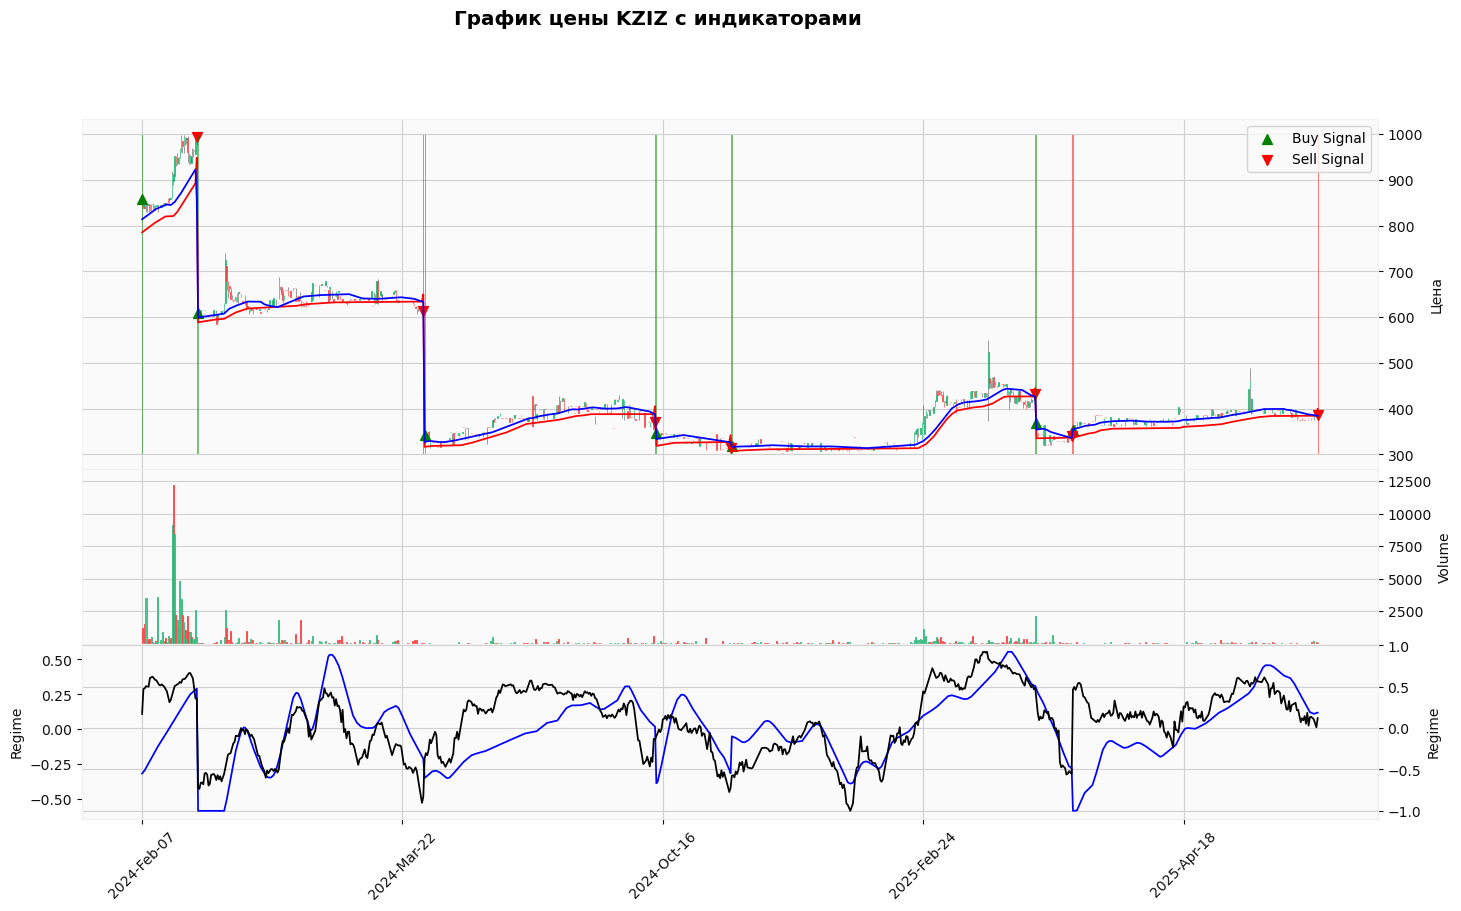

In [15]:
plot_price_with_indicators_mplfinance(df_phase.loc[gh[gh['batch'].isin(test_batches)].index], ticker, regime='P')

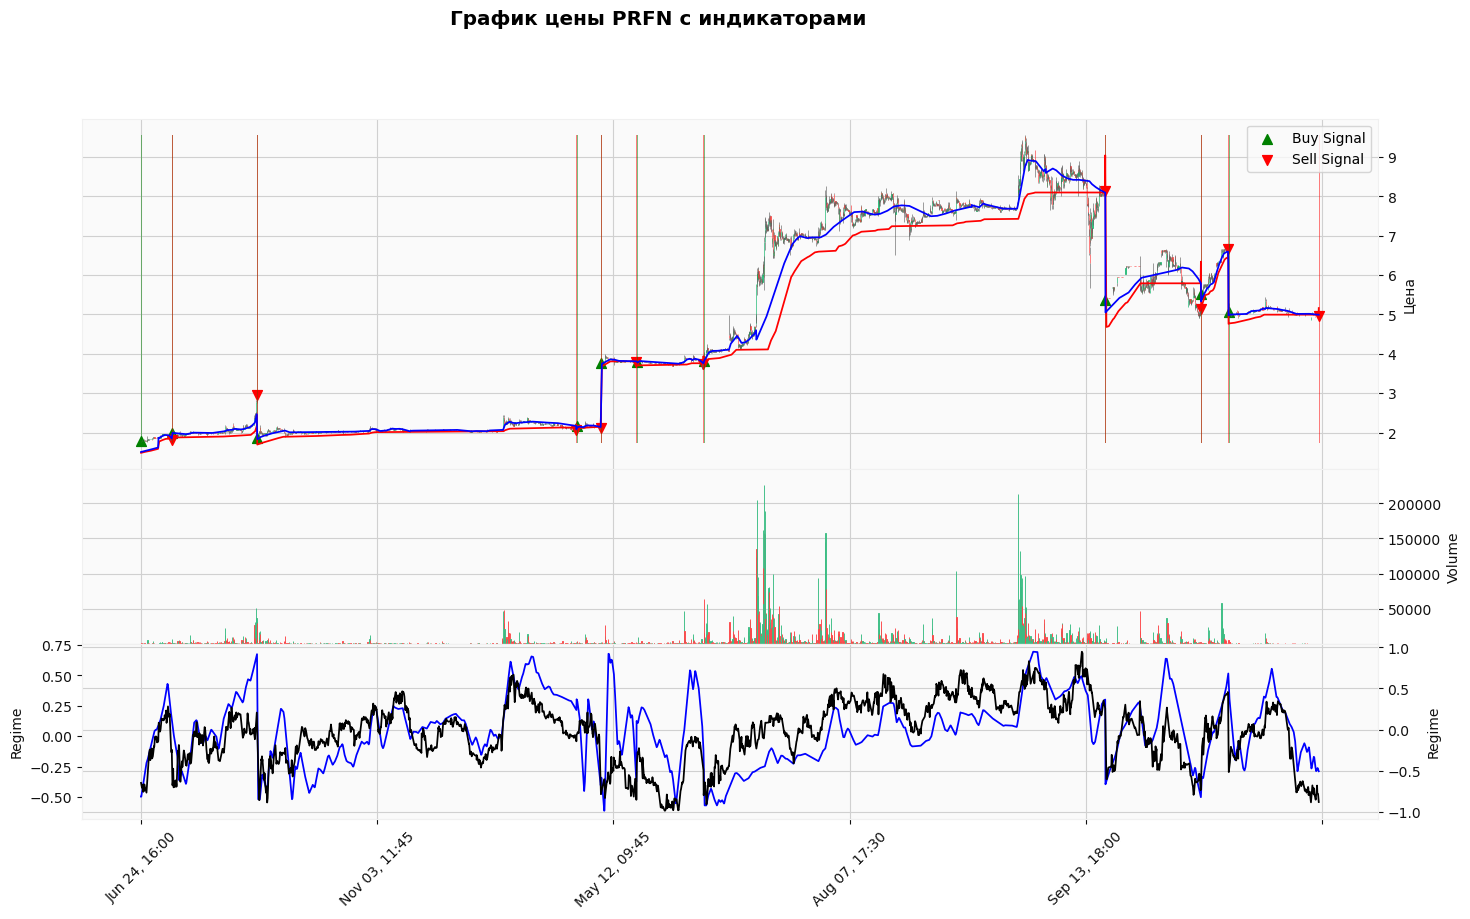

In [14]:
plot_price_with_indicators_mplfinance(df_phase.loc[gh[gh['batch'].isin(test_batches)].index], ticker, regime='P')

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.sparse import issparse
import shap

def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    df.dropna(inplace=True)
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing

def to_dense(X):
    """Преобразует разреженную матрицу в плотную."""
    if issparse(X):
        return X.toarray()
    return X

def normalize_importances(importances):
    """Нормализует массив важностей в диапазон [0, 1]."""
    if np.max(importances) == np.min(importances):
        return np.zeros_like(importances)
    return (importances - np.min(importances)) / (np.max(importances) - np.min(importances))

def calculate_feature_importance_report_for_regression(df, target_col='target', batch_col='batch'):
    """
    Генерация отчета о важности фичей для регрессионных моделей с учетом кросс-валидации по batch.
    """
    # Удаление коррелированных фич
    X_raw = df.drop(columns=[target_col, batch_col, 'ticker'], errors='ignore')
    corr_matrix = X_raw.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
    X_raw = X_raw.drop(columns=high_corr_features)

    cols_for_train = X_raw.columns.to_list() + [target_col]

    #print(f"Removed highly correlated features: {high_corr_features}")

    # Инициализация моделей
    models = [
        ('XGB', XGBRegressor(random_state=42, n_estimators=50, max_depth=3)),
        ('LGBM', LGBMRegressor(random_state=42, n_estimators=50, max_depth=3)),
        ('CatBoost', CatBoostRegressor(random_state=42, verbose=0, n_estimators=50, max_depth=3)),
        ('RF', RandomForestRegressor(random_state=42, n_estimators=50, max_depth=3)),
        ('LinearRegression', LinearRegression())
    ]

    # Словарь для хранения важностей
    report_data = {
        'Feature': [],  # Заполняем позже
        'XGB_Importance': [],
        'LGBM_Importance': [],
        'CatBoost_Importance': [],
        'RF_Importance': [],
        'LinearRegression_Importance': [],
        'SHAP_Importance': []
    }

    # Кросс-валидация
    unique_batches = df[batch_col].unique()
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(unique_batches):
        train_batches = unique_batches[train_idx]
        test_batches = unique_batches[test_idx]

        # Разделение данных по batch
        train_data = df[df[batch_col].isin(train_batches)][cols_for_train]
        test_data = df[df[batch_col].isin(test_batches)][cols_for_train]

        # Подготовка данных
        X_train_raw, y_train, preprocessing = prepare_data(train_data, target_col)
        X_test_raw, y_test, _ = prepare_data(test_data, target_col)

        preprocessing.fit(X_train_raw)
        X_train = preprocessing.transform(X_train_raw)
        X_test = preprocessing.transform(X_test_raw)

        # Получение признаков
        feature_names = preprocessing.get_feature_names_out()

        # Если список признаков пустой, заполняем его
        if not report_data['Feature']:
            report_data['Feature'] = list(feature_names)
            for key in report_data.keys():
                if key != 'Feature':
                    report_data[key] = np.zeros(len(feature_names))

        for model_name, model in models:
            # Обучение модели
            model.fit(X_train, y_train)

            # Получение важности признаков
            try:
                if model_name == 'LinearRegression':
                    importances = np.abs(model.coef_)
                else:
                    importances = model.feature_importances_
            except AttributeError:
                importances = np.zeros(len(feature_names))

            # Нормализация важностей
            normalized_importances = normalize_importances(importances)

            # Обновляем важности
            report_data[f'{model_name}_Importance'] += normalized_importances

            # SHAP-анализ
            if model_name == 'LinearRegression':
                explainer = shap.LinearExplainer(model, X_train)
            else:
                explainer = shap.TreeExplainer(model)

            shap_values = explainer(X_test[:100])  # SHAP только на подвыборке
            shap_importance = np.abs(shap_values.values).mean(axis=0)

            # Нормализация SHAP-значений
            normalized_shap_importance = normalize_importances(shap_importance)
            report_data['SHAP_Importance'] += normalized_shap_importance

    # Усреднение важностей
    for key in report_data:
        if key != 'Feature':
            report_data[key] /= kf.n_splits

    # Создание DataFrame
    df_report = pd.DataFrame(report_data)

    # Расчет Composite Score
    df_report['Composite_Score'] = df_report.iloc[:, 1:].mean(axis=1)

    # Определение степени влияния фичей
    df_report['Impact_Type'] = np.where(
        df_report['Composite_Score'] > df_report['Composite_Score'].quantile(0.75),
        'Highly Positive',
        np.where(df_report['Composite_Score'] < df_report['Composite_Score'].quantile(0.25),
                 'Negative', 'Neutral')
    )

    return df_report

In [23]:
report = calculate_feature_importance_report_for_regression(gh, target_col='normalized_target', batch_col='batch')

ValueError: operands could not be broadcast together with shapes (371,) (372,) (371,) 

In [9]:
from __future__ import annotations
import os, gc, warnings, typing as tp
import numpy as np, pandas as pd
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
import shap, joblib
from joblib import Parallel, delayed
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import issparse

class ToDenseTransformer(BaseEstimator, TransformerMixin):
    """Преобразует разреженную матрицу в плотную numpy-массив."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if issparse(X):
            return X.toarray()
        return X
    def get_feature_names_out(self, input_features: tp.Sequence[str] | None = None):
        return np.asarray(input_features) if input_features is not None else np.array([])

def to_dense(X):
    """Преобразует разреженную матрицу в плотную."""
    if issparse(X):
        return X.toarray()
    return X

RANDOM_STATE = 42
N_JOBS       = max(os.cpu_count()-1, 1)
warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────
# 1.  RareCategoryGrouper – вместо FunctionTransformer("rare")
# ──────────────────────────────────────────────────────────────
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    Объединяет редкие категории (freq < threshold) в '__RARE__'.
    Приводит все категории к str, чтобы не было смешения типов.
    """
    def __init__(self, threshold: float = .01):
        self.threshold = threshold
        self._levels_: list[pd.Index] = []

    def fit(self, X: pd.DataFrame, y=None):
        # Обязательно приводим к строкам
        X_str = X.astype(str)
        self._levels_ = [
            X_str[col].value_counts(normalize=True)[lambda s: s >= self.threshold].index
            for col in X_str.columns
        ]
        return self

    def transform(self, X: pd.DataFrame):
        X_new = X.astype(str).copy()          # ← всё превращаем в str
        for col, keep in zip(X_new.columns, self._levels_):
            X_new[col] = np.where(
                X_new[col].isin(keep), X_new[col], "__RARE__"
            )
        return X_new

    def get_feature_names_out(self, input_features=None):
        return np.asarray(input_features) if input_features is not None else np.array([])

# ──────────────────────────────────────────────────────────────
# 2.  FrequencyEncoder с методом get_feature_names_out
# ──────────────────────────────────────────────────────────────
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """Кодирует каждое категориальное значение его относительной частотой."""
    def fit(self, X: pd.DataFrame, y: tp.Any = None):
        self.freq_maps_ = [X[c].value_counts(normalize=True).to_dict() for c in X.columns]
        self.feature_names_in_ = list(X.columns)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        cols = []
        for col, fmap in zip(X.columns, self.freq_maps_):
            cols.append(X[col].map(fmap).fillna(0.).to_numpy(dtype=float))
        return np.vstack(cols).T            # shape (n_rows, n_cols)

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_)

# ──────────────────────────────────────────────────────────────
# 3.  Конструктор препроцессора
# ──────────────────────────────────────────────────────────────

def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    df = df.copy()
    df.dropna(inplace=True)
    X = df.drop([target_col, 'batch'], axis=1)
    y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing

to_dense_tr = FunctionTransformer(to_dense, feature_names_out="one-to-one")

# -------------------------------------------------------------
def build_preprocessor(
    X: pd.DataFrame,
    rare_thr: float = .01,
    high_card_thr: int = 20
) -> ColumnTransformer:

    num_cols = [c for c in make_column_selector(dtype_include=np.number)(X) if c != "batch"]
    cat_cols = [c for c in make_column_selector(dtype_include=object)(X)  if c != "batch"]

    low_card, high_card = [], []
    for c in cat_cols:
        (high_card if X[c].nunique() >= high_card_thr else low_card).append(c)

    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler())
    ])

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

    low_cat_pipe = Pipeline([
        ("to_str", FunctionTransformer(lambda df: df.astype(str), feature_names_out="one-to-one")),
        ("rare",  RareCategoryGrouper(threshold=rare_thr)),
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("ohe",   ohe)
    ])

    high_cat_pipe = Pipeline([
        ("to_str", FunctionTransformer(lambda df: df.astype(str), feature_names_out="one-to-one")),
        ("rare",  RareCategoryGrouper(threshold=rare_thr)),
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("freq",  FrequencyEncoder())          # → dense вектор размера 1
    ])

    return ColumnTransformer(
        [("num",   num_pipe,     num_cols),
         ("lowc",  low_cat_pipe, low_card),
         ("highc", high_cat_pipe, high_card)],
        remainder="drop",
        n_jobs=N_JOBS,
        verbose_feature_names_out=False,
    )

# ──────────────────────────────────────────────────────────────
# 4.  Вспомогательные функции (без изменений)
# ──────────────────────────────────────────────────────────────
def fold_importances(model, X_tr, y_tr, X_val, y_val, feat_names):
    model.fit(X_tr, y_tr)
    r2 = r2_score(y_val, model.predict(X_val))

    perm = permutation_importance(
        model, X_val, y_val,
        n_repeats=5,            # ← вместо 10
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    ).importances_mean

    shap_imp = fast_shap(model, X_tr, X_val, feat_names)

    return {"r2": r2, "perm": perm, "shap": shap_imp}
    
def _one_model(model, X_tr, y_tr, X_val, y_val, feat_names):
    res = fold_importances(model, X_tr, y_tr, X_val, y_val, feat_names)
    return res["perm"], res["shap"], max(res["r2"], 0.0)
    
def single_model_fold(model, X_tr, y_tr, X_val, y_val, feat_names):
    res = fold_importances(model, X_tr, y_tr, X_val, y_val, feat_names)
    return res["perm"], res["shap"], max(res["r2"], 0.0)
    
def fast_shap(model, X_bg, X_val, feat_names, shap_size=500):
    bg = shap.sample(X_bg, 100, random_state=RANDOM_STATE)
    bg = to_dense(bg)
    X_val_sub = shap.sample(X_val, min(shap_size, X_val.shape[0]), random_state=RANDOM_STATE)
    X_val_sub = to_dense(X_val_sub)

    # Определяем explainer в зависимости от типа модели
    if isinstance(model, (LGBMRegressor, XGBRegressor, CatBoostRegressor, RandomForestRegressor)):
        explainer = shap.TreeExplainer(model, bg, feature_names=feat_names)
        sv = explainer(X_val_sub, check_additivity=False)
    elif isinstance(model, Ridge):
        explainer = shap.LinearExplainer(model, bg, feature_names=feat_names)
        sv = explainer(X_val_sub)  # Параметр check_additivity не поддерживается
    else:
        explainer = shap.Explainer(model, bg, feature_names=feat_names)
        sv = explainer(X_val_sub)

    return np.abs(sv.values).mean(axis=0)


def feature_ranking(
    df: pd.DataFrame,
    target_col: str = "target",
    group_col:  str = "batch",
    top_k:      int = 50,
    cv_limit:   float = 0.50
) -> pd.DataFrame:
    """
    Для каждого fold в GroupKFold считает perm- и shap-важности
    для набора моделей, взвешенных по R2, усредняет их,
    оценивает стабильность (CV) и отдает таблицу ранжирования.
    """
    df = df.copy()
    y  = df[target_col]
    X  = df.drop(columns=[target_col])

    # Сохраняем колонку batch для групповой кросс-валидации
    batch_values = df[group_col].values if group_col in df.columns else None

    # предпроцессинг (ColumnTransformer и пр.)
    pre = build_preprocessor(X)
    X_t = pre.fit_transform(X, y)
    feat_names = pre.get_feature_names_out()

    MODELS = {
        "LGBM":  LGBMRegressor(n_estimators=400,
                             learning_rate=.05,
                             random_state=RANDOM_STATE,
                             n_jobs=N_JOBS),
        "XGB":   XGBRegressor(n_estimators=400,
                            learning_rate=.05,
                            random_state=RANDOM_STATE,
                            n_jobs=N_JOBS),
        "Cat":   CatBoostRegressor(iterations=400,
                                 learning_rate=.05,
                                 depth=6,
                                 random_seed=RANDOM_STATE,
                                 verbose=False),
        "RF":    RandomForestRegressor(n_estimators=500,
                                     random_state=RANDOM_STATE,
                                     n_jobs=N_JOBS),
        "Ridge": Ridge(alpha=1.0)
    }

    perm_all, shap_all, weight_all = [], [], []

    gkf = GroupKFold(n_splits=3)
    for tr_idx, val_idx in gkf.split(X_t, y, groups=batch_values):
        X_tr, X_val = X_t[tr_idx], X_t[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    
        out = Parallel(n_jobs=min(len(MODELS), N_JOBS))(
            delayed(_one_model)(mdl, X_tr, y_tr, X_val, y_val, feat_names)
            for mdl in MODELS.values()
        )
        fold_perm, fold_shap, fold_w = map(np.array, zip(*out))
        perm_all.append(fold_perm); shap_all.append(fold_shap); weight_all.append(fold_w)

        gc.collect()

    # Остальной код остается без изменений
    perm_all   = np.array(perm_all)   # shape = (n_folds, n_models, n_features)
    shap_all   = np.array(shap_all)
    weights    = np.array(weight_all)[..., None]  # (n_folds, n_models, 1)

    # взвешенное среднее по фолдам и моделям
    w_sum = weights.sum(axis=(0,1))      # скаляр
    perm_mean = np.nan_to_num((perm_all * weights).sum((0,1)) / w_sum)
    shap_mean = np.nan_to_num((shap_all * weights).sum((0,1)) / w_sum)

    # стабильность (coef of variation) по fold-средним
    perm_cv = stats.variation(perm_all.mean(axis=1), axis=0)
    shap_cv = stats.variation(shap_all.mean(axis=1), axis=0)

    # собираем финальный DataFrame
    df_rank = pd.DataFrame({
        "feature":          feat_names,
        "perm_importance":  perm_mean,
        "shap_importance":  shap_mean,
        "perm_cv":          np.nan_to_num(perm_cv, nan=1.0),
        "shap_cv":          np.nan_to_num(shap_cv, nan=1.0),
    })

    # composite = суммарный z-скор двух метрик
    df_rank["composite"] = (
        stats.zscore(df_rank["perm_importance"]) +
        stats.zscore(df_rank["shap_importance"])
    )

    df_rank = df_rank.sort_values("composite", ascending=False).reset_index(drop=True)

    # пометка стабильности и отбор топ-k
    df_rank["stable"]     = (
        (df_rank["perm_cv"] < cv_limit) &
        (df_rank["shap_cv"] < cv_limit)
    )
    df_rank["final_keep"] = False
    df_rank.loc[:top_k-1, "final_keep"]  = True
    df_rank.loc[~df_rank["stable"], "final_keep"] = False

    return df_rank

In [35]:
gh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3659 entries, 226 to 9958
Columns: 745 entries, regime to hp_trend_logsf_logsf
dtypes: float32(740), int32(4), object(1)
memory usage: 10.6+ MB


In [36]:
report = feature_ranking(gh, target_col="normalized_target", group_col="batch")

In [344]:
cols_for_search = report[(report['final_keep']==True)|((report['composite']>=4))].feature.values

In [347]:
cols_for_search

array(['trade_bars_counter', 'WILLR_skew', 'Price_MADist%_logsf_mean',
       'ma_norm_mean', 'ago_5_MACD', 'Price_MADist%_quantile50',
       'pmax_norm_quantile50'], dtype=object)

In [268]:
report[report['feature'].isin([i for i in report.feature.values if 'regime' in i])]

,feature,perm_importance,shap_importance,perm_cv,shap_cv,composite,stable,final_keep
629,regime_1,9.146176e-07,4.942285e-06,-2.080418,0.945074,-0.426253,False,False
646,regime_3,0.000000e+00,8.824978e-08,1.000000,0.751217,-0.428124,False,False
682,regime_0,-1.210541e-05,1.232317e-05,-1.483146,0.917369,-0.428562,False,False
683,regime_2,-2.399951e-06,1.367145e-06,-0.772253,0.737560,-0.428575,False,False


In [265]:
cols_for_search

['MEDPRICE_max',
 'trade_bars_counter',
 'slope_trend_min',
 'trade_bars_counter_logsf',
 'Price_MADist%_logsf_mean',
 'ago_25_trade_bars_counter',
 'ma_pmax_norm_rage_pct_quantile50',
 'ma_pmax_norm_rage_pct_mean',
 'ago_10_trade_bars_counter',
 'Price_MADist%_logsf_quantile50',
 'ago_50_trade_bars_counter',
 'slope_trend_logsf_max',
 'ago5_Mean_Reversion_kurt',
 'batch',
 'normalized_target',
 'batch',
 'normalized_target']

In [374]:
cols_for_search

['trade_bars_counter',
 'WILLR_skew',
 'Price_MADist%_logsf_mean',
 'ma_norm_mean',
 'ago_5_MACD',
 'Price_MADist%_quantile50',
 'pmax_norm_quantile50',
 'batch',
 'normalized_target']

In [39]:
import optuna
import re
from collections import defaultdict
from typing import Iterable, Mapping, Any
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import seaborn as sns
import math
from tqdm.notebook import tqdm
import os
import numpy as np
import mplfinance as mpf
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from scipy.sparse import issparse
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
import shap
from typing import List, Tuple, Dict, Optional
import numpy as np
import optuna
from optuna.trial import FrozenTrial

import numpy as np, pandas as pd, joblib, warnings, json
from lightgbm                 import LGBMRegressor
from sklearn.compose          import ColumnTransformer
from sklearn.pipeline         import Pipeline
from sklearn.preprocessing    import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection  import KFold
from sklearn.metrics          import (mean_squared_error, r2_score,
                                      make_scorer, get_scorer)

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (18, 10)
#plt.rcParams['axes.facecolor'] = 'black'
sns.set_palette('Spectral')
optuna.logging.set_verbosity(optuna.logging.WARNING)

from typing import List, Tuple, Dict
from optuna.trial import FrozenTrial

from __future__ import annotations
import os, gc, warnings, typing as tp
import numpy as np, pandas as pd
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble           import HistGradientBoostingRegressor
import shap, joblib
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import math
import gc
from sklearn.compose import make_column_selector
import joblib
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import issparse
import shap

def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    if type(target_col) == str:
        df.dropna(inplace=True)
        X = df.drop([target_col, 'batch'], axis=1)
        y = df[target_col]
    elif type(target_col) == list:
        df.dropna(inplace=True)
        X = df.drop(target_col+['batch'], axis=1)
        y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', RobustScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing

def _slope(y):
        x = np.arange(len(y))
        # линейная регрессия «по формуле»
        xm, ym = x.mean(), y.mean()
        beta = ((x - xm) * (y - ym)).sum() / ((x - xm)**2).sum()
        return beta
   

# ------------------------------------------------------------------------------
class FeatureCalculatorForRegression:
    """
    df  -- исходный OHLCV-DataFrame.
    required_features -- список имён колонок, которые нужны модели.
    params -- { primitive_name: {... гиперпараметры ...}, 'stat_window': int }.
    """

    _PRIMITIVES = {
        "MEDPRICE":               "_feat_base",
        "MACD":                   "_feat_macd",
        "MACD_Hist":              "_feat_macd",
        "Overbought_Oversold":    "_feat_overbought",
        "Overbought_Oversold_Index_mean": "_feat_overbought",
        "Price_MADist%":          "_feat_madist",
        "Mean_Reversion":         "_feat_mean_reversion",
        "Fear_Greed":             "_feat_fear_greed",
        "perc_var_open_close":    "_feat_price_variation",
        "pmax_norm":              "_feat_pmax_ma",
        "ma_norm":                "_feat_pmax_ma",
        "ma_pmax_norm_rage":      "_feat_pmax_ma",
        "ma_pmax_norm_rage_pct":  "_feat_pmax_ma",
        "slope_trend":            "_feat_slope",
        "ema_trend":              "_feat_ema_trend",
        "hp_trend":               "_feat_hp_trend",
        "trade_bars_counter":     "_feat_trade_duration",
        "ROC":                    "_feat_roc",
        "ATR_norm":               "_feat_atr",
        "BB_Width":               "_feat_bb_width",
        "Asset_Growth":           "_feat_asset_growth",
        "ema_acceleration":       "_feat_ema_acceleration",
        "price_change":           "_feat_price_change",
        "Asset_To_Equity_Ratio":  "_feat_asset_to_equity_ratio",
        "volume_ratio":           "_feat_fear_greed_index",
        "WILLR":                  "_feat_willr",
        "kf_trend":               "_feat_kf_trend",
        "Fractal_Dim":            "_feat_fractal_dim",
        "Peak_Exhaustion_Score":  "_feat_peak_exhaustion",
        "%B_BB":                  "_feat_bb_percent",
        "Kurtosis_roll":          "_feat_kurtosis_roll",
        "OBV_div":                "_feat_obv_div",
        "RSI_slope":              "_feat_rsi_slope",
        "Vol_Decay":              "_feat_vol_decay",
        "Accel_Decay":            "_feat_accel_decay",
        "Entropy_roll":           "_feat_entropy_roll",
        "Wavelet_Var_Ratio":      "_feat_wavelet_var",
        "Autocorr_Lag1":          "_feat_autocorr",
        "Beta_Market":            "_feat_beta",
        "PSC":                    "_feat_peak_squeeze_curvature"
    }

    # СТАРАЯ: r"^ago_(\d+)_"
    # НОВАЯ: умеет и "ago50_", и "ago_50_"
    _LAG_RE  = re.compile(r"^ago_?(\d+)_")
    _STAT_RE = re.compile(r"_(mean|min|max|std|skew|kurt|quantile(\d{2}))$")
    _LOGSF   = "_logsf"

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        f64 = self.df.select_dtypes("float64").columns
        self.df[f64] = self.df[f64].astype(np.float32)
        if "time" in self.df:
            ts = pd.to_datetime(self.df["time"], utc=True, errors="coerce")
            self.df["hour"]        = ts.dt.hour.astype("int8")
            self.df["day_of_week"] = ts.dt.day_of_week.astype("int8")

    def calculate_features(
        self,
        required_features: Iterable[str],
        params: Mapping[str, Mapping[str, Any]] | None = None
    ) -> pd.DataFrame:
        saved_cols = ['regime', 'normalized_target', 'batch', 'time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 
                      'sell_signal', 'event_sell_time', 'event_sell_price', 'event_time', 'event_price', 'event_sell_time', 
                      'event_sell_price', 'target', 'pnl', 'ma', 'pmax']
        self._params      = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)
        for col in required_features:
            self._ensure_column(col)
        out = self.df[list(required_features)].copy()
        f64 = out.select_dtypes("float64").columns
        out[f64] = out[f64].astype(np.float32)

        for mandatory_col in saved_cols:
            if mandatory_col in self.df.columns:
                out[mandatory_col] = self.df[mandatory_col]
            
        return out

    def calculate_all_possible_features(self, params: Mapping[str, Mapping[str, Any]] | None = None) -> pd.DataFrame:
        """
        Вычисляет все возможные фичи, исключая lag-версии для указанных колонок.
        Все бесконечные значения (np.inf/-np.inf) заменяются на 0.
        Порядок вычислений:
        1. Все базовые примитивы
        2. Lag-версии фич (кроме исключенных)
        3. Статистики для всех фич
        """
        # Инициализация параметров
        if not hasattr(self, '_params'):
            self._params = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)
        
        # Колонки, для которых не нужно создавать lag-версии
        EXCLUDE_FROM_LAGS = {
            'time', 'open', 'close', 'high', 'low', 'volume', 
            'ma', 'pmax', 'buy_signal', 'sell_signal', 'regime',
            'event_time', 'event_price', 'event_sell_time', 
            'event_sell_price', 'pnl', 'target', 'normalized_target',
            'batch', 'hour', 'day_of_week', 'trade_bars_counter'
        }
        
        # 1. Вычисляем все базовые примитивы
        all_primitives = list(self._PRIMITIVES.keys())
        for primitive in all_primitives:
            method_name = self._PRIMITIVES[primitive]
            primitive_params = self._params.get(primitive, {})
            try:
                getattr(self, method_name)(**primitive_params)
            except Exception as e:
                print(f"Ошибка при вычислении примитива {primitive}: {str(e)}")
    
        # 2. Добавляем lag-версии только для разрешенных фич
        numeric_cols = [
            col for col in self.df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
            if col not in EXCLUDE_FROM_LAGS and  # Исключаем указанные колонки
            not self._LAG_RE.match(col) and      # Исключаем уже lag-фичи
            not col.endswith(self._LOGSF) and    # Исключаем logsf-фичи
            not self._STAT_RE.search(col)        # Исключаем статистики
        ]
        
        lag_periods = [1, 2, 3, 5, 10, 20, 50]  # Стандартные лаги
        
        for col in numeric_cols:
            for lag in lag_periods:
                lag_col = f"ago_{lag}_{col}"
                if lag_col not in self.df.columns:
                    self.df[lag_col] = self.df[col].shift(lag)
        
        # 3. Добавляем статистики для всех фич (кроме исключенных)
        all_cols_for_stats = [
            col for col in self.df.columns 
            if col not in EXCLUDE_FROM_LAGS and
            not col.endswith(self._LOGSF) and
            not self._STAT_RE.search(col)
        ]
        
        stats = ['mean', 'std', 'min', 'max', 'skew', 'kurt']
        
        for col in all_cols_for_stats:
            for stat in stats:
                stat_col = f"{col}_{stat}"
                if stat_col not in self.df.columns:
                    try:
                        self._add_stat(col, stat)
                    except Exception as e:
                        print(f"Ошибка при вычислении статистики {stat} для {col}: {str(e)}")
        
        # 4. Добавляем logsf-версии только для разрешенных фич
        main_cols_for_logsf = [
            col for col in numeric_cols 
            if not col.startswith('ago_') and
            not col.endswith(self._LOGSF) and
            col not in EXCLUDE_FROM_LAGS
        ]
        
        for col in main_cols_for_logsf:
            logsf_col = f"{col}{self._LOGSF}"
            if logsf_col not in self.df.columns:
                try:
                    self.df[logsf_col] = norm.logsf(self.df[col])
                except Exception as e:
                    print(f"Ошибка при вычислении logsf для {col}: {str(e)}")
    
        # 5. Заменяем бесконечные значения на 0
        numeric_cols_all = self.df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
        self.df[numeric_cols_all] = self.df[numeric_cols_all].replace([np.inf, -np.inf], 0)
        
        # Сохраняем все оригинальные колонки
        for col in EXCLUDE_FROM_LAGS:
            if col in self.df.columns and col not in self.df:
                self.df[col] = self.df[col]
        
        return self.df.copy()

    def _ensure_column(self, name: str):
        if name in self.df:
            return

        # 1) lag-префикс "ago50_" или "ago_50_"
        m = self._LAG_RE.match(name)
        if m:
            lag  = int(m.group(1))
            base = name[m.end():]
            self._ensure_column(base)
            self.df[name] = self.df[base].shift(lag)
            return

        # 2) _logsf
        if name.endswith(self._LOGSF):
            base = name[:-len(self._LOGSF)]
            self._ensure_column(base)
            self.df[name] = norm.logsf(self.df[base])
            return

        # 3) статистический суффикс
        m = self._STAT_RE.search(name)
        if m:
            stat = m.group(1)
            base = name[:m.start()]
            self._ensure_column(base)
            self._add_stat(base, stat)
            return

        # 4) примитив
        prim = name
        if prim.startswith("Overbought_Oversold"):
            prim = "Overbought_Oversold"
        if prim.startswith("Fear_Greed"):
            prim = "Fear_Greed"
        if prim not in self._PRIMITIVES:
            raise KeyError(f"Не знаю, как получить примитив «{prim}» для «{name}»")
        getattr(self, self._PRIMITIVES[prim])(**self._params.get(prim, {}))
        if name not in self.df:
            raise RuntimeError(f"После _feat_{prim}() нет колонки «{name}»")

    def _add_stat(self, base: str, stat: str):
        col = f"{base}_{stat}"
        if col in self.df:
            return
        s = self.df[base]; w = self._stat_window
        if stat == "mean":
            self.df[col] = s.rolling(w).mean()
        elif stat == "std":
            self.df[col] = s.rolling(w).std()
        elif stat == "min":
            self.df[col] = s.rolling(w).min()
        elif stat == "max":
            self.df[col] = s.rolling(w).max()
        elif stat == "skew":
            self.df[col] = s.rolling(w).skew()
        elif stat == "kurt":
            self.df[col] = s.rolling(w).kurt()
        elif stat.startswith("quantile"):
            q = int(stat[-2:]) / 100
            self.df[col] = s.rolling(w).quantile(q)
        else:
            raise ValueError(f"Неизвестная stat «{stat}»")

    # ---------------------- ПРИМИТИВЫ ----------------------

    def _feat_base(self, medprice: int = 50):
        if "MEDPRICE" in self.df:
            return
        self.df["MEDPRICE"]      = (self.df["high"] + self.df["low"]) / 2
        self.df["MEDPRICE_std"] = self.df["MEDPRICE"].rolling(medprice).std()

    def _feat_macd(self, fast: int = 12, slow: int = 26, signal: int = 9):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        if {"MACD","MACD_Hist"}.issubset(self.df.columns):
            return
            
        close = self.df['close']
        # Создаем множества для уникальных периодов
        ema_cache_fp = close.ewm(span=fast, adjust=False).mean()
        
        ema_cache_sp = close.ewm(span=slow, adjust=False).mean()
        rolling_cache = close.rolling(window=slow).mean()
        
        # Основной цикл вычислений
        ema_fast = ema_cache_fp
        ema_slow = ema_cache_sp
        rolling_mean = rolling_cache
        macd = ema_fast - ema_slow
        macd_norm = macd / rolling_mean
        self.df[f'MACD'] = macd_norm
        signal = macd.ewm(span=signal, adjust=False).mean()
        signal_norm = signal / rolling_mean
    
        # Сохраняем результаты
        self.df[f'MACD_Hist'] = macd_norm - signal_norm

    '''def _feat_macd(self, fast: int = 12, slow: int = 26, signal: int = 9):
        if {"MACD","MACD_Hist"}.issubset(self.df.columns):
            return
        c  = self.df["close"]
        ef = c.ewm(span=fast, adjust=False).mean()
        es = c.ewm(span=slow, adjust=False).mean()
        macd = (ef - es) / (c.rolling(slow).mean().add(1e-10))
        sig  = macd.ewm(span=signal, adjust=False).mean()
        self.df["MACD"]      = macd
        self.df["MACD_Hist"] = macd - sig'''

    def _feat_overbought(self, rsi_p: int = 14, stoch_p: int = 14):
        name = "Overbought_Oversold_Index"
        if name in self.df:
            return
        c   = self.df["close"]; d = c.diff()
        g   = d.clip(lower=0); l = (-d).clip(lower=0)
        rs  = g.rolling(rsi_p).mean() / (l.rolling(rsi_p).mean().add(1e-10))
        rsi = 100 - (100 / (1 + rs))
        lo  = self.df["low"].rolling(stoch_p).min()
        hi  = self.df["high"].rolling(stoch_p).max()
        st  = 100*(c - lo)/(hi - lo + 1e-10)
        self.df[name] = (rsi + st)/2

    def _feat_madist(self, span_lenght: int = 200):
        name = "Price_MADist%"
        if name in self.df:
            return
        ema = self.df["close"].ewm(span=span_lenght, adjust=False).mean()
        self.df[name] = (self.df["close"]/ema - 1)*100

    def _feat_mean_reversion(self, window: int = 20):
        name = "Mean_Reversion"
        if name in self.df:
            return
        ma = self.df["close"].rolling(window).mean()
        self.df[name] = self.df["close"] - ma

    def _feat_fear_greed(self, window: int = 14):
        name = "Fear_Greed_Index"
        if name in self.df:
            return
        v  = self.df["close"].pct_change().rolling(window).std()
        vc = self.df["volume"].pct_change().rolling(window).mean()
        tr = self.df["close"]/self.df["close"].rolling(window).mean()
        self.df[name] = (v + vc + tr)/3*100

    def _feat_price_variation(self):
        name = "perc_var_open_close"
        if name in self.df:
            return
        eps = 1e-10
        self.df[name] = (self.df["close"]-self.df["open"])/(self.df["open"]+eps)*100

    def _feat_pmax_ma(self,
        pmax_ma_length: int = 10,
        pmax_ma_length_roll: int = 50,
        pct_window: int = 5
    ):
        need = {
            "pmax_norm", "ma_norm",
            "ma_pmax_norm_rage", "ma_pmax_norm_rage_pct"
        }
        if need.issubset(self.df.columns):
            return
        if {"pmax","ma"}.difference(self.df.columns):
            raise ValueError("Нужны 'pmax' и 'ma'")
        c = self.df["close"]
        self.df["pmax_norm"]             = (c-self.df["pmax"])/self.df["pmax"]
        self.df["ma_norm"]               = (c-self.df["ma"])/self.df["ma"]
        self.df["ma_pmax_norm_rage"]     = self.df["ma_norm"] - self.df["pmax_norm"]
        # новый примитив — pct-динамика
        self.df["ma_pmax_norm_rage_pct"] = \
          self.df["ma_pmax_norm_rage"].pct_change(pct_window).fillna(0)

    def _feat_slope(self, slope_lag: int = 300, pct_window: int = 6):
        name = "slope_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        self.df[name] = r.rolling(slope_lag, min_periods=slope_lag)\
                         .apply(_slope, raw=True)

    def _feat_ema_trend(self, span: int = 300, pct_window: int = 6):
        name = "ema_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=span, adjust=False).mean()
        self.df[name] = e.diff().fillna(0)

    def _feat_asset_to_equity_ratio(self):
        """
        Вычисление коэффициента соотношения активов и собственного капитала.
        """
        name = "Asset_To_Equity_Ratio"
        asset = self.df['close']
        equity = self.df['low']
        # Добавляем в DataFrame
        self.df[name] = asset / (equity + 1e-10)

    def _feat_hp_trend(self, lamb: float = 1600):
        name = "hp_trend"
        if name in self.df:
            return
        y    = np.log(self.df["close"]).fillna(method="ffill")
        coef = lamb/(1+lamb)
        tr   = np.empty(len(y), dtype=float)
        tr[0] = y.iloc[0]
        for i in range(1, len(y)):
            tr[i] = coef*y.iloc[i] + (1-coef)*tr[i-1]
        self.df[name] = np.append([0], np.diff(tr))

    def _feat_kf_trend(self,
        pct_window: int = 6,
        obs_var: float = 1e-4, # σ² ε_t (шум наблюдения)
        level_var: float = 1e-5 # σ² η_t (шум уровня)
        ) -> pd.DataFrame:
        """
        Добавляет к DataFrame колонки:
        kf_trend — one-sided Калман-оценка тренда доходностей
        kf_trend_logsf — лог-survival-function (z-score) тренда
        Полностью каузально, обновляется тик-за-тиком.
        """

        name = 'kf_trend'
        # 1. Доходности
        r = self.df['close'].pct_change(pct_window).fillna(0)
        # 2. Local-level модель: y_t = μ_t + ε_t ;  μ_t = μ_{t-1} + η_t
        mod = sm.tsa.UnobservedComponents(r, level='llevel')
        
        # 3. Параметры модели в log-шкале (требование statsmodels)
        params = np.log([obs_var, level_var])
        
        # 4. Только forward-filter → нет look-ahead bias
        res = mod.filter(params)                       # <— односторонний Калман
        trend = pd.Series(res.filtered_state[0], index=self.df.index)
        
        # 5. Запись результата
        self.df['kf_trend'] = trend

    def _feat_willr(self, window=14):
        """
        Вычисление %R по методу Уильямса (WILLR).
        """
        name = 'WILLR'
        high = self.df['high']
        low = self.df['low']
        close = self.df['close']

        highest_high = high.rolling(window).max()
        lowest_low = low.rolling(window).min()
        
        willr = ((highest_high - close) / (highest_high - lowest_low)) * -100
        
        # Добавляем в DataFrame
        self.df[name] = willr

    def _feat_fear_greed_index(self, window: int = 14):
        """
        Расчет объема как отношение последнего объема к скользящему среднему.
        """
        name = "volume_ratio"
        if name in self.df:
            return
        s = self.df["volume"]
        self.df[name] = s / s.rolling(window).mean()

    def _feat_trade_duration(self):
        name = "trade_bars_counter"
        if name in self.df:
            return
        self.df[name] = np.nan
        entries = self.df.index[self.df["event_time"].notna()]
        last    = self.df.index[-1]
        for st in entries:
            sell = self.df.at[st, "event_sell_time"]
            ends = self.df.index[self.df["time"] == sell]
            end  = ends[0] if len(ends) else last
            s,e  = self.df.index.get_loc(st), self.df.index.get_loc(end)
            self.df.loc[self.df.index[s:e+1], name] = np.arange(e-s+1, dtype=np.float32)

    def _feat_roc(self, window: int = 5):
        name = "ROC"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window)

    def _feat_atr(self, atr_window: int = 14):
        name = "ATR_norm"
        if name in self.df:
            return
        h,l,c = self.df["high"], self.df["low"], self.df["close"]
        tr1 = h-l
        tr2 = (h-c.shift()).abs()
        tr3 = (l-c.shift()).abs()
        tr  = pd.concat([tr1,tr2,tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
        self.df[name] = atr/c

    def _feat_bb_width(self, bb_window: int = 20):
        name = "BB_Width"
        if name in self.df:
            return
        c   = self.df["close"]
        ma  = c.rolling(bb_window).mean()
        std = c.rolling(bb_window).std()
        self.df[name] = 2*std/ma

    def _feat_asset_growth(self, window: int = 3):
        name = "Asset_Growth"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)*100

    def _feat_ema_acceleration(self, pct_window: int = 3, ema_window: int = 300):
        name = "ema_acceleration"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=ema_window).mean()
        self.df[name] = e.diff(4)

    def _feat_price_change(self, window: int = 1):
        name = "price_change"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)
        
    def _feat_peak_exhaustion(
        self,
        price_win: int = 60,    # окно "локального максимума"
        mom_win:   int = 10,    # окно для momentum
        vol_win:   int = 20,
        atr_win:   int = 14,
        z_win:     int = 100    # z-score нормализация
    ):
        """
        Peak-Exhaustion Score  ~ 0…1
        1 → почти наверху, импульс затух, объём падает, ATR высок.
        """
        name = "Peak_Exhaustion_Score"
        c = self.df["close"]
    
        # 1) расстояние до локального max
        roll_max = c.rolling(price_win).max()
        dist_max = (roll_max - c) / roll_max          # 0 — на max, >0 — ниже
    
        # 2) ослабевающий импульс
        roc_now  = c.pct_change(mom_win)
        roc_hist = roc_now.rolling(price_win).max()   # max импульса в окне
        momentum_div = 1 - (roc_now / (roc_hist + 1e-12))   # 0 → свежий high
    
        # 3) сушащийся объём
        vol_ratio = self.df["volume"] / \
            self.df["volume"].rolling(vol_win).mean()
    
        # 4) расширенный спред (ATR/price)
        tr  = pd.concat([
                self.df["high"]  - self.df["low"],
                (self.df["high"] - c.shift()).abs(),
                (self.df["low"]  - c.shift()).abs()
            ], axis=1).max(axis=1)
        atr = tr.rolling(atr_win).mean()
        atr_norm = atr / c
    
        # 5) агрегируем, переводим в z-score, squash σ → 0…1
        raw = (dist_max + momentum_div + (1/vol_ratio) + atr_norm) / 4
        z   = (raw - raw.rolling(z_win).mean()) / (raw.rolling(z_win).std() + 1e-9)
        self.df[name] = 1 / (1 + np.exp(-z))   # σ(z)
        
    def _feat_fractal_dim(self, short_win=20, long_win=40):
        """Вычисляет фрактальную размерность на основе отношения ATR разных периодов"""
        name = "Fractal_Dim"
        if name in self.df:
            return
        
        # Вычисляем ATR для короткого периода
        h, l, c = self.df['high'], self.df['low'], self.df['close']
        tr1 = h - l
        tr2 = (h - c.shift()).abs()
        tr3 = (l - c.shift()).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr_short = tr.rolling(short_win).mean()
        
        # Вычисляем ATR для длинного периода
        atr_long = tr.rolling(long_win).mean()
        
        # Вычисляем фрактальную размерность
        ratio = atr_long / (atr_short + 1e-10)  # Добавляем небольшое значение для избежания деления на 0
        self.df[name] = np.log(ratio) / np.log(2)
        
    def _feat_bb_percent(self, window=20, std_mult=2):
        name = "%B_BB"
        if name in self.df: return
        ma = self.df["close"].rolling(window).mean()
        std = self.df["close"].rolling(window).std()
        self.df[name] = (self.df["close"] - (ma - std_mult * std)) / (4 * std)
        
    def _feat_kurtosis_roll(self, window=50):
        name = "Kurtosis_roll"
        if name in self.df: return
        ret = self.df["close"].pct_change().fillna(0)
        self.df[name] = ret.rolling(window).kurt()
        
    def _feat_obv_div(self, window=10):
        name = "OBV_div"
        if name in self.df: return
        sign = np.sign(self.df["close"].diff())
        obv = (sign * self.df["volume"]).cumsum()
        price_chg = self.df["close"].pct_change(window)
        obv_chg = obv.pct_change(window)
        self.df[name] = price_chg - obv_chg
        
    def _feat_rsi_slope(self, rsi_p=14, diff_win=5):
        name = "RSI_slope"
        if name in self.df: return
        delta = self.df["close"].diff()
        gain = delta.clip(lower=0).rolling(rsi_p).mean()
        loss = -delta.clip(lower=0).rolling(rsi_p).mean()
        rsi = 100 - 100 / (1 + gain / (loss + 1e-10))
        self.df[name] = rsi.diff(diff_win)
        
    def _feat_vol_decay(self, window=20):
        name = "Vol_Decay"
        if name in self.df: return
        vol_ema = self.df["volume"].ewm(span=window).mean()
        self.df[name] = self.df["volume"] / vol_ema - 1
        
    def _feat_accel_decay(self, window=10):
        name = "Accel_Decay"
        if name in self.df: return
        vel = self.df["close"].diff(window)
        accel = vel.diff(window)
        self.df[name] = accel / (vel.abs() + 1e-10)
        
    def _feat_entropy_roll(self, window=50):
        name = "Entropy_roll"
        if name in self.df: 
            return
            
        ret = self.df["close"].pct_change().fillna(0)
        
        def _entropy(x):
            if len(x) < 2:
                return 0
            hist = np.histogram(x, bins='auto')[0]
            hist = hist / hist.sum()  # Нормализуем
            return -np.sum(hist * np.log(hist + 1e-10))
        
        self.df[name] = ret.rolling(window).apply(_entropy, raw=True)
    def _feat_wavelet_var(self, short_win=10, long_win=50):
        name = "Wavelet_Var_Ratio"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0)
        var_short = ret.rolling(short_win).var()
        var_long = ret.rolling(long_win).var()
        self.df[name] = var_short / (var_long + 1e-10)
        
    def _feat_autocorr(self, window=50):
        name = "Autocorr_Lag1"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0)
        self.df[name] = ret.rolling(window).apply(lambda x: x.autocorr(lag=1) if len(x) > 1 else 0, raw=False)
        
    def _feat_beta(self, window=50):
        name = "Beta_Market"
        if name in self.df or "market_close" not in self.df:
            return
        ret_stock = self.df["close"].pct_change().fillna(0)
        ret_market = self.df["market_close"].pct_change().fillna(0)
        cov = ret_stock.rolling(window).cov(ret_market)
        var_market = ret_market.rolling(window).var()
        self.df[name] = cov / (var_market + 1e-10)
        
    def _feat_peak_squeeze_curvature(self,
                                vel_win: int = 5,
                                acc_win: int = 5,
                                vol_win: int = 20,
                                atr_win: int = 14,
                                z_win : int = 60):
        """
        Возвращает 3 колонки:
        PSC_raw, PSC_z, PSC_sigmoid ∈ [0,1]
        """
        name = "PSC"
        cols_need = {"PSC_raw","PSC_z","PSC_sigmoid"}
        if cols_need.issubset(self.df.columns): return
        c = self.df['close']
    
        # 1) speed & accel
        speed  = c.pct_change(vel_win).fillna(0)
        accel  = speed.diff(acc_win).fillna(0)
        curvature = accel / (speed.abs() + 1e-10)
    
        # 2) squeeze = ATR_norm ↘ & HV_norm ↘
        h,l = self.df['high'], self.df['low']
        tr = pd.concat([h-l, (h-c.shift()).abs(), (l-c.shift()).abs()], axis=1).max(axis=1)
        atr = tr.rolling(atr_win).mean()
        hv  = c.pct_change().rolling(vol_win).std()
        squeeze = - (atr / (c+1e-10)).diff().clip(upper=0)   # падение ATR
        squeeze += - hv.diff().clip(upper=0)                 # падение HV
        squeeze /= 2
    
        # 3) агрегируем
        raw = 0.6*curvature + 0.4*squeeze
    
        # 4) z-score + σ(z)
        mu  = raw.rolling(z_win).mean()
        std = raw.rolling(z_win).std()
        z = (raw - mu)/(std + 1e-9)
        sigm = 1/(1+np.exp(-z))
    
        self.df[f'{name}_raw']     = raw
        self.df[f'{name}_z']       = z.clip(-5, 5)
        self.df[f'{name}_sigmoid'] = sigm


def calculate_metrics(test_data, y_test, y_pred, target_column='normalized_target'):
    """
    Функция для расчета метрик по данным теста и предсказаниям модели.

    Параметры:
    - test_data: pd.DataFrame — тестовые данные с колонками batch, high, close и другими.
    - y_test: pd.Series или np.array — фактические значения целевой переменной.
    - y_pred: pd.Series или np.array — предсказанные моделью значения.
    - target_column: str — название колонки целевой переменной в test_data.

    Возвращает:
    - avg_mse: float — среднеквадратическая ошибка.
    - avg_r2: float — средняя R².
    - std_r2: float — стандартное отклонение R².
    - corr_mean: float — средняя корреляция.
    - corr_std: float — стандартное отклонение корреляции.
    - avg_missed: float — средний процент упущенной прибыли.
    """
    # Инициализация метрик
    mse_scores, r2_scores, corr_scores, missed_pnl = [], [], [], []

    # Расчет корреляции целевой переменной и предсказаний
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    corr_score = test_data[target_column].corr(y_pred_series)
    corr_scores.append(corr_score)

    # MSE и R2
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

    # Расчет missed_pnl для каждого batch
    """for batch in test_data['batch'].unique():
        mask = test_data['batch'] == batch
        max_high = test_data.loc[mask, 'high'].max()
        pred = y_pred[mask]  # предполагается, что y_pred соответствует normalized_target
        sell_idx = np.argmin(pred)  # продажа на минимальном предсказанном значении
        sell_price = test_data.loc[mask].iloc[sell_idx]['close']
        missed = (max_high - sell_price) / (max_high - test_data.loc[mask].iloc[0]['close'])  # % упущенной прибыли
        missed_pnl.append(missed)"""

    # Усреднение метрик
    avg_mse = float(np.mean(mse_scores))
    avg_r2 = float(np.mean(r2_scores))
    std_r2 = float(np.std(r2_scores))
    corr_mean = float(np.mean(corr_scores))
    corr_std = float(np.std(corr_scores))
    #avg_missed = float(np.mean(missed_pnl))

    # Проверка на корректность результатов
    if np.isfinite([avg_mse, avg_r2, std_r2, corr_mean, corr_std]).all(): #avg_missed
        return avg_mse, avg_r2, std_r2, corr_mean, corr_std, #avg_missed
    else:
        return float('inf'), float('inf'), float('inf'), float('inf'), float('inf'), float('inf')


def calculate_indicators(df, features, params=None, mode=None, multy=False):
    
    fc = FeatureCalculatorForRegression(df)
    if mode==None:
        df_features = fc.calculate_features(params=params, required_features=features)
    else:
        df_features = fc.calculate_all_possible_features()
    if multy == False:
        df1 = df_features[df_features['normalized_target'].notna()]
    else:
        df1 = df_features[df_features['multi_target_5'].notna()]
    features = ['time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 'sell_signal','event_sell_time','event_sell_price',
                'event_time','event_price','event_sell_time','event_sell_price','target', 'pnl', 'ma', 'pmax']
    df1['regime'] = df1['regime'].astype('object')
    df1[['batch','trade_bars_counter']] = df1[['batch', 'trade_bars_counter']].astype('int')
    df1 = df1.drop(features, axis=1)
    #df1 = df1.dropna()
    return df1

def to_dense(X):
    """Преобразует разреженную матрицу в плотную."""
    if issparse(X):
        return X.toarray()
    return X
    
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    """Преобразует разреженную матрицу в плотную numpy-массив."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if issparse(X):
            return X.toarray()
        return X
    def get_feature_names_out(self, input_features: tp.Sequence[str] | None = None):
        return np.asarray(input_features) if input_features is not None else np.array([])


PARALLEL_FILES = 1                         # ← меняйте при желании
N_JOBS  = max(os.cpu_count() // PARALLEL_FILES-1, 1)
warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────
# 1.  RareCategoryGrouper – вместо FunctionTransformer("rare")
# ──────────────────────────────────────────────────────────────
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    Объединяет редкие категории (freq < threshold) в '__RARE__'.
    Приводит все категории к str, чтобы не было смешения типов.
    """
    def __init__(self, threshold: float = .01):
        self.threshold = threshold
        self._levels_: list[pd.Index] = []

    def fit(self, X: pd.DataFrame, y=None):
        # Обязательно приводим к строкам
        X_str = X.astype(str)
        self._levels_ = [
            X_str[col].value_counts(normalize=True)[lambda s: s >= self.threshold].index
            for col in X_str.columns
        ]
        return self

    def transform(self, X: pd.DataFrame):
        X_new = X.astype(str).copy()          # ← всё превращаем в str
        for col, keep in zip(X_new.columns, self._levels_):
            X_new[col] = np.where(
                X_new[col].isin(keep), X_new[col], "__RARE__"
            )
        return X_new

    def get_feature_names_out(self, input_features=None):
        return np.asarray(input_features) if input_features is not None else np.array([])

# ──────────────────────────────────────────────────────────────
# 2.  FrequencyEncoder с методом get_feature_names_out
# ──────────────────────────────────────────────────────────────
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.maps_ = [X[c].value_counts(normalize=True).to_dict() for c in X.columns]
        self.feature_names_in_ = list(X.columns)
        return self
    def transform(self, X):
        cols = [X[c].map(m).fillna(0.).to_numpy(float) for c, m in zip(X.columns, self.maps_)]
        return np.vstack(cols).T
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_)

# ──────────────────────────────────────────────────────────────
# 3.  Конструктор препроцессора
# ──────────────────────────────────────────────────────────────

to_dense_tr = FunctionTransformer(to_dense, feature_names_out="one-to-one")

# -------------------------------------------------------------
def build_preprocessor(
    X: pd.DataFrame,
    rare_thr: float = .01,
    high_card_thr: int = 20
) -> ColumnTransformer:

    num_cols = [c for c in make_column_selector(dtype_include=np.number)(X) if c != "batch"]
    cat_cols = [c for c in make_column_selector(dtype_include=object)(X)  if c != "batch"]

    low_card, high_card = [], []
    for c in cat_cols:
        (high_card if X[c].nunique() >= high_card_thr else low_card).append(c)

    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler())
    ])

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

    low_cat_pipe = Pipeline([
        ("to_str", FunctionTransformer(lambda df: df.astype(str), feature_names_out="one-to-one")),
        #("rare",  RareCategoryGrouper(threshold=rare_thr)),
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("ohe",   ohe)
    ])

    high_cat_pipe = Pipeline([
        ("to_str", FunctionTransformer(lambda df: df.astype(str), feature_names_out="one-to-one")),
        #("rare",  RareCategoryGrouper(threshold=rare_thr)),
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("freq",  FrequencyEncoder())          # → dense вектор размера 1
    ])

    return ColumnTransformer(
        [("num",   num_pipe,     num_cols),
         ("lowc",  low_cat_pipe, low_card),
         ("highc", high_cat_pipe, high_card)],
        remainder="drop",
        n_jobs=1,
        verbose_feature_names_out=False,
    )

def _to_dense(x):
    if issparse(x):
        return x.toarray()
    return np.asarray(x)


def feature_ranking(
    df: pd.DataFrame,
    target_col : str = "target",
    group_col  : str = "batch",
    top_k      : int = 50,
    *,
    top_pi_feats : Optional[int] = 800,
    val_frac     : float = .30
) -> pd.DataFrame:
    """
    Важность = усреднение четырёх каналов:
        1. perm_mix  – средний ущерб трёх метрик (MSE, R², Corr)
        2. SHAP      – |SHAP|
        3. Ridge      |coef|
        4. (опционально) можно добавить любой другой канал
    Возвращает top_k фичей + подробные Δ-метрики.
    """
    df = df.copy().dropna(subset=[target_col])
    y  = df.pop(target_col).reset_index(drop=True)
    g  = df[group_col].reset_index(drop=True) if group_col in df.columns else None

    pre = build_preprocessor(df)
    Xt  = pre.fit_transform(df, y)
    f_names = pre.get_feature_names_out()

    MODELS: Dict[str, object] = {
        "LGBM": LGBMRegressor(
                    n_estimators=250, learning_rate=.05,
                    subsample=.8, colsample_bytree=.8,
                    random_state=RANDOM_STATE, n_jobs=1, verbosity=-1),
        "HGBR": HistGradientBoostingRegressor(
                    max_depth=None, learning_rate=.06, l2_regularization=1.,
                    max_iter=250, random_state=RANDOM_STATE,
                    categorical_features=None),       # ← фиксация бага
        "RF"  : RandomForestRegressor(
                    n_estimators=350, max_features="sqrt",
                    random_state=RANDOM_STATE, n_jobs=1),
        "Ridge": Ridge(alpha=1.0)
    }

    # контейнеры
    pi_mix, pi_mse, pi_r2, pi_corr = [], [], [], []
    shap_all, coef_all = [], []
    gkf = GroupKFold(n_splits=3)

    # вспом. функция корреляции
    def _corr(a, b):
        c = np.corrcoef(a, b)[0, 1]
        return -1. if np.isnan(c) else c

    # параллельный фит одного алгоритма
    def _fit(name, mdl, Xtr, ytr):
        return name, mdl.fit(Xtr, ytr)

    for tr_idx, val_idx in gkf.split(Xt, y, groups=g):
        Xtr, Xval = Xt[tr_idx], Xt[val_idx]
        ytr, yval = y.iloc[tr_idx], y.iloc[val_idx]

        trained = dict(joblib.Parallel(n_jobs=len(MODELS))(
            joblib.delayed(_fit)(nm, mdl, Xtr, ytr)
            for nm, mdl in MODELS.items()
        ))

        # ─── SHAP
        expl = shap.TreeExplainer(trained["LGBM"], feature_perturbation="tree_path_dependent")
        m = math.ceil(len(Xval) * val_frac)
        shap_vals = expl.shap_values(Xval[:m], check_additivity=False)
        shap_all.append(np.abs(shap_vals).mean(axis=0))

        # ─── Ridge
        coef_all.append(np.abs(trained["Ridge"].coef_))

        # ─── Baseline метрики
        y_pred_base = trained["LGBM"].predict(Xval)
        base_mse  = mean_squared_error(yval, y_pred_base)
        base_r2   = r2_score(yval, y_pred_base)
        base_corr = _corr(yval, y_pred_base)

        # ─── Permutation importance по top-N
        variances = np.array(Xtr.var(axis=0)).ravel()
        order = np.argsort(variances)[::-1][: (top_pi_feats or len(variances))]

        fold_mix  = np.zeros(Xval.shape[1])
        fold_mse  = np.zeros_like(fold_mix)
        fold_r2   = np.zeros_like(fold_mix)
        fold_corr = np.zeros_like(fold_mix)

        rng = np.random.default_rng(RANDOM_STATE)
        for idx in order:
            col = Xval[:, idx].copy()
            rng.shuffle(col)
            Xperm = Xval.copy()
            Xperm[:, idx] = col
            y_perm = trained["LGBM"].predict(Xperm)

            new_mse  = mean_squared_error(yval, y_perm)
            new_r2   = r2_score(yval, y_perm)
            new_corr = _corr(yval, y_perm)

            d_mse  = new_mse  - base_mse          # ↑ плохое
            d_r2   = base_r2  - new_r2            # ↑ плохое
            d_corr = base_corr - new_corr         # ↑ плохое

            fold_mse[idx]  = d_mse  / (abs(base_mse) + 1e-12)   # нормируем
            fold_r2[idx]   = d_r2
            fold_corr[idx] = d_corr
            fold_mix[idx]  = (fold_mse[idx] + d_r2 + d_corr) / 3

        pi_mix.append(fold_mix)
        pi_mse.append(fold_mse)
        pi_r2.append(fold_r2)
        pi_corr.append(fold_corr)

        del trained, expl, shap_vals
        gc.collect()

    # ─── агрегируем по фолдам
    mean_ = lambda lst: np.stack(lst).mean(axis=0)
    mix_m, mse_m, r2_m, corr_m = map(mean_, (pi_mix, pi_mse, pi_r2, pi_corr))
    shap_m, coef_m             = map(mean_, (shap_all, coef_all))

    # ─── финальный комбинированный скор
    z = lambda x: (x - x.mean()) / (x.std() + 1e-9)
    final_score = np.nanmean(np.vstack([z(mix_m), z(shap_m), z(coef_m)]), axis=0)

    res = (pd.DataFrame(dict(
             feature=f_names,
             Δmse = mse_m,
             Δr2  = r2_m,
             Δcorr= corr_m,
             perm_mix = mix_m,
             shap = shap_m,
             ridge = coef_m,
             importance = final_score))
           .sort_values("importance", ascending=False)
           .reset_index(drop=True))

    return res

def build_feature_params(
    flat_params: Dict[str, Any],
    extra_alias: Optional[Dict[str, Tuple[str, str | None]]] = None
) -> Dict[str, Dict[str, Any]]:
    """
    Преобразует «плоский» словарь от Optuna в структуру,
    которую понимает FeatureCalculatorForRegression.
    """

    # 1. Базовая явная таблица соответствий
    alias: Dict[str, Tuple[str, str | None]] = {
        'hp_lamb'          : ('hp_trend'           , 'lamb'),
        'ea_pct'           : ('ema_acceleration'   , 'pct_window'),
        'ea_ema'           : ('ema_acceleration'   , 'ema_window'),
        'mr_window'        : ('Mean_Reversion'     , 'window'),
        'ag_window'        : ('Asset_Growth'       , 'window'),
        'medprice'         : ('MEDPRICE'           , 'medprice'),
        'bb_window'        : ('BB_Width'           , 'bb_window'),
        'macd_fast'        : ('MACD'               , 'fast'),
        'macd_slow'        : ('MACD'               , 'slow'),
        'macd_signal'      : ('MACD'               , 'signal'),
        'fg_window'        : ('Fear_Greed'         , 'window'),
        'atr_window'       : ('ATR_norm'           , 'atr_window'),
        'vr_window'        : ('volume_ratio'       , 'window'),
        'madist_span'      : ('Price_MADist%'      , 'span_lenght'),
        'slope_lag'        : ('slope_trend'        , 'slope_lag'),
        'slope_lag_min'    : ('slope_trend'        , 'slope_lag'),  # ← добавлено
        'rsi_p'            : ('Overbought_Oversold', 'rsi_p'),
        'stoch_p'          : ('Overbought_Oversold', 'stoch_p'),
        'pmax_len'         : ('pmax_norm'          , 'pmax_ma_length'),
        'pmax_roll'        : ('pmax_norm'          , 'pmax_ma_length_roll'),
        'pc_window'        : ('pmax_norm'          , 'pct_window'),
        'ema_trend_span'   : ('ema_trend'          , 'span'),
        'ema_trend_pct'    : ('ema_trend'          , 'pct_window'),
        'stat_window'      : ('stat_window'        , None),
    }

    # 2. Пользовательские переопределения
    if extra_alias:
        alias.update(extra_alias)

    # 3. Автоматический разбор префиксов (fallback)
    prefix_map: Dict[str, str] = {
        'macd'  : 'MACD',
        'hp'    : 'hp_trend',
        'ea'    : 'ema_acceleration',
        'mr'    : 'Mean_Reversion',
        'ag'    : 'Asset_Growth',
        'bb'    : 'BB_Width',
        'fg'    : 'Fear_Greed',
        'atr'   : 'ATR_norm',
        'vr'    : 'volume_ratio',
        'madist': 'Price_MADist%',
        'slope' : 'slope_trend',
        'pmax'  : 'pmax_norm',
        'ema_trend': 'ema_trend',
        'rsi'   : 'Overbought_Oversold',
        'stoch' : 'Overbought_Oversold',
    }

    nested: Dict[str, Dict[str, Any]] = defaultdict(dict)

    for key, val in flat_params.items():

        # 3.1 Явное соответствие
        if key in alias:
            prim, arg = alias[key]
            if prim == 'stat_window' or arg is None:
                nested['stat_window'] = val
            else:
                nested[prim][arg] = val
            continue

        # 3.2 Игнорируем вспомогательные ключи вида *_min, *_max, если
        #     они не нужны никакому примитиву.
        if key.endswith('_min') or key.endswith('_max'):
            continue

        # 3.3 Fallback-разбор <prefix>_<arg>
        if '_' in key:
            prefix, arg = key.split('_', 1)
            if prefix in prefix_map:
                nested[prefix_map[prefix]][arg] = val
                continue

        # 3.4 Неизвестный ключ — игнорируем или логируем
        # print(f'Warning: parameter "{key}" was not mapped')

    return {p: d for p, d in nested.items()}
    
with open('final_cols.pkl', 'rb') as f:
    final_cols = pickle.load(f)
list_of_columns = {}
for ticker in tqdm(list(kl.keys())):
    
    ticker = ticker
        
    path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2'
    with open('phase_ful_tickers_params.txt', 'r') as file:
        phase_df = json.load(file)
    db_path_model = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/fig_params_earch/{ticker}.db" #fig_params_earch  model_out_params
    db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_second_try/{ticker}.db" #model_out_second_try  out_try
    study_model_base = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'maximize', 'minimize', 'maximize', 'minimize'], storage=db_path, load_if_exists=True)
    study_model = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'maximize', 'minimize', 'maximize', 'minimize'], storage=db_path_model, load_if_exists=True)
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2') if ticker == i.split('_')[0]][0]
    df_phase = pd.read_parquet(os.path.join(path, file_name))
    window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
    features = extract_features(df_phase, window=window)
    scaled = joblib.load("scaler_global.pkl").transform(features)
    labels = joblib.load("kmeans_global.pkl").predict(scaled)
    #trial_n = find_best_trial_by_weighted_score(study_phase.trials)[1]
    #trial_n = 2971
    
    regime_series = pd.Series(labels, index=df_phase.index)
    window_size = int(phase_df[ticker]['params']['atr_period']*5.5)
    
    smoother = FastRollingMode(window_size=window_size)
    smoothed = [smoother.update(x) for x in labels]
    smoothed_regime = pd.Series(smoothed, index=df_phase.index)
    
    regime_params = prepare_regime_params(phase_df[ticker]['params'])
    
    CV = AdaptiveTradingSystem(regime_params['base_params'])
    
    
    
    df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)
    
    buy_signals = df_phase[df_phase['buy_signal']]
    sell_signals = df_phase[df_phase['sell_signal']]
    for _, buy in buy_signals.iterrows():
        sell = sell_signals[sell_signals.time > buy.time].head(1)
        if not sell.empty:
            df_phase.loc[buy.name, "event_time"] = buy.time
            df_phase.loc[buy.name, "event_price"] = buy.close
            df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
            df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]
    
    df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
    df_phase['regime'] = smoothed_regime
    df_phase = calculate_target(df_phase, threshold=1.9)
    df_phase = calculate_smoothed_target(df_phase)
    directions = ['minimize', 'maximize', 'minimize', 'maximize', 'minimize']
    best_score, best_num, best_params, best_values, best_norm = find_best_trial_equal_importance(study_model.trials, directions)
    #gh = calculate_indicators(df_phase, {})
    gh = calculate_indicators(df_phase, final_cols[ticker], build_feature_params(study_model.trials[best_num].params), mode = 1, multy=False)
    #cols_for_search = list(cols_for_search) + ['batch', 'normalized_target']
    #gh = gh[cols_for_search]
    #X, y, preprocessing = prepare_data(gh, 'normalized_target')
    report = feature_ranking(gh, target_col="normalized_target", group_col="batch")
    list_of_columns[ticker] = report

  0%|          | 0/87 [00:00<?, ?it/s]

In [ ]:
import pickle
with open('final_cols.pkl', 'rb') as f:
    kl =pickle.load(f)

In [47]:
results = {ticker: {} for ticker in [i for i in list(phase_df.keys()) if i not in ['OBNE', 'OBNEP']]}
for ticker in tqdm([i for i in list(phase_df.keys()) if i not in ['OBNE', 'OBNEP']]):
    ticker = ticker
    
    path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2'
    with open('phase_ful_tickers_params.txt', 'r') as file:
        phase_df = json.load(file)
    db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/tickers_params_3/{ticker}.db"
    study_phase = optuna.create_study(study_name=f'Поиск параметров для Pmax_{ticker}', directions=['maximize', 'maximize', 'maximize'], storage=db_path, load_if_exists=True)
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2') if ticker == i.split('_')[0]][0]
    df_phase = pd.read_parquet(os.path.join(path, file_name))
    window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
    features = extract_features(df_phase, window=window)
    scaled = joblib.load("scaler_global.pkl").transform(features)
    labels = joblib.load("kmeans_global.pkl").predict(scaled)
    #trial_n = find_best_trial_by_weighted_score(study_phase.trials)[1]
    #trial_n = 2971
    
    regime_series = pd.Series(labels, index=df_phase.index)
    window_size = int(phase_df[ticker]['params']['atr_period']*5.5)
    
    smoother = FastRollingMode(window_size=window_size)
    smoothed = [smoother.update(x) for x in labels]
    smoothed_regime = pd.Series(smoothed, index=df_phase.index)
    
    regime_params = prepare_regime_params(phase_df[ticker]['params'])
    
    CV = AdaptiveTradingSystem(regime_params['base_params'])
    
    
    chousen_features = {}
    df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)
    
    buy_signals = df_phase[df_phase['buy_signal']]
    sell_signals = df_phase[df_phase['sell_signal']]
    for _, buy in buy_signals.iterrows():
        sell = sell_signals[sell_signals.time > buy.time].head(1)
        if not sell.empty:
            df_phase.loc[buy.name, "event_time"] = buy.time
            df_phase.loc[buy.name, "event_price"] = buy.close
            df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
            df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]
    
    df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
    df_phase['regime'] = smoothed_regime
    df_phase = calculate_target(df_phase, threshold=1.9)
    df_phase = calculate_smoothed_target(df_phase)
    #gh = calculate_indicators(df_phase, {})
    gh = calculate_indicators(df_phase, final_cols[ticker], build_feature_params(study_model.trials[best_num].params), mode = 1, multy=False)

    mse_scores, r2_scores, corr_scores = [], [], []

    list_of_columns = []
    list_of_columns.append([deep_feats[ticker], top_quantile_feats[ticker], top150[ticker]])

    count = 1

    for columns in list_of_columns[0]:
        
        unique_batches = gh['batch'].unique()
        gh_b = gh[columns+['batch', 'normalized_target']].copy()
        
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        for train_idx, test_idx in kf.split(gh_b['batch'].unique()):
            train_batches = gh_b['batch'].unique()[train_idx]
            test_batches = gh_b['batch'].unique()[test_idx]
        
            train_data = gh_b[gh_b['batch'].isin(train_batches)]
            test_data = gh_b[gh_b['batch'].isin(test_batches)]
        
            # Подготовка данных
            X_train, y_train, preprocessing = prepare_data(train_data, 'normalized_target')
            X_test, y_test, _ = prepare_data(test_data, 'normalized_target')

            if len(X_train)==0 or len(X_test)==0:
                train_data = gh_b[gh_b['batch'].isin(train_batches)].fillna(0)
                test_data = gh_b[gh_b['batch'].isin(test_batches)].fillna(0)
                X_train, y_train, preprocessing = prepare_data(train_data, 'normalized_target')
                X_test, y_test, _ = prepare_data(test_data, 'normalized_target')
        
            pipeline = Pipeline([
                        ('preprocessing', preprocessing),
                        ('to_dense', FunctionTransformer(to_dense)),  # Преобразование в плотную матрицу
                        ('model', LGBMRegressor(random_state=42, verbosity=-1))
                    ])
        
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            corr_score = df_phase.loc[gh_b[gh_b['batch'].isin(test_batches)].index]['normalized_target'].corr(pd.Series(y_pred, index=X_test.index))
            mse_scores.append(mean_squared_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))
            corr_scores.append(corr_score)
        
        
        
        avg_mse = float(np.mean(mse_scores))
        avg_r2  = float(np.mean(r2_scores))      # we want it *higher*
        std_r2  = float(np.std(r2_scores))
        corr_mean = float(np.mean(corr_scores))
        corr_std = float(np.std(corr_scores))
        results[ticker][count] = [avg_mse, avg_r2, std_r2, corr_mean, corr_std]
        count+=1
    

  0%|          | 0/87 [00:00<?, ?it/s]

In [44]:
def deep_elbow(imp: np.ndarray, win: int = 5, eps: float = 0.02) -> int:
    """
    Берём окно длиной win, считаем средний относительный спад.
    Первое место, где спад < eps, считаем плато.
    """
    if len(imp) <= win:
        return len(imp)
    dif = np.abs(np.diff(imp) / (imp[:-1] + 1e-9))
    # скользящее среднее
    m = np.convolve(dif, np.ones(win) / win, mode="valid")
    flat = np.nonzero(m < eps)[0]
    return int(flat[0] + win) if flat.size else len(imp)

# ───────────────────────────────────────────────────────
# 2.  корреляционная чистка (быстрая, исправленная)
# ───────────────────────────────────────────────────────
def corr_prune(df: pd.DataFrame, feats: list[str], thr=.95) -> list[str]:
    if len(feats) < 2 or thr >= 1:
        return feats
    X  = df[feats].apply(pd.to_numeric, errors='ignore')
    C  = X.corr().abs().to_numpy()
    keep = []
    for i in range(len(feats)):
        if not keep or C[i, keep].max() < thr:
            keep.append(i)
    return [feats[i] for i in keep]

# ───────────────────────────────────────────────────────
# 3.  универсальный быстрый селектор
# ───────────────────────────────────────────────────────
def fast_feature_select(
        res           : pd.DataFrame,      # feature / importance
        df_full       : pd.DataFrame,      # датасет для corr-prune
        target_col    : str = "target",
        *,
        method        : str = "elbow",     # elbow | deep_elbow | percentile | quantile | top_k
        top_k         : int = 150,         # для method="top_k"
        perc_limit    : float = .90,       # для method="percentile"
        quantile_q    : float = .10,       # для method="quantile"
        elbow_eps     : float = .05,       # (> flat %) для (shallow) elbow
        deep_win      : int = 5,           # окно для deep_elbow
        deep_eps      : float = .02,       # порог для deep_elbow
        corr_thr      : float = .95        # корреляционный порог
) -> list[str]:

    ranked = res.sort_values("importance", ascending=False).reset_index(drop=True)
    feats  = ranked.feature.to_numpy()
    imps   = ranked.importance.to_numpy()

    # ---------- 1) сколько оставить  ----------
    if method == "elbow":                 # одношаговое колено
        k = np.argmax(np.abs(np.diff(imps) / (imps[:-1] + 1e-9)) < elbow_eps) + 1
        if k == 1:        # колено не найдено
            k = len(imps)
    elif method == "deep_elbow":
        k = deep_elbow(imps, win=deep_win, eps=deep_eps)
    elif method == "percentile":          # кумулятивная доля
        cum = np.cumsum(imps)
        k   = np.searchsorted(cum / cum[-1], perc_limit) + 1
    elif method == "quantile":
        thr = np.quantile(imps, 1 - quantile_q)
        k   = int((imps >= thr).sum())
    elif method == "top_k":
        k = min(top_k, len(feats))
    else:
        raise ValueError("unknown method")

    selected = feats[:k].tolist()

    # ---------- 2) корреляционная чистка ----------
    selected = corr_prune(
        df_full.drop(columns=[target_col], errors='ignore'),
        selected,
        thr=corr_thr
    )

    return selected

deep_feats, top_quantile_feats, top150 = {},{},{}
for ticker in tqdm(list_of_columns.keys()):
    regimes = [i for i in list_of_columns[ticker].feature if 'regime' in i]
    deep_feats[ticker] = fast_feature_select(
        res      = list_of_columns[ticker][~list_of_columns[ticker].feature.isin(regimes)],
        df_full  = gh,
        method   = "deep_elbow",
        deep_win = 7,        # окно усреднения
        deep_eps = 0.01,     # спад <1 % считаем плато
        corr_thr = 0.80      # менее агрессивное удаление дублей
        )

    
    # Верхние 10 % по importance
    top_quantile_feats[ticker] = fast_feature_select(
        res      = list_of_columns[ticker][~list_of_columns[ticker].feature.isin(regimes)],
        df_full  = gh,
        method   = "quantile",
        quantile_q = 0.10,   # верхние 10 %
        corr_thr = 0.80
    )

    # Фиксированный Top-150
    top150[ticker] = fast_feature_select(
        res      = list_of_columns[ticker][~list_of_columns[ticker].feature.isin(regimes)],
        df_full  = gh,
        method   = "top_k",
        top_k    = 150,
        corr_thr = 0.80
    )

  0%|          | 0/87 [00:00<?, ?it/s]

In [49]:
sc = {}
for i in results.keys():
    best = 0
    rest = 0
    for j in results[i].keys():
        if results[i][j][3]> rest:
            rest = results[i][j][3]
            best = j
    sc[i] =best
final_cols = {}
for k in sc.keys():
    if sc[k]==1:
      final_cols[k] = deep_feats[k]
    elif sc[k]==2:
      final_cols[k] = top_quantile_feats[k]
    elif sc[k]==3:
      final_cols[k] = top150[k]

    else:
      final_cols[k] = top_quantile_feats[k] 

In [57]:
len(final_cols['AFKS'])

48

In [51]:
import pickle
with open('final_needid_cols.pkl', 'wb') as f:
    pickle.dump(final_cols, f)

In [1]:
import re, json, os, joblib, optuna, numpy as np, pandas as pd, sklearn
from collections import defaultdict
from typing import Iterable, Mapping, Any, Callable, Dict, Set, List
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import optuna
import pickle
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import seaborn as sns
import math
from tqdm.notebook import tqdm
import os
import numpy as np
import mplfinance as mpf
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.sparse import issparse
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
import shap
from typing import List, Tuple, Dict, Optional
import numpy as np
import optuna
from optuna.trial import FrozenTrial

import inspect
from functools import wraps

import re
from collections import defaultdict
from typing import Iterable, Mapping, Any

import numpy as np
import pandas as pd
from scipy.stats import norm
from numba import njit, jit

from sklearn.preprocessing import RobustScaler

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (18, 10)
#plt.rcParams['axes.facecolor'] = 'black'
sns.set_palette('Spectral')
optuna.logging.set_verbosity(optuna.logging.WARNING)

def find_best_trial_equal_importance(
    trials: List[FrozenTrial],
    directions: List[str],
    weights: Optional[List[float]] = None,
) -> Tuple[
    float,                 # best_score
    int,                   # best_trial_number
    Dict,                  # best_params
    List[float],           # best_values (raw, как они лежат в trial.values)
    List[float],           # best_norm_values (нормализованные 0-1, после учёта направления)
]:
    """
    Подбирает «лучший» трейл для многокритериальной задачи Optuna
    путём свер­тывания всех N целей в один агрегированный скор.

    Алгоритм
    --------
    1. Для каждой цели i вычисляем min_i и max_i по всем трейлам.
    2. Нормируем значения:
          • Если directions[i] == 'minimize':
                norm = (max_i - value) / (max_i - min_i)
          • Если directions[i] == 'maximize':
                norm = (value - min_i) / (max_i - min_i)
       В результате большие norm всегда «лучше».
    3. Считаем взвешенную сумму нормированных целей.
       Если `weights` не переданы, все веса = 1 / N.
    4. Отдаём трейл с максимальным агрегированным скором.

    Параметры
    ---------
    trials       : список FrozenTrial от Optuna.
    directions   : список строк 'minimize' / 'maximize', той же длины, что trial.values.
    weights      : список весов той же длины; если None – все равные.

    Возвращает
    ----------
    best_score        : итоговый взвешенный скор (чем больше, тем лучше).
    best_trial_number : trial.number победителя.
    best_params       : trial.params победителя.
    best_values       : исходные trial.values победителя.
    best_norm_values  : нормированные значения победителя (0-1).
    """

    if len(trials) == 0:
        raise ValueError("Список trials пуст.")

    # отфильтруем трейлы без значений
    trials = [t for t in trials if t.values is not None]
    if len(trials) == 0:
        raise ValueError("Нет completed trials с values.")

    n_obj = len(directions)
    if any(len(t.values) != n_obj for t in trials):
        raise ValueError("Не у всех trials одинаковое число objectives.")

    # равные веса, если не заданы
    if weights is None:
        weights = [1.0 / n_obj] * n_obj
    if not np.isclose(sum(weights), 1.0):
        # нормализуем, чтобы сумма была 1
        s = sum(weights)
        weights = [w / s for w in weights]

    # мин/макс по каждому objective
    mins = np.min([t.values for t in trials], axis=0)
    maxs = np.max([t.values for t in trials], axis=0)

    # защита от degenerate-случаев (max == min)
    spans = np.where(maxs - mins == 0, 1.0, maxs - mins)

    best_score = float("-inf")
    best_trial: Optional[FrozenTrial] = None
    best_norm_values: List[float] = []

    for t in trials:
        norms = []
        for i, (v, d) in enumerate(zip(t.values, directions)):
            if d == "minimize":
                norm = (maxs[i] - v) / spans[i]
            elif d == "maximize":
                norm = (v - mins[i]) / spans[i]
            else:
                raise ValueError(f"Непонятное направление {d!r} (i={i})")
            norms.append(norm)

        aggregated = float(np.dot(weights, norms))

        if aggregated > best_score:
            best_score = aggregated
            best_trial = t
            best_norm_values = norms

    return (
        best_score,
        best_trial.number,
        best_trial.params,
        list(best_trial.values),
        best_norm_values,
    )

def plot_price_with_indicators_mplfinance(df, ticker, regime = 'P',save_path=None):
    """
    Отрисовывает график движения цены с индикаторами и сигналами покупки/продажи, используя mplfinance.

    Args:
        df (pd.DataFrame): DataFrame с данными о цене и индикаторах.
        ticker (str): Тикер акции для заголовка графика.
        save_path (str, optional): Путь для сохранения графика. Если None, то график покажется.
    """
    # Копируем DataFrame, чтобы не менять оригинал
    df = df.copy()

    # Преобразуем столбец time в datetime и делаем индексом
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")

    # Создаем список дополнительных панелей для индикаторов (без объема)
    apds = []


    if "pmax" in df.columns:
        apds.append(mpf.make_addplot(df["pmax"], color="red", ylabel="PMAX", panel=0))
    if "ma" in df.columns:
        apds.append(mpf.make_addplot(df["ma"], color="blue", ylabel="VAR", panel=0))
    if "var" in df.columns:
        apds.append(mpf.make_addplot(df["var"], color="blue", ylabel="VAR", panel=0))
    if "ema" in df.columns:
        apds.append(mpf.make_addplot(df["ema"], color="purple", ylabel="EMA", panel=0))
    if "adaptive_ma" in df.columns:
        apds.append(mpf.make_addplot(df["adaptive_ma"], color="blue", ylabel="VAR", panel=0))
    if "adaptive_pmax" in df.columns:
        apds.append(mpf.make_addplot(df["adaptive_pmax"], color="purple", ylabel="EMA", panel=0))

    if "regime" in df.columns and regime == 'R':
        # Генерация цветовой карты по количеству уникальных режимов
        unique_regimes = sorted(df['regime'].unique())
        colors = plt.cm.get_cmap('tab10', len(unique_regimes))
        
        for i, reg in enumerate(unique_regimes):
            # Создаем линию на уровне 5% от минимума
            reg_line = (df["low"] * 1.05).where(df["regime"] == reg)
            apds.append(mpf.make_addplot(
                reg_line,
                type='line',
                color=colors(i),
                panel=0
            ))
    if "normalized_target" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["normalized_target"], color="blue", ylabel="Regime", panel=2))

    if "predicted_p" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["predicted_p"], color="black", ylabel="Regime", panel=2))

    # Подготовка сигналов для отрисовки
    buy_signals = df[df["buy_signal"]]
    sell_signals = df[df["sell_signal"]]

    # Создаем Series для сигналов, выровненные по индексу основного DataFrame
    buy_series = pd.Series(index=df.index, dtype='float64')
    buy_series[buy_signals.index] = buy_signals['open']

    sell_series = pd.Series(index=df.index, dtype='float64')
    sell_series[sell_signals.index] = sell_signals['open']

    # Добавляем сигналы покупки
    if not buy_signals.empty:
        apds.append(mpf.make_addplot(
            buy_series,
            type='scatter',
            markersize=50,
            marker='^',
            color='green',
            label='Buy Signal',
            panel=0
        ))

    # Добавляем сигналы продажи
    if not sell_signals.empty:
        apds.append(mpf.make_addplot(
            sell_series,
            type='scatter',
            markersize=50,
            marker='v',
            color='red',
            label='Sell Signal',
            panel=0
        ))

    # Подготовка vlines (единый словарь)
    vlines_dict = {}
    if not buy_signals.empty:
        vlines_dict['vlines'] = buy_signals.index.to_list()
        vlines_dict['linewidths'] = 0.5
        vlines_dict['colors'] = ['green'] * len(buy_signals)
        vlines_dict['alpha'] = 0.5

    if not sell_signals.empty:
        if 'vlines' in vlines_dict:
            vlines_dict['vlines'].extend(sell_signals.index.to_list())
            vlines_dict['colors'].extend(['red'] * len(sell_signals))
        else:
            vlines_dict['vlines'] = sell_signals.index.to_list()
            vlines_dict['linewidths'] = 0.5
            vlines_dict['colors'] = ['red'] * len(sell_signals)
            vlines_dict['alpha'] = 0.5

    # Отрисовка графика с mplfinance
    plot_kwargs = dict(
        type="candle",
        style="yahoo",
        title=f"График цены {ticker} с индикаторами",
        ylabel="Цена",
        addplot=apds,
        show_nontrading=False,
        figsize=(18, 10),
        warn_too_much_data=len(df) + 1,
    )

    if "volume" in df.columns:
        plot_kwargs["volume"] = True
        plot_kwargs["panel_ratios"] = (6, 3)
    if vlines_dict:
        plot_kwargs["vlines"] = vlines_dict

    if save_path:
        plot_kwargs["savefig"] = save_path

    mpf.plot(df, **plot_kwargs)
    
def plot_3d_metrics(trials, x_label='среднее значение f1', y_label='среднее значение AUC ROC', z_label='стандартное отклонение f1', deffs=None, directions=['максимизировать', 'максимизировать', 'минимизировать']):
    """
    Функция для построения 3D-графика на основе результатов Optuna.

    Параметры:
    -----------
    trials : list
        Список объектов `optuna.trial.FrozenTrial` из study.trials.
    x_label : str, optional
        Название для оси X (по умолчанию 'среднее значение f1').
    y_label : str, optional
        Название для оси Y (по умолчанию 'среднее значение AUC ROC').
    z_label : str, optional
        Название для оси Z (по умолчанию 'стандартное отклонение f1').
    deffs : list, optional
        Пороговые значения для фильтрации trials (по умолчанию None).
    directions : list, optional
        Направления оптимизации для каждой метрики (по умолчанию ['максимизировать', 'максимизировать', 'минимизировать']).
    """
    print(len(trials))

    # Сопоставление направлений с операторами сравнения
    direction_to_operator = {
        'максимизировать': lambda a, b: a > b,
        'минимизировать': lambda a, b: a < b
    }

    # Фильтрация trials
    if deffs is None:
        trials = [trial for trial in trials if trial.values is not None]
    else:
        trials = [
            trial for trial in trials
            if trial.values is not None
            and direction_to_operator[directions[0]](trial.values[0], deffs[0])
            and direction_to_operator[directions[1]](trial.values[1], deffs[1])
            and direction_to_operator[directions[2]](trial.values[2], deffs[2])
        ]

    print(len(trials))

    # Извлечение значений метрик
    x_vals = [trial.values[0] for trial in trials]
    y_vals = [trial.values[1] for trial in trials]
    z_vals = [trial.values[2] for trial in trials]

    # Форматирование параметров для hover text
    def format_params(params):
        return '<br>'.join([f"{key}: {value}" for key, value in params.items()])

    # Создание текста для hover
    hover_texts = [
        f"Number: {trial.number}<br>"
        f"{x_label}: {trial.values[0]:.4f}<br>"
        f"{y_label}: {trial.values[1]:.4f}<br>"
        f"{z_label}: {trial.values[2]:.4f}<br>"
        f"Params:<br>{format_params(trial.params)}"
        for trial in trials
    ]

    # Создание 3D-графика
    fig = go.Figure(data=[go.Scatter3d(
        x=x_vals, y=y_vals, z=z_vals,
        mode='markers',
        marker=dict(
            size=4,
            color=x_vals,  # Цветовая шкала может быть привязана к одной из метрик
            colorscale='Viridis',
            opacity=0.8
        ),
        text=hover_texts,  # Добавляем hover text
        hoverinfo='text'   # Указываем, что при наведении нужно показывать текст
    )])

    # Добавление меток к осям
    fig.update_layout(
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title=z_label
        ),
        title="3 метрики через Optuna"
    )

    # Отображение графика
    fig.show()

def prepare_regime_params(optuna_params):
    """
    Преобразует параметры из формата Optuna в два словаря: базовые параметры режимов и параметры расчета.
    
    Args:
        optuna_params (dict): Словарь с параметрами из Optuna
        
    Returns:
        dict: Словарь с двумя ключами: 'base_params' (параметры режимов) и 'calc_params' (остальные параметры)
    """
    # Инициализируем словари для базовых параметров и параметров расчета
    start_params = {}
    base_params = {}
    calc_params = {}
    
    # Сначала обрабатываем параметры режимов (0-4)

    start_params['moving_average_length'] = optuna_params.get('moving_average_length', 14)
    start_params['atr_period'] = optuna_params.get('atr_period', 10)
    for regime in range(5):
        regime_key = f'regime_{regime}_'
        regime_params = {}
        
        # Основные параметры режима
        regime_params['average_type'] = optuna_params.get(f'{regime_key}average_type', 'SMA')
        regime_params['moving_average_length'] = optuna_params.get(f'{regime_key}ma_length', 50)
        regime_params['atr_period'] = optuna_params.get(f'{regime_key}atr_period', 14)
        regime_params['atr_multiplier'] = optuna_params.get(f'{regime_key}atr_multiplier', 3.0)
        
        # Параметры AMA, если они есть
        ama_atr_period = optuna_params.get(f'{regime_key}ama_atr_period')
        ama_min_period = optuna_params.get(f'{regime_key}ama_min_period')
        ama_max_period = optuna_params.get(f'{regime_key}ama_max_period')
        
        if regime_params['average_type'] == 'AMA' and all(p is not None for p in [ama_atr_period, ama_min_period, ama_max_period]):
            regime_params['ama_params'] = {
                'atr_period': int(ama_atr_period),
                'min_period': int(ama_min_period),
                'max_period': int(ama_max_period)
            }
        
        base_params[regime] = regime_params
    
    # Теперь собираем все остальные параметры в calc_params
    other_params = [
        'rsi_length', 'use_smoothing', 'smoothing_length', 'smoothing_type',
        'alma_sigma', 'rsi_overbought', 'rsi_oversold', 'use_knn',
        'knn_neighbors', 'knn_lookback', 'knn_weight', 'feature_count',
        'use_filter', 'filter_method', 'filter_strength', 'sma_length',
        'ema_length', 'rsi_helbuth'
    ]
    
    for param in other_params:
        if param in optuna_params:
            calc_params[param] = optuna_params[param]
    
    return {
        'start_params': start_params,
        'base_params': base_params,
        'calc_params': calc_params
    }

def pair_and_clean_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Оставляет только первый buy после flat и первый sell после buy.
    Гарантирует, что каждая покупка имеет свою продажу.
    """
    df = df.copy()
    # пусть V5 уже записал нам в df['buy_signal'], df['sell_signal'] — raw-сигналы
    buy_raw  = df['buy_signal'].values
    sell_raw = df['sell_signal'].values

    # обнуляем
    df['buy_signal']  = False
    df['sell_signal'] = False

    in_pos = False
    for i in range(len(df)):
        if not in_pos and buy_raw[i]:
            # открываем новую сделку
            df.iat[i, df.columns.get_loc('buy_signal')] = True
            in_pos = True
        elif in_pos and sell_raw[i]:
            # закрываем
            df.iat[i, df.columns.get_loc('sell_signal')] = True
            in_pos = False
        # все остальные raw-сигналы игнорируем

    # если позиция осталась открытой — принудительный выход на последнем баре
    if in_pos and len(df)>0:
        df.iat[len(df)-1, df.columns.get_loc('sell_signal')] = True

    return df

import joblib

from collections import deque
import numpy as np

class MachineLearningRSI:
    def __init__(self,
                 rsi_length=300,
                 use_smoothing=True,
                 smoothing_length=268,
                 smoothing_type='ALMA',
                 alma_sigma=6,
                 rsi_overbought=70,
                 rsi_oversold=30,
                 use_knn=True,
                 knn_neighbors=7,
                 knn_lookback=500,
                 knn_weight=0.6,
                 feature_count=5,
                 use_filter=True,
                 filter_method='Kalman',
                 filter_strength=0.7,
                 sma_length=20 + 7*24*4*3,
                 ema_length=21 + 7*24*4*3
                 ):

        # Базовые параметры
        self.rsi_length = rsi_length
        self.use_smoothing = use_smoothing
        self.smoothing_length = smoothing_length
        self.smoothing_type = smoothing_type
        self.alma_sigma = alma_sigma

        # Пороговые уровни
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold

        # Параметры KNN
        self.use_knn = use_knn
        self.knn_neighbors = knn_neighbors
        self.knn_lookback = knn_lookback
        self.knn_weight = knn_weight
        self.feature_count = feature_count

        # Фильтрация
        self.use_filter = use_filter
        self.filter_method = filter_method
        self.filter_strength = filter_strength

        self.sma_length = sma_length
        self.ema_length = ema_length

    def calculate_rsi(self, close: pd.Series, length: int) -> pd.Series:
        """Расчет RSI через RMA аналогично PineScript ta.rsi"""
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def smooth(self, series: pd.Series) -> pd.Series:
        """Корректный ALMA"""
        if self.smoothing_type == 'SMA':
            return series.rolling(self.smoothing_length).mean()
        elif self.smoothing_type == 'EMA':
            return series.ewm(span=self.smoothing_length, adjust=False).mean()
        elif self.smoothing_type == 'ALMA':
            m = self.smoothing_length
            offset = 0.85
            sigma = self.alma_sigma

            def alma(series):
                window = np.arange(m)
                weights = np.exp(-((window - offset * (m-1))**2) / (2*(sigma**2)))
                weights /= weights.sum()
                return np.convolve(series, weights, mode='valid')

            def alma_causal(series: pd.Series, length: int = 9, offset: float = 0.85, sigma: float = 6) -> pd.Series:
                """
                Казуальная реализация ALMA (Arnaud Legoux Moving Average)
                Использует только прошлые и текущие значения, без lookahead bias.
                """
                if length > len(series):
                    return pd.Series(np.nan, index=series.index)

                # Предвычисление весов ALMA
                window = np.arange(length)
                m = offset * (length - 1)
                s = length / sigma
                weights = np.exp(-((window - m) ** 2) / (2 * s ** 2))
                weights /= weights.sum()

                # Применяем ALMA казуально (rolling + dot product)
                alma_vals = []
                for i in range(length - 1, len(series)):
                    window_data = series.iloc[i - length + 1:i + 1]
                    if window_data.isnull().any():
                        alma_vals.append(np.nan)
                    else:
                        alma_vals.append(np.dot(weights, window_data.values))

                # Паддинг NaN в начало, чтобы сохранить индекс
                alma_series = pd.Series([np.nan] * (length - 1) + alma_vals, index=series.index)

                return alma_series

            alma_series = alma_causal(series.fillna(method='ffill'), m, offset, sigma)#, index=series.index[pad:-pad])
            #alma_series = alma_series.reindex(series.index, method='nearest')
            return alma_series
        else:
            return series

    def feature_extraction(self, close: pd.Series, rsi: pd.Series) -> pd.DataFrame:
        """Извлечение признаков для KNN"""
        features = pd.DataFrame(index=close.index)
        features['rsi'] = self.normalize(rsi, self.knn_lookback)

        if self.feature_count >= 2:
            features['momentum_rsi'] = self.normalize(rsi.diff(3), self.knn_lookback)
        if self.feature_count >= 3:
            features['volatility_rsi'] = self.normalize(rsi.rolling(10).std(), self.knn_lookback)
        if self.feature_count >= 4:
            features['slope_rsi'] = self.normalize(self.get_slope(rsi, 5), self.knn_lookback)
        if self.feature_count >= 5:
            features['momentum_price'] = self.normalize(close.diff(5), self.knn_lookback)

        return features.dropna()

    def normalize(self, series: pd.Series, period: int) -> pd.Series:
        """Мин-макс нормализация"""
        min_val = series.rolling(period).min()
        max_val = series.rolling(period).max()
        norm = (series - min_val) / (max_val - min_val)
        return norm.clip(0, 1)

    def get_slope(self, series: pd.Series, window: int) -> pd.Series:
        """Расчет наклона линейной регрессии"""
        idx = np.arange(window)
        def linreg(x):
            A = np.vstack([idx, np.ones(len(idx))]).T
            m, c = np.linalg.lstsq(A, x, rcond=None)[0]
            return m
        return series.rolling(window).apply(linreg, raw=True)

    def apply_knn(self, features: pd.DataFrame, rsi: pd.Series) -> pd.Series:
        """
        Оптимизированная, но идентичная оригиналу версия KNN.
        Сохраняет точную математику оригинального apply_knn_b с ускорением через BallTree.
        """
        # Сохраняем структуру как в оригинале
        full_index = rsi.index
        common_index = features.index.intersection(rsi.index)
        features = features.loc[common_index]
        rsi = rsi.loc[common_index]

        enhanced_rsi = pd.Series(index=full_index, data=np.nan)
        enhanced_rsi.loc[rsi.index] = rsi

        if len(features) < self.knn_lookback:
            return enhanced_rsi

        feature_array = features.values
        rsi_array = rsi.values

        # Основное изменение: BallTree строится на скользящем окне
        for t in range(self.knn_lookback, len(feature_array)):
            window_start = t - self.knn_lookback
            window_end = t
            X_window = feature_array[window_start:window_end]
            y_window = rsi_array[window_start:window_end]

            # Строим дерево только на текущем окне
            tree = BallTree(X_window, metric='euclidean')
            distances, indices = tree.query(feature_array[t].reshape(1, -1),
                                          k=self.knn_neighbors)

            # Точное воспроизведение оригинальной логики взвешивания
            weights = np.where(distances[0] < 1e-6, 1.0, 1.0 / distances[0])
            prediction = np.average(y_window[indices[0]], weights=weights)

            idx = common_index[t]
            enhanced_rsi.loc[idx] = (1 - self.knn_weight) * rsi.loc[idx] + self.knn_weight * prediction

        return enhanced_rsi

    def kalman_filter(self, series: pd.Series) -> pd.Series:
        """Калман-фильтр с параметрами ближе к PineScript"""
        n = len(series)
        xhat = np.full(n, np.nan)
        P = np.zeros(n)
        R = self.filter_strength * 0.1  # Очень маленький measurement noise
        Q = self.filter_strength * 0.01  # Очень маленький process noise

        first_valid_idx = series.first_valid_index()
        if first_valid_idx is None:
            return pd.Series(xhat, index=series.index)

        first_idx = series.index.get_loc(first_valid_idx)
        xhat[first_idx] = series.iloc[first_idx]
        P[first_idx] = 1.0

        for k in range(first_idx + 1, n):
            if np.isnan(series.iloc[k]):
                xhat[k] = xhat[k - 1]
                P[k] = P[k - 1] + Q
            else:
                xhatminus = xhat[k-1]
                Pminus = P[k-1] + Q
                K = Pminus / (Pminus + R)
                xhat[k] = xhatminus + K * (series.iloc[k] - xhatminus)
                P[k] = (1 - K) * Pminus

        return pd.Series(xhat, index=series.index)

    def filter_series(self, series: pd.Series) -> pd.Series:
        """Применение фильтрации к финальному RSI"""
        if self.filter_method == 'None':
            return series
        elif self.filter_method == 'Kalman':
            return self.kalman_filter(series)
        elif self.filter_method == 'DoubleEMA':
            ema1 = series.ewm(span=int(self.filter_strength * 10)).mean()
            ema2 = ema1.ewm(span=int(self.filter_strength * 5)).mean()
            return ema2
        elif self.filter_method == 'ALMA':
            return self.smooth(series)
        else:
            return series

    def week_level(self, close):
        sma_length = self.sma_length
        ema_length = self.ema_length

        # Вычисление 20-недельной SMA
        SMA_20w = close.rolling(window=sma_length, min_periods=1).mean()

        # Вычисление 21-недельной EMA
        MA_21w = close.ewm(span=ema_length, adjust=False).mean()

        return SMA_20w, MA_21w


    def fit(self, close: pd.Series) -> pd.Series:
        """Основная функция расчёта"""
        rsi = self.calculate_rsi(close, self.rsi_length)
        if self.use_smoothing:
            rsi = self.smooth(rsi)
        if self.use_knn:
            features = self.feature_extraction(close, rsi)

            rsi = self.apply_knn(features, rsi)

        if self.use_filter:
            rsi = self.filter_series(rsi)

        sma, ma = self.week_level(close)

        return rsi.clip(0, 100), sma, ma


class TinkoffHistoricalDataCollector:
    def __init__(self):
        self.sma_state = {}

    def generateVar(self, high_array, low_array, moving_average_length=10):
        valpha = 2 / (moving_average_length + 1)
        hl2 = (high_array + low_array) / 2

        before_val = hl2[0] if len(hl2) > 0 else 0

        vud1 = []
        vdd1 = []
        for current_hl2 in hl2:
            if current_hl2 > before_val:
                vud1.append(current_hl2 - before_val)
                vdd1.append(0)
            elif current_hl2 < before_val:
                vdd1.append(before_val - current_hl2)
                vud1.append(0)
            else:
                vud1.append(0)
                vdd1.append(0)
            before_val = current_hl2

        def calculate_window_sums(arr, window_size=9):
          return [sum(arr[max(0, i - window_size + 1):i+1]) for i in range(len(arr))]

        vUD = calculate_window_sums(vud1, 9)
        vDD = calculate_window_sums(vdd1, 9)

        vUD_ar = np.array(vUD)
        vDD_ar = np.array(vDD)

        epsilon = 1e-10
        with np.errstate(divide='ignore', invalid='ignore'):
            vCMO = np.divide(vUD_ar - vDD_ar, vUD_ar + vDD_ar + epsilon)

        vCMO = np.nan_to_num(vCMO, nan=0.0)

        var = []
        var_before = 0.0
        for i in range(len(hl2)):
            if i < len(vCMO):
                cmo = abs(vCMO[i])
                var_current = (valpha * cmo * hl2[i]) + (1 - valpha * cmo) * var_before
            else:
                var_current = var_before
            var.append(var_current)
            var_before = var_current

        return np.array(var)

    def generateAma(self, high_array, low_array, close_array, atr_period=14, min_period=5, max_period=50):
        """
        Генерация адаптивного скользящего среднего на основе волатильности.

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param atr_period: Период для расчета ATR.
        :param min_period: Минимальный период скользящего среднего.
        :param max_period: Максимальный период скользящего среднего.
        :return: Массив значений адаптивного скользящего среднего.
        """
        # Рассчитываем ATR
        atr = self._calculate_atr(high_array, low_array, close_array, atr_period)

        # Нормализуем ATR для использования в качестве коэффициента
        normalized_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-10)

        # Рассчитываем динамический период
        dynamic_period = min_period + (max_period - min_period) * normalized_atr

        # Рассчитываем адаптивное скользящее среднее (гибрид SMA и EMA)
        adaptive_ma = np.zeros_like(close_array)
        for i in range(len(close_array)):
            if i < int(dynamic_period[i]):
                adaptive_ma[i] = np.mean(close_array[:i+1])  # SMA для начальных значений
            else:
                period = int(dynamic_period[i])
                alpha = 2 / (period + 1)
                adaptive_ma[i] = alpha * close_array[i] + (1 - alpha) * adaptive_ma[i-1]  # EMA

        return adaptive_ma

    def _calculate_atr(self, high_array, low_array, close_array, period=14):
        """
        Рассчитывает Average True Range (ATR).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param period: Период для расчета ATR.
        :return: Массив значений ATR.
        """
        tr = np.zeros_like(high_array)
        tr[0] = high_array[0] - low_array[0]

        for i in range(1, len(high_array)):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - close_array[i-1])
            lc = abs(low_array[i] - close_array[i-1])
            tr[i] = max(hl, hc, lc)

        atr = np.zeros_like(tr)
        atr[period-1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i-1] * (period-1) + tr[i]) / period

        return atr

    def generateAtr(self, high_array, low_array, close_array, period=14):

        # Рассчитываем True Range (TR)
        tr1 = high_array - low_array
        tr2 = np.abs(high_array - np.roll(close_array, 1))
        tr3 = np.abs(low_array - np.roll(close_array, 1))

        tr = np.maximum(tr1, np.maximum(tr2, tr3))

        # Рассчитываем ATR
        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def generateSma(self, high_array, low_array, window=10):
        """
        Генерация Simple Moving Average (SMA).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param window: Период SMA.
        :return: Массив значений SMA.
        """
        hl2 = (high_array + low_array) * 0.5

        if window <= 1:
            return hl2

        # Создаем массив для результатов с NaN
        sma = np.full_like(hl2, np.nan)

        # Рассчитываем кумулятивную сумму
        cumsum = np.cumsum(hl2)

        # Создаем сдвинутый кумулятивный массив
        shifted_cumsum = np.zeros_like(cumsum)
        shifted_cumsum[window:] = cumsum[:-window]

        # Вычисляем SMA для валидных периодов
        valid = slice(window - 1, None)
        sma[valid] = (cumsum[valid] - shifted_cumsum[valid]) / window

        return sma

    def generatePMax(self, var_array, close_array, high_array, low_array, atr_period, atr_multiplier):
        """
        Генерация PMax (Profit Maximizer).

        :param var_array: Массив значений скользящего среднего.
        :param close_array: Массив значений close.
        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param atr_period: Период для расчета ATR.
        :param atr_multiplier: Множитель ATR.
        :return: Массив значений PMax.
        """
        try:
            atr = self.generateAtr(high_array, low_array, close_array, period=atr_period)
        except Exception as exp:
            print('exception in atr:', str(exp), flush=True)
            return []

        previous_final_upperband = 0
        previous_final_lowerband = 0
        final_upperband = 0
        final_lowerband = 0
        previous_var = 0
        previous_pmax = 0
        pmax = []
        pmaxc = 0

        for i in range(0, len(close_array)):
            if np.isnan(close_array[i]):
                pass
            else:
                atrc = atr[i]
                varc = var_array[i]

                if math.isnan(atrc):
                    atrc = 0

                basic_upperband = varc + atr_multiplier * atrc
                basic_lowerband = varc - atr_multiplier * atrc

                if basic_upperband < previous_final_upperband or previous_var > previous_final_upperband:
                    final_upperband = basic_upperband
                else:
                    final_upperband = previous_final_upperband

                if basic_lowerband > previous_final_lowerband or previous_var < previous_final_lowerband:
                    final_lowerband = basic_lowerband
                else:
                    final_lowerband = previous_final_lowerband

                if previous_pmax == previous_final_upperband and varc <= final_upperband:
                    pmaxc = final_upperband
                else:
                    if previous_pmax == previous_final_upperband and varc >= final_upperband:
                        pmaxc = final_lowerband
                    else:
                        if previous_pmax == previous_final_lowerband and varc >= final_lowerband:
                            pmaxc = final_lowerband
                        elif previous_pmax == previous_final_lowerband and varc <= final_lowerband:
                            pmaxc = final_upperband

                pmax.append(pmaxc)

                previous_var = varc

                previous_final_upperband = final_upperband

                previous_final_lowerband = final_lowerband

                previous_pmax = pmaxc

        return pmax

    def generate_signals(self, df, moving_average_length=10, atr_period=10, atr_multiplier=3, average_type='SMA',
                        ama_params=None):
        """
        Генерация сигналов на основе SMA или AMA.

        :param df: DataFrame с данными.
        :param moving_average_length: Период скользящего среднего.
        :param atr_period: Период ATR.
        :param atr_multiplier: Множитель ATR.
        :param average_type: Тип скользящего среднего ('SMA' или 'AMA').
        :param ama_params: Параметры для AMA (если используется).
        :return: DataFrame с добавленными сигналами.
        """
        high_array = df["high"].values
        low_array = df["low"].values
        close_array = df["close"].values
        df = df.copy()

        if average_type == 'SMA':
            ma_arr = self.generateSma(high_array, low_array, moving_average_length)
        elif average_type == 'VAR':
            ma_arr = self.generateVar(high_array, low_array, moving_average_length)
        elif average_type == 'AMA':
            if ama_params is None:
                raise ValueError("Для AMA необходимо указать параметры ama_params.")
            ma_arr = self.generateAma(high_array, low_array, close_array, **ama_params)
        else:
            raise ValueError("Неподдерживаемый тип скользящего среднего.")

        pmax = self.generatePMax(ma_arr, close_array, high_array, low_array, atr_period, atr_multiplier)
        df["pmax"] = pmax
        df["ma"] = ma_arr
        df["buy_signal"] = (df["ma"] > df["pmax"]) & (df["ma"].shift(1) < df["pmax"].shift(1))
        df["sell_signal"] = (df["ma"] < df["pmax"]) & (df["ma"].shift(1) > df["pmax"].shift(1))

        return df

def calculate_target(df, threshold=3.0):
    # Проверка необходимых колонок
    required_columns = ['event_price', 'event_sell_price']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        raise ValueError(f"Отсутствуют необходимые колонки: {missing_cols}")

    # Копируем DataFrame чтобы не менять оригинал
    result_df = df.copy()

    # Рассчитываем процентное изменение
    result_df['price_change_pct'] = (
        (result_df['event_sell_price'] / result_df['event_price'] - 1) * 100
    )

    # Создаем целевой признак
    result_df['target'] = (result_df['price_change_pct'] >= threshold).astype(int)

    # Обработка случаев с отсутствующими данными
    result_df['target'] = result_df['target'].where(
        result_df[['event_price', 'event_sell_price']].notnull().all(axis=1),
        other=0
    )

    # Обработка случаев с нулевой ценой покупки (если такие есть)
    result_df['target'] = result_df['target'].where(
        result_df['event_price'] != 0,
        other=0
    )

    # Удаляем временную колонку
    result_df.drop('price_change_pct', axis=1, inplace=True)

    return result_df

class FastRollingMode:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.counts = {}
        
    def update(self, new_val):
        if len(self.window) == self.window.maxlen:
            old_val = self.window.popleft()
            self.counts[old_val] -= 1
            if self.counts[old_val] == 0:
                del self.counts[old_val]
        
        self.window.append(new_val)
        self.counts[new_val] = self.counts.get(new_val, 0) + 1
        return max(self.counts.items(), key=lambda x: x[1])[0]

def extract_features(df: pd.DataFrame, window: int = 126):
    """
    Вычисляет устойчивые признаки для кластеризации рыночных режимов.
    """

    def calculate_macd(df, macd_fast_periods=[12], macd_slow_periods=[26], macd_signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = df['close']

        # Создаем множества для уникальных периодов
        unique_fast = set(macd_fast_periods)
        unique_slow = set(macd_slow_periods)


        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}

        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()

        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()

        # Основной цикл вычислений
        for fp in macd_fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in macd_slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']

                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean

                # Сохраняем MACD только один раз для комбинации fp/sp

                # Обрабатываем сигнальные периоды
                for sig in macd_signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean

        return pd.DataFrame([macd_norm, signal_norm, macd_norm - signal_norm]).T.fillna(0)

    def calculate_atr(df, atr_window=14):
        """
        Расчет ATR и его сдвигов.
        """
        high = df['high']
        low = df['low']
        close = df['close']
    
        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
    
        return pd.Series(atr).fillna(0)
    
    def calculate_rsi(df, rsi_period=14):
        """
        Расчет RSI и его сдвиги.
        """
        close = df['close']
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(rsi_period).mean()
        avg_loss = loss.rolling(rsi_period).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))
        
        return pd.Series(rsi).fillna(0)
    
    def calculate_bollinger_bands(df, bollinger_window=20):
        """
        Расчет Bollinger Bands (ширины полос) и сдвигов.
        """
        close = df['close']
        ma = close.rolling(bollinger_window).mean()
        std = close.rolling(bollinger_window).std()
        bb_width = (2 * std) / ma
    
        return pd.Series(bb_width).fillna(0)
    
    def detect_market_regime(df: pd.DataFrame, window: int = 30, n_clusters: int = 3) -> pd.Series:
        """
        Классифицирует рыночную фазу на основе кластеризации признаков: волатильность, автокорреляция, наклон тренда.
        Возвращает метку режима рынка для каждого окна.
        """
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        import pandas as pd
        import numpy as np
    
        features = []
    
        for i in range(len(df) - window + 1):
            window_df = df.iloc[i:i+window]
            close = window_df['close'].values
    
            # Волатильность (стандартное отклонение)
            volatility = np.std(np.diff(close))
    
            # Наклон тренда (регрессия по времени)
            x = np.arange(window)
            y = close
            slope = np.polyfit(x, y, deg=1)[0]
    
            # Автокорреляция лаг-1
            autocorr = np.corrcoef(close[:-1], close[1:])[0, 1]
    
            features.append([volatility, slope, autocorr])
    
        features = np.array(features)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
    
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(features_scaled)
    
        # Расширим метки до длины df
        regime_series = pd.Series(np.nan, index=df.index)
        regime_series.iloc[window - 1:] = labels
    
        return regime_series.fillna(0).ffill().astype(int)
    macd_trend = calculate_macd(df, macd_slow_periods=[window], macd_fast_periods=[window//3], 
                                 macd_signal_periods=[window//6])
    atr = calculate_atr(df, atr_window=window)
    rel_volatility = atr / df["close"]
    rsi_ind = calculate_rsi(df, rsi_period=window//2)
    volume_ratio = df['volume'].rolling(window).apply(
        lambda x: x[-1]/x.mean(), raw=True
    ).fillna(1).values

    features = np.column_stack([
        macd_trend,
        rel_volatility,
        rsi_ind,
        volume_ratio
    ])

    return features

def find_best_trial_by_weighted_score_extended1(
    trials: List[FrozenTrial],
    pnl_weight: float = 0.45,
    diff_weight: float = 0.45,
    score_weight: float = 0.10
) -> Tuple[float, int, Dict, str, float, float, float, float, float, float]:
    """
    Ищет лучший трейл по взвешенной сумме метрик для двух стратегий.
    
    Порядок метрик в trial.values:
    0: pnl_rsi
    1: pnl_full
    2: diff_rsi
    3: diff_full
    4: score_rsi
    5: score_full
    
    Параметры:
        - pnl_weight: вес для метрики PnL (по умолчанию 0.45)
        - diff_weight: вес для метрики diff (по умолчанию 0.45)
        - score_weight: вес для метрики score (по умолчанию 0.10)
    
    Возвращает:
        - best_score: наивысший взвешенный скор
        - best_trial_number: номер лучшего трейла
        - best_params: параметры лучшего трейла
        - best_strategy: лучшая стратегия ('RSI' или 'RSI_SMA_EMA')
        - best_pnl: лучшее PnL
        - best_diff: лучшее diff
        - best_score_n: лучшее score
        - pnl_rsi: PnL RSI для лучшего трейла
        - diff_rsi: diff RSI для лучшего трейла
        - score_rsi: score RSI для лучшего трейла
        - pnl_full: PnL полной стратегии для лучшего трейла
        - diff_full: diff полной стратегии для лучшего трейла
        - score_full: score полной стратегии для лучшего трейла
    """
    # Проверка корректности весов
    total_weight = pnl_weight + diff_weight + score_weight
    if not np.isclose(total_weight, 1.0):
        raise ValueError(f"Сумма весов должна быть равна 1.0 (получено {total_weight})")
    
    # Находим максимальные значения для нормализации
    all_pnls = []
    all_diffs = []
    all_scores = []
    
    for trial in trials:
        if trial.values and len(trial.values) >= 6:
            all_pnls.extend([trial.values[0], trial.values[1]])  # pnl_rsi, pnl_full
            all_diffs.extend([trial.values[2], trial.values[3]]) # diff_rsi, diff_full
            all_scores.extend([trial.values[4], trial.values[5]]) # score_rsi, score_full
    
    if not all_pnls:
        raise ValueError("Нет подходящих трейлов с шестью метриками.")
    
    MAX_PNL = max(all_pnls) * 1.5  # Добавляем запас 50%
    MAX_DIFF = max(all_diffs) * 1.2 if max(all_diffs) > 0 else 1.0
    MAX_SCORE = max(all_scores) * 1.2 if max(all_scores) > 0 else 1.0
    
    best_score = float('-inf')
    best_trial_number = -1
    best_params = None
    best_strategy = None
    best_pnl = None
    best_diff = None
    best_score_n = None

    for trial in trials:
        if not trial.values or len(trial.values) < 6:
            continue
            
        pnl_rsi, pnl_full, diff_rsi, diff_full, score_rsi, score_full = trial.values
        
        # Нормализация (с защитой от деления на 0)
        norm_pnl_rsi = pnl_rsi / MAX_PNL if MAX_PNL > 0 else 0
        norm_pnl_full = pnl_full / MAX_PNL if MAX_PNL > 0 else 0
        norm_diff_rsi = diff_rsi / MAX_DIFF if MAX_DIFF > 0 else 0
        norm_diff_full = diff_full / MAX_DIFF if MAX_DIFF > 0 else 0
        norm_score_rsi = score_rsi / MAX_SCORE if MAX_SCORE > 0 and score_weight > 0 else 0
        norm_score_full = score_full / MAX_SCORE if MAX_SCORE > 0 and score_weight > 0 else 0
        
        # Вычисляем взвешенные scores для обеих стратегий
        score_rsi_weighted = (pnl_weight * norm_pnl_rsi + 
                             diff_weight * norm_diff_rsi + 
                             score_weight * norm_score_rsi)
        
        score_full_weighted = (pnl_weight * norm_pnl_full + 
                              diff_weight * norm_diff_full + 
                              score_weight * norm_score_full)
        
        # Выбираем лучшую стратегию в этом трейле
        if score_rsi_weighted > score_full_weighted:
            current_score = score_rsi_weighted
            current_strategy = 'RSI'
            current_pnl = pnl_rsi
            current_diff = diff_rsi
            current_score_n = score_rsi
        else:
            current_score = score_full_weighted
            current_strategy = 'RSI_SMA_EMA'
            current_pnl = pnl_full
            current_diff = diff_full
            current_score_n = score_full
        
        # Обновляем глобальный лучший результат
        if current_score > best_score:
            best_score = current_score
            best_trial_number = trial.number
            best_params = trial.params
            best_strategy = current_strategy
            best_pnl = current_pnl
            best_diff = current_diff
            best_score_n = current_score_n

    # Получаем все метрики для лучшего трейла
    best_trial = next(t for t in trials if t.number == best_trial_number)
    pnl_rsi, pnl_full, diff_rsi, diff_full, score_rsi, score_full = best_trial.values

    return (
        best_score,
        best_trial_number,
        best_params,
        best_strategy,
        best_pnl,
        best_diff,
        best_score_n,
        pnl_rsi,
        diff_rsi,
        score_rsi,
        pnl_full,
        diff_full,
        score_full
    )

import numpy as np
import pandas as pd
from typing import Dict

def fast_generate_var(high: np.ndarray,
                      low:  np.ndarray,
                      L:    int = 10,
                      W:    int = 9) -> np.ndarray:
    """
    Vectorized generation of your VAR (CMO‐smoothed) series.
    """
    α0 = 2.0 / (L + 1.0)
    hl2 = (high + low) * 0.5

    # 1) first diffs
    diff = np.empty_like(hl2)
    diff[0] = 0.0
    diff[1:] = hl2[1:] - hl2[:-1]

    # 2) up/down
    up = np.where(diff > 0, diff, 0.0)
    dn = np.where(diff < 0, -diff, 0.0)

    # 3) W‐period sums via convolution
    kernel = np.ones(W, dtype=np.float64)
    sum_up = np.convolve(up, kernel, mode="full")[: len(up)]
    sum_dn = np.convolve(dn, kernel, mode="full")[: len(dn)]

    # 4) CMO
    denom = sum_up + sum_dn + 1e-10
    cmo   = np.abs((sum_up - sum_dn) / denom)

    # 5) final EMA‐like smoothing
    var = np.empty_like(hl2)
    var[0] = 0.0
    for i in range(1, len(hl2)):
        α      = α0 * cmo[i]
        var[i] = α * hl2[i] + (1 - α) * var[i - 1]

    return var


class MachineLearningRSI:
    def __init__(self,
                 rsi_length=300,
                 use_smoothing=True,
                 smoothing_length=268,
                 smoothing_type='ALMA',
                 alma_sigma=6,
                 rsi_overbought=70,
                 rsi_oversold=30,
                 use_knn=True,
                 knn_neighbors=7,
                 knn_lookback=500,
                 knn_weight=0.6,
                 feature_count=5,
                 use_filter=True,
                 filter_method='Kalman',
                 filter_strength=0.7,
                 sma_length=20 + 7*24*4*3,
                 ema_length=21 + 7*24*4*3
                 ):

        # Базовые параметры
        self.rsi_length = rsi_length
        self.use_smoothing = use_smoothing
        self.smoothing_length = smoothing_length
        self.smoothing_type = smoothing_type
        self.alma_sigma = alma_sigma

        # Пороговые уровни
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold

        # Параметры KNN
        self.use_knn = use_knn
        self.knn_neighbors = knn_neighbors
        self.knn_lookback = knn_lookback
        self.knn_weight = knn_weight
        self.feature_count = feature_count

        # Фильтрация
        self.use_filter = use_filter
        self.filter_method = filter_method
        self.filter_strength = filter_strength

        self.sma_length = sma_length
        self.ema_length = ema_length

    def calculate_rsi(self, close: pd.Series, length: int) -> pd.Series:
        """Расчет RSI через RMA аналогично PineScript ta.rsi"""
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def smooth(self, series: pd.Series) -> pd.Series:
        """Корректный ALMA"""
        if self.smoothing_type == 'SMA':
            return series.rolling(self.smoothing_length).mean()
        elif self.smoothing_type == 'EMA':
            return series.ewm(span=self.smoothing_length, adjust=False).mean()
        elif self.smoothing_type == 'ALMA':
            m = self.smoothing_length
            offset = 0.85
            sigma = self.alma_sigma

            def alma(series):
                window = np.arange(m)
                weights = np.exp(-((window - offset * (m-1))**2) / (2*(sigma**2)))
                weights /= weights.sum()
                return np.convolve(series, weights, mode='valid')

            def alma_causal(series: pd.Series, length: int = 9, offset: float = 0.85, sigma: float = 6) -> pd.Series:
                """
                Казуальная реализация ALMA (Arnaud Legoux Moving Average)
                Использует только прошлые и текущие значения, без lookahead bias.
                """
                if length > len(series):
                    return pd.Series(np.nan, index=series.index)

                # Предвычисление весов ALMA
                window = np.arange(length)
                m = offset * (length - 1)
                s = length / sigma
                weights = np.exp(-((window - m) ** 2) / (2 * s ** 2))
                weights /= weights.sum()

                # Применяем ALMA казуально (rolling + dot product)
                alma_vals = []
                for i in range(length - 1, len(series)):
                    window_data = series.iloc[i - length + 1:i + 1]
                    if window_data.isnull().any():
                        alma_vals.append(np.nan)
                    else:
                        alma_vals.append(np.dot(weights, window_data.values))

                # Паддинг NaN в начало, чтобы сохранить индекс
                alma_series = pd.Series([np.nan] * (length - 1) + alma_vals, index=series.index)

                return alma_series

            alma_series = alma_causal(series.fillna(method='ffill'), m, offset, sigma)#, index=series.index[pad:-pad])
            #alma_series = alma_series.reindex(series.index, method='nearest')
            return alma_series
        else:
            return series

    def feature_extraction(self, close: pd.Series, rsi: pd.Series) -> pd.DataFrame:
        """Извлечение признаков для KNN"""
        features = pd.DataFrame(index=close.index)
        features['rsi'] = self.normalize(rsi, self.knn_lookback)

        if self.feature_count >= 2:
            features['momentum_rsi'] = self.normalize(rsi.diff(3), self.knn_lookback)
        if self.feature_count >= 3:
            features['volatility_rsi'] = self.normalize(rsi.rolling(10).std(), self.knn_lookback)
        if self.feature_count >= 4:
            features['slope_rsi'] = self.normalize(self.get_slope(rsi, 5), self.knn_lookback)
        if self.feature_count >= 5:
            features['momentum_price'] = self.normalize(close.diff(5), self.knn_lookback)

        return features.dropna()

    def normalize(self, series: pd.Series, period: int) -> pd.Series:
        """Мин-макс нормализация"""
        min_val = series.rolling(period).min()
        max_val = series.rolling(period).max()
        norm = (series - min_val) / (max_val - min_val)
        return norm.clip(0, 1)

    def get_slope(self, series: pd.Series, window: int) -> pd.Series:
        """Расчет наклона линейной регрессии"""
        idx = np.arange(window)
        def linreg(x):
            A = np.vstack([idx, np.ones(len(idx))]).T
            m, c = np.linalg.lstsq(A, x, rcond=None)[0]
            return m
        return series.rolling(window).apply(linreg, raw=True)

    def apply_knn(self, features: pd.DataFrame, rsi: pd.Series) -> pd.Series:
        """
        Оптимизированная, но идентичная оригиналу версия KNN.
        Сохраняет точную математику оригинального apply_knn_b с ускорением через BallTree.
        """
        # Сохраняем структуру как в оригинале
        full_index = rsi.index
        common_index = features.index.intersection(rsi.index)
        features = features.loc[common_index]
        rsi = rsi.loc[common_index]

        enhanced_rsi = pd.Series(index=full_index, data=np.nan)
        enhanced_rsi.loc[rsi.index] = rsi

        if len(features) < self.knn_lookback:
            return enhanced_rsi

        feature_array = features.values
        rsi_array = rsi.values

        # Основное изменение: BallTree строится на скользящем окне
        for t in range(self.knn_lookback, len(feature_array)):
            window_start = t - self.knn_lookback
            window_end = t
            X_window = feature_array[window_start:window_end]
            y_window = rsi_array[window_start:window_end]

            # Строим дерево только на текущем окне
            tree = BallTree(X_window, metric='euclidean')
            distances, indices = tree.query(feature_array[t].reshape(1, -1),
                                          k=self.knn_neighbors)

            # Точное воспроизведение оригинальной логики взвешивания
            weights = np.where(distances[0] < 1e-6, 1.0, 1.0 / distances[0])
            prediction = np.average(y_window[indices[0]], weights=weights)

            idx = common_index[t]
            enhanced_rsi.loc[idx] = (1 - self.knn_weight) * rsi.loc[idx] + self.knn_weight * prediction

        return enhanced_rsi

    def kalman_filter(self, series: pd.Series) -> pd.Series:
        """Калман-фильтр с параметрами ближе к PineScript"""
        n = len(series)
        xhat = np.full(n, np.nan)
        P = np.zeros(n)
        R = self.filter_strength * 0.1  # Очень маленький measurement noise
        Q = self.filter_strength * 0.01  # Очень маленький process noise

        first_valid_idx = series.first_valid_index()
        if first_valid_idx is None:
            return pd.Series(xhat, index=series.index)

        first_idx = series.index.get_loc(first_valid_idx)
        xhat[first_idx] = series.iloc[first_idx]
        P[first_idx] = 1.0

        for k in range(first_idx + 1, n):
            if np.isnan(series.iloc[k]):
                xhat[k] = xhat[k - 1]
                P[k] = P[k - 1] + Q
            else:
                xhatminus = xhat[k-1]
                Pminus = P[k-1] + Q
                K = Pminus / (Pminus + R)
                xhat[k] = xhatminus + K * (series.iloc[k] - xhatminus)
                P[k] = (1 - K) * Pminus

        return pd.Series(xhat, index=series.index)

    def filter_series(self, series: pd.Series) -> pd.Series:
        """Применение фильтрации к финальному RSI"""
        if self.filter_method == 'None':
            return series
        elif self.filter_method == 'Kalman':
            return self.kalman_filter(series)
        elif self.filter_method == 'DoubleEMA':
            ema1 = series.ewm(span=int(self.filter_strength * 10)).mean()
            ema2 = ema1.ewm(span=int(self.filter_strength * 5)).mean()
            return ema2
        elif self.filter_method == 'ALMA':
            return self.smooth(series)
        else:
            return series

    def week_level(self, close):
        sma_length = self.sma_length
        ema_length = self.ema_length

        # Вычисление 20-недельной SMA
        SMA_20w = close.rolling(window=sma_length, min_periods=1).mean()

        # Вычисление 21-недельной EMA
        MA_21w = close.ewm(span=ema_length, adjust=False).mean()

        return SMA_20w, MA_21w


    def fit(self, close: pd.Series) -> pd.Series:
        """Основная функция расчёта"""
        rsi = self.calculate_rsi(close, self.rsi_length)
        if self.use_smoothing:
            rsi = self.smooth(rsi)
        if self.use_knn:
            features = self.feature_extraction(close, rsi)

            rsi = self.apply_knn(features, rsi)

        if self.use_filter:
            rsi = self.filter_series(rsi)

        sma, ma = self.week_level(close)

        return rsi.clip(0, 100), sma, ma


class TinkoffHistoricalDataCollector:
    def __init__(self):
        self.sma_state = {}

    def generateVar(self, high_array, low_array, moving_average_length=10):
        valpha = 2 / (moving_average_length + 1)
        hl2 = (high_array + low_array) / 2

        before_val = hl2[0] if len(hl2) > 0 else 0

        vud1 = []
        vdd1 = []
        for current_hl2 in hl2:
            if current_hl2 > before_val:
                vud1.append(current_hl2 - before_val)
                vdd1.append(0)
            elif current_hl2 < before_val:
                vdd1.append(before_val - current_hl2)
                vud1.append(0)
            else:
                vud1.append(0)
                vdd1.append(0)
            before_val = current_hl2

        def calculate_window_sums(arr, window_size=9):
          return [sum(arr[max(0, i - window_size + 1):i+1]) for i in range(len(arr))]

        vUD = calculate_window_sums(vud1, 9)
        vDD = calculate_window_sums(vdd1, 9)

        vUD_ar = np.array(vUD)
        vDD_ar = np.array(vDD)

        epsilon = 1e-10
        with np.errstate(divide='ignore', invalid='ignore'):
            vCMO = np.divide(vUD_ar - vDD_ar, vUD_ar + vDD_ar + epsilon)

        vCMO = np.nan_to_num(vCMO, nan=0.0)

        var = []
        var_before = 0.0
        for i in range(len(hl2)):
            if i < len(vCMO):
                cmo = abs(vCMO[i])
                var_current = (valpha * cmo * hl2[i]) + (1 - valpha * cmo) * var_before
            else:
                var_current = var_before
            var.append(var_current)
            var_before = var_current

        return np.array(var)

    def generateAma(self, high_array, low_array, close_array, atr_period=14, min_period=5, max_period=50):
        """
        Генерация адаптивного скользящего среднего на основе волатильности.

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param atr_period: Период для расчета ATR.
        :param min_period: Минимальный период скользящего среднего.
        :param max_period: Максимальный период скользящего среднего.
        :return: Массив значений адаптивного скользящего среднего.
        """
        # Рассчитываем ATR
        atr = self._calculate_atr(high_array, low_array, close_array, atr_period)

        # Нормализуем ATR для использования в качестве коэффициента
        normalized_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-10)

        # Рассчитываем динамический период
        dynamic_period = min_period + (max_period - min_period) * normalized_atr

        # Рассчитываем адаптивное скользящее среднее (гибрид SMA и EMA)
        adaptive_ma = np.zeros_like(close_array)
        for i in range(len(close_array)):
            if i < int(dynamic_period[i]):
                adaptive_ma[i] = np.mean(close_array[:i+1])  # SMA для начальных значений
            else:
                period = int(dynamic_period[i])
                alpha = 2 / (period + 1)
                adaptive_ma[i] = alpha * close_array[i] + (1 - alpha) * adaptive_ma[i-1]  # EMA

        return adaptive_ma

    def _calculate_atr(self, high_array, low_array, close_array, period=14):
        """
        Рассчитывает Average True Range (ATR).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param period: Период для расчета ATR.
        :return: Массив значений ATR.
        """
        tr = np.zeros_like(high_array)
        tr[0] = high_array[0] - low_array[0]

        for i in range(1, len(high_array)):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - close_array[i-1])
            lc = abs(low_array[i] - close_array[i-1])
            tr[i] = max(hl, hc, lc)

        atr = np.zeros_like(tr)
        atr[period-1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i-1] * (period-1) + tr[i]) / period

        return atr

    def generateAtr(self, high_array, low_array, close_array, period=14):

        # Рассчитываем True Range (TR)
        tr1 = high_array - low_array
        tr2 = np.abs(high_array - np.roll(close_array, 1))
        tr3 = np.abs(low_array - np.roll(close_array, 1))

        tr = np.maximum(tr1, np.maximum(tr2, tr3))

        # Рассчитываем ATR
        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def generateSma(self, high_array, low_array, window=10):
        """
        Генерация Simple Moving Average (SMA).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param window: Период SMA.
        :return: Массив значений SMA.
        """
        hl2 = (high_array + low_array) * 0.5

        if window <= 1:
            return hl2

        # Создаем массив для результатов с NaN
        sma = np.full_like(hl2, np.nan)

        # Рассчитываем кумулятивную сумму
        cumsum = np.cumsum(hl2)

        # Создаем сдвинутый кумулятивный массив
        shifted_cumsum = np.zeros_like(cumsum)
        shifted_cumsum[window:] = cumsum[:-window]

        # Вычисляем SMA для валидных периодов
        valid = slice(window - 1, None)
        sma[valid] = (cumsum[valid] - shifted_cumsum[valid]) / window

        return sma

    def generatePMax(self, var_array, close_array, high_array, low_array, atr_period, atr_multiplier):
        """
        Генерация PMax (Profit Maximizer).

        :param var_array: Массив значений скользящего среднего.
        :param close_array: Массив значений close.
        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param atr_period: Период для расчета ATR.
        :param atr_multiplier: Множитель ATR.
        :return: Массив значений PMax.
        """
        try:
            atr = self.generateAtr(high_array, low_array, close_array, period=atr_period)
        except Exception as exp:
            print('exception in atr:', str(exp), flush=True)
            return []

        previous_final_upperband = 0
        previous_final_lowerband = 0
        final_upperband = 0
        final_lowerband = 0
        previous_var = 0
        previous_pmax = 0
        pmax = []
        pmaxc = 0

        for i in range(0, len(close_array)):
            if np.isnan(close_array[i]):
                pass
            else:
                atrc = atr[i]
                varc = var_array[i]

                if math.isnan(atrc):
                    atrc = 0

                basic_upperband = varc + atr_multiplier * atrc
                basic_lowerband = varc - atr_multiplier * atrc

                if basic_upperband < previous_final_upperband or previous_var > previous_final_upperband:
                    final_upperband = basic_upperband
                else:
                    final_upperband = previous_final_upperband

                if basic_lowerband > previous_final_lowerband or previous_var < previous_final_lowerband:
                    final_lowerband = basic_lowerband
                else:
                    final_lowerband = previous_final_lowerband

                if previous_pmax == previous_final_upperband and varc <= final_upperband:
                    pmaxc = final_upperband
                else:
                    if previous_pmax == previous_final_upperband and varc >= final_upperband:
                        pmaxc = final_lowerband
                    else:
                        if previous_pmax == previous_final_lowerband and varc >= final_lowerband:
                            pmaxc = final_lowerband
                        elif previous_pmax == previous_final_lowerband and varc <= final_lowerband:
                            pmaxc = final_upperband

                pmax.append(pmaxc)

                previous_var = varc

                previous_final_upperband = final_upperband

                previous_final_lowerband = final_lowerband

                previous_pmax = pmaxc

        return pmax

    def generate_signals(self, df, moving_average_length=10, atr_period=10, atr_multiplier=3, average_type='SMA',
                        ama_params=None):
        """
        Генерация сигналов на основе SMA или AMA.

        :param df: DataFrame с данными.
        :param moving_average_length: Период скользящего среднего.
        :param atr_period: Период ATR.
        :param atr_multiplier: Множитель ATR.
        :param average_type: Тип скользящего среднего ('SMA' или 'AMA').
        :param ama_params: Параметры для AMA (если используется).
        :return: DataFrame с добавленными сигналами.
        """
        high_array = df["high"].values
        low_array = df["low"].values
        close_array = df["close"].values
        df = df.copy()

        if average_type == 'SMA':
            ma_arr = self.generateSma(high_array, low_array, moving_average_length)
        elif average_type == 'VAR':
            ma_arr = self.generateVar(high_array, low_array, moving_average_length)
        elif average_type == 'AMA':
            if ama_params is None:
                raise ValueError("Для AMA необходимо указать параметры ama_params.")
            ma_arr = self.generateAma(high_array, low_array, close_array, **ama_params)
        else:
            raise ValueError("Неподдерживаемый тип скользящего среднего.")

        pmax = self.generatePMax(ma_arr, close_array, high_array, low_array, atr_period, atr_multiplier)
        df["pmax"] = pmax
        df["ma"] = ma_arr
        df["buy_signal"] = (df["ma"] > df["pmax"]) & (df["ma"].shift(1) < df["pmax"].shift(1))
        df["sell_signal"] = (df["ma"] < df["pmax"]) & (df["ma"].shift(1) > df["pmax"].shift(1))

        return df

def prepare_regime_params(optuna_params):
    """
    Преобразует параметры из формата Optuna в два словаря: базовые параметры режимов и параметры расчета.

    Args:
        optuna_params (dict): Словарь с параметрами из Optuna

    Returns:
        dict: Словарь с двумя ключами: 'base_params' (параметры режимов) и 'calc_params' (остальные параметры)
    """
    # Инициализируем словари для базовых параметров и параметров расчета
    start_params = {}
    base_params = {}
    calc_params = {}

    # Сначала обрабатываем параметры режимов (0-4)

    start_params['moving_average_length'] = optuna_params.get('moving_average_length', 14)
    start_params['atr_period'] = optuna_params.get('atr_period', 10)
    for regime in range(5):
        regime_key = f'regime_{regime}_'
        regime_params = {}

        # Основные параметры режима
        regime_params['average_type'] = optuna_params.get(f'{regime_key}average_type', 'SMA')
        regime_params['moving_average_length'] = optuna_params.get(f'{regime_key}ma_length', 50)
        regime_params['atr_period'] = optuna_params.get(f'{regime_key}atr_period', 14)
        regime_params['atr_multiplier'] = optuna_params.get(f'{regime_key}atr_multiplier', 3.0)

        # Параметры AMA, если они есть
        ama_atr_period = optuna_params.get(f'{regime_key}ama_atr_period')
        ama_min_period = optuna_params.get(f'{regime_key}ama_min_period')
        ama_max_period = optuna_params.get(f'{regime_key}ama_max_period')

        if regime_params['average_type'] == 'AMA' and all(p is not None for p in [ama_atr_period, ama_min_period, ama_max_period]):
            regime_params['ama_params'] = {
                'atr_period': int(ama_atr_period),
                'min_period': int(ama_min_period),
                'max_period': int(ama_max_period)
            }

        base_params[regime] = regime_params

    # Теперь собираем все остальные параметры в calc_params
    other_params = [
        'rsi_length', 'use_smoothing', 'smoothing_length', 'smoothing_type',
        'alma_sigma', 'rsi_overbought', 'rsi_oversold', 'use_knn',
        'knn_neighbors', 'knn_lookback', 'knn_weight', 'feature_count',
        'use_filter', 'filter_method', 'filter_strength', 'sma_length',
        'ema_length', 'rsi_helbuth'
    ]

    for param in other_params:
        if param in optuna_params:
            calc_params[param] = optuna_params[param]

    return {
        'start_params': start_params,
        'base_params': base_params,
        'calc_params': calc_params
    }


class AdaptiveTradingSystem:
    def __init__(self, regime_params: Dict[int, dict]):
        self.regime_params = regime_params

    # ──────────────────────────────────────────────────────────────
    def generate_adaptive_signals(
        self,
        df: pd.DataFrame,
        regime_series: pd.Series
    ) -> pd.DataFrame:

        df      = df.reset_index(drop=True)
        regimes = regime_series.reset_index(drop=True).astype(int).values
        n       = len(df)
        high    = df['high'].values
        low     = df['low'].values
        close   = df['close'].values

        # 0) создаём «коллектор» – единая точка доступа ко всем MA/ATR
        collector = TinkoffHistoricalDataCollector()

        # ────────────────────────────── 1. PRECOMPUTE  ────────────
        ma_cache:  Dict[int, np.ndarray] = {}
        atr_cache: Dict[int, np.ndarray] = {}

        for regime, p in self.regime_params.items():
            atype = p['average_type']
            L     = p['moving_average_length']
            P     = p['atr_period']

            # ---- MA ------------------------------------------------
            if atype == 'SMA':
                # готовая реализация из collector
                ma = collector.generateSma(high, low, window=L)

            elif atype == 'VAR':
                ma = collector.generateVar(high, low, moving_average_length=L)

            elif atype == 'EMA':
                ma = collector.generateEma(high, low, moving_average_length=L)

            elif atype == 'AMA':
                ama_pars = p.get('ama_params',                   # защита от None
                                 {'atr_period': 14,
                                  'min_period': 5,
                                  'max_period': 50})

                ma = collector.generateAma(
                    high, low, close,
                    atr_period=ama_pars['atr_period'],
                    min_period=ama_pars['min_period'],
                    max_period=ama_pars['max_period']
                )
            else:
                raise ValueError(f"Unknown MA type {atype!r}")

            ma_cache[regime] = ma

            # ---- ATR ----------------------------------------------
            atr_cache[regime] = collector.generateAtr(
                high, low, close, period=P
            )

        # ────────────────────────────── 2. МЭРДЖ ПО РЕЖИМАМ ───────
        var_all = np.empty(n, dtype=np.float64)
        atr_all = np.empty(n, dtype=np.float64)
        mul_all = np.empty(n, dtype=np.float64)

        for regime, p in self.regime_params.items():
            mask          = (regimes == regime)
            var_all[mask] = ma_cache[regime][mask]
            atr_all[mask] = atr_cache[regime][mask]
            mul_all[mask] = p['atr_multiplier']

        # Заполняем возможные NaN в начале серии MA одной первой валидной точкой
        if np.isnan(var_all[0]):
            first_valid = var_all[~np.isnan(var_all)][0]
            var_all[np.isnan(var_all)] = first_valid

        # ────────────────────────────── 3. PMax STATE MACHINE ─────
        pmax_all = np.empty(n, dtype=np.float64)

        prev_var = var_all[0]
        prev_atr = atr_all[0]
        prev_mul = mul_all[0]

        prev_fu = prev_var + prev_mul * prev_atr
        prev_fl = prev_var - prev_mul * prev_atr
        prev_p  = prev_fl                                # стартовое состояние
        pmax_all[0] = prev_p

        for i in range(1, n):
            v   = var_all[i]
            a   = atr_all[i]
            m   = mul_all[i]

            bu  = v + m * a
            bl  = v - m * a

            fu = bu if (bu < prev_fu or prev_var > prev_fu) else prev_fu
            fl = bl if (bl > prev_fl or prev_var < prev_fl) else prev_fl

            if prev_p == prev_fu:
                p = fu if v <= fu else fl
            else:  # prev_p == prev_fl
                p = fl if v >= fl else fu

            pmax_all[i] = p

            prev_var, prev_fu, prev_fl, prev_p = v, fu, fl, p

        # ────────────────────────────── 4. СИГНАЛЫ ────────────────
        v_prev = np.concatenate(([var_all[0]], var_all[:-1]))
        p_prev = np.concatenate(([pmax_all[0]], pmax_all[:-1]))

        buy  = (v_prev < p_prev) & (var_all > pmax_all)
        sell = (v_prev > p_prev) & (var_all < pmax_all)

        # ────────────────────────────── 5. ВЫХОДНОЙ DataFrame ──────
        out = df.copy()
        out['ma']   = var_all
        out['pmax'] = pmax_all
        out['buy_signal']    = buy
        out['sell_signal']   = sell
        out['regime']        = regimes

        return out
def extract_features(df: pd.DataFrame, window: int = 126):
    """
    Вычисляет устойчивые признаки для кластеризации рыночных режимов.
    """

    def calculate_macd(df, macd_fast_periods=[12], macd_slow_periods=[26], macd_signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = df['close']

        # Создаем множества для уникальных периодов
        unique_fast = set(macd_fast_periods)
        unique_slow = set(macd_slow_periods)


        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}

        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()

        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()

        # Основной цикл вычислений
        for fp in macd_fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in macd_slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']

                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean

                # Сохраняем MACD только один раз для комбинации fp/sp

                # Обрабатываем сигнальные периоды
                for sig in macd_signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean

        return pd.DataFrame([macd_norm, signal_norm, macd_norm - signal_norm]).T.fillna(0)

    def calculate_atr(df, atr_window=14):
        """
        Расчет ATR и его сдвигов.
        """
        high = df['high']
        low = df['low']
        close = df['close']

        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()

        return pd.Series(atr).fillna(0)

    def calculate_rsi(df, rsi_period=14):
        """
        Расчет RSI и его сдвиги.
        """
        close = df['close']
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(rsi_period).mean()
        avg_loss = loss.rolling(rsi_period).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))

        return pd.Series(rsi).fillna(0)

    def calculate_bollinger_bands(df, bollinger_window=20):
        """
        Расчет Bollinger Bands (ширины полос) и сдвигов.
        """
        close = df['close']
        ma = close.rolling(bollinger_window).mean()
        std = close.rolling(bollinger_window).std()
        bb_width = (2 * std) / ma

        return pd.Series(bb_width).fillna(0)

    def detect_market_regime(df: pd.DataFrame, window: int = 30, n_clusters: int = 3) -> pd.Series:
        """
        Классифицирует рыночную фазу на основе кластеризации признаков: волатильность, автокорреляция, наклон тренда.
        Возвращает метку режима рынка для каждого окна.
        """
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        import pandas as pd
        import numpy as np

        features = []

        for i in range(len(df) - window + 1):
            window_df = df.iloc[i:i+window]
            close = window_df['close'].values

            # Волатильность (стандартное отклонение)
            volatility = np.std(np.diff(close))

            # Наклон тренда (регрессия по времени)
            x = np.arange(window)
            y = close
            slope = np.polyfit(x, y, deg=1)[0]

            # Автокорреляция лаг-1
            autocorr = np.corrcoef(close[:-1], close[1:])[0, 1]

            features.append([volatility, slope, autocorr])

        features = np.array(features)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(features_scaled)

        # Расширим метки до длины df
        regime_series = pd.Series(np.nan, index=df.index)
        regime_series.iloc[window - 1:] = labels

        return regime_series.fillna(0).ffill().astype(int)
    macd_trend = calculate_macd(df, macd_slow_periods=[window], macd_fast_periods=[window//3],
                                 macd_signal_periods=[window//6])
    atr = calculate_atr(df, atr_window=window)
    rel_volatility = atr / df["close"]
    rsi_ind = calculate_rsi(df, rsi_period=window//2)
    volume_ratio = df['volume'].rolling(window).apply(
        lambda x: x[-1]/x.mean(), raw=True
    ).fillna(1).values

    features = np.column_stack([
        macd_trend,
        rel_volatility,
        rsi_ind,
        volume_ratio
    ])

    return features

class FastRollingMode:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.counts = {}

    def update(self, new_val):
        if len(self.window) == self.window.maxlen:
            old_val = self.window.popleft()
            self.counts[old_val] -= 1
            if self.counts[old_val] == 0:
                del self.counts[old_val]

        self.window.append(new_val)
        self.counts[new_val] = self.counts.get(new_val, 0) + 1
        return max(self.counts.items(), key=lambda x: x[1])[0]

def to_dense(X):
    """Преобразует разреженную матрицу в плотную."""
    if issparse(X):
        return X.toarray()
    return X

def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    df = df.copy()
    df.dropna(inplace=True)
    X = df.drop([target_col, 'batch'], axis=1)
    y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', RobustScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing
    
def patch_feature_timings(cls):
    """
    Оборачивает все методы cls, начинающиеся на _feat_,
    и складывает затраченное время в self._timings[method_name].
    Вызывать сразу после объявления класса.
    """
    def timed(func):
        def wrapper(self, *args, **kwargs):
            t0 = time.perf_counter()
            result = func(self, *args, **kwargs)
            dt = time.perf_counter() - t0
            # заводим словарь при первом же вызове
            if not hasattr(self, "_timings"):
                self._timings = {}
            self._timings[func.__name__] = dt
            return result
        return wrapper

    for name, method in inspect.getmembers(cls, inspect.isfunction):
        if name.startswith("_feat_"):             # ← только расчётные функции
            setattr(cls, name, timed(method))

    return cls



@njit
def _rolling_entropy_exact_numba(x, window):
    """ Точная реализация rolling entropy с bins='auto' для каждого окна. """
    n = len(x)
    res = np.empty(n, dtype=np.float32)
    res[:] = np.nan
    if window < 2:
        return res
    for end in range(window - 1, n):
        win = x[end - window + 1 : end + 1]
        a_min = np.min(win)
        a_max = np.max(win)
        if a_min == a_max:
            res[end] = 0.0
            continue
        sorted_win = np.sort(win)
        idx25 = int(0.25 * window)
        idx75 = int(0.75 * window)
        q25 = sorted_win[idx25]
        q75 = sorted_win[idx75]
        iqr = q75 - q25
        sturges = int(np.ceil(np.log2(window) + 1))
        if iqr > 0:
            bin_width = 2.0 * iqr / (window ** (1.0 / 3.0))
            fd = int(np.ceil((a_max - a_min) / bin_width))
        else:
            fd = 1
        nbins = max(sturges, fd, 1)
        edges = np.empty(nbins + 1, dtype=np.float32)
        step = (a_max - a_min) / nbins
        edges[0] = a_min
        for i in range(1, nbins):
            edges[i] = a_min + i * step
        edges[nbins] = a_max
        counts = np.zeros(nbins, dtype=np.int32)  # int32 достаточно для window<=1e9
        for val in win:
            idx = np.searchsorted(edges, val, side='right') - 1
            if 0 <= idx < nbins:
                counts[idx] += 1
        ent = 0.0
        total = float(window)
        for c in counts:
            if c > 0:
                p = c / total
                ent -= p * np.log(p + 1e-10)
        res[end] = ent
    return res

@jit(nopython=True)
def rolling_autocorr(arr, window):
    n = len(arr)
    result = np.full(n, 0.0)
    for i in range(n):
        start = max(0, i - window + 1)
        w = i - start + 1
        if w <= 1:
            continue
        s = arr[start: i + 1]
        a = s[1:]
        b = s[:-1]
        n_pts = w - 1
        mean_a = np.sum(a) / n_pts
        mean_b = np.sum(b) / n_pts
        cov = np.dot(a, b) / n_pts - mean_a * mean_b
        var_a = np.dot(a, a) / n_pts - mean_a * mean_a
        var_b = np.dot(b, b) / n_pts - mean_b * mean_b
        if var_a <= 0 or var_b <= 0:
            result[i] = np.nan
        else:
            std_a = np.sqrt(var_a)
            std_b = np.sqrt(var_b)
            result[i] = cov / (std_a * std_b)
    return result
   


def _slope(y: np.ndarray) -> float:
    x = np.arange(len(y), dtype=float)
    xm, ym = x.mean(), y.mean()
    num = ((x - xm) * (y - ym)).sum()
    den = ((x - xm) ** 2).sum()
    return 0.0 if den == 0 else num / den

@patch_feature_timings
class FeatureCalculatorForRegression:
    """
    df  -- исходный OHLCV-DataFrame.
    required_features -- список имён колонок, которые нужны модели.
    params -- { primitive_name: {... гиперпараметры ...}, 'stat_window': int }.
    """

    _PRIMITIVES = {
        "MEDPRICE":               "_feat_base",
        "MACD":                   "_feat_macd",
        "MACD_Hist":              "_feat_macd",
        "Overbought_Oversold":    "_feat_overbought",
        "Overbought_Oversold_Index_mean": "_feat_overbought",
        "Price_MADist%":          "_feat_madist",
        "Mean_Reversion":         "_feat_mean_reversion",
        "Fear_Greed":             "_feat_fear_greed",
        "perc_var_open_close":    "_feat_price_variation",
        "pmax_norm":              "_feat_pmax_ma",
        "ma_norm":                "_feat_pmax_ma",
        "ma_pmax_norm_rage":      "_feat_pmax_ma",
        "ma_pmax_norm_rage_pct":  "_feat_pmax_ma",
        "slope_trend":            "_feat_slope",
        "ema_trend":              "_feat_ema_trend",
        "hp_trend":               "_feat_hp_trend",
        "trade_bars_counter":     "_feat_trade_duration",
        "ROC":                    "_feat_roc",
        "ATR_norm":               "_feat_atr",
        "BB_Width":               "_feat_bb_width",
        "Asset_Growth":           "_feat_asset_growth",
        "ema_acceleration":       "_feat_ema_acceleration",
        "price_change":           "_feat_price_change",
        "Asset_To_Equity_Ratio":  "_feat_asset_to_equity_ratio",
        "volume_ratio":           "_feat_fear_greed_index",
        "WILLR":                  "_feat_willr",
        "kf_trend":               "_feat_kf_trend",
        "Fractal_Dim":            "_feat_fractal_dim",
        "Peak_Exhaustion_Score":  "_feat_peak_exhaustion",
        "%B_BB":                  "_feat_bb_percent",
        "Kurtosis_roll":          "_feat_kurtosis_roll",
        "OBV_div":                "_feat_obv_div",
        "RSI_slope":              "_feat_rsi_slope",
        "Vol_Decay":              "_feat_vol_decay",
        "Accel_Decay":            "_feat_accel_decay",
        "Entropy_roll":           "_feat_entropy_roll",
        "Wavelet_Var_Ratio":      "_feat_wavelet_var",
        "Autocorr_Lag1":          "_feat_autocorr",
        "Beta_Market":            "_feat_beta",
        "PSC":                    "_feat_peak_squeeze_curvature",
        "PSC_raw":                "_feat_peak_squeeze_curvature",
        "PSC_z":                  "_feat_peak_squeeze_curvature",
        "PSC_sigmoid":            "_feat_peak_squeeze_curvature",
    }

    # СТАРАЯ: r"^ago_(\d+)_"
    # НОВАЯ: умеет и "ago50_", и "ago_50_"
    _LAG_RE  = re.compile(r"^ago_?(\d+)_")
    _STAT_RE = re.compile(r"_(mean|min|max|std|skew|kurt|quantile(\d{2}))$")
    _LOGSF   = "_logsf"

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        f64 = self.df.select_dtypes("float64").columns
        self.df[f64] = self.df[f64].astype(np.float32)
        if "time" in self.df:
            ts = pd.to_datetime(self.df["time"], utc=True, errors="coerce")
            self.df["hour"]        = ts.dt.hour.astype("int8")
            self.df["day_of_week"] = ts.dt.day_of_week.astype("int8")

    def calculate_features(
        self,
        required_features: Iterable[str],
        params: Mapping[str, Mapping[str, Any]] | None = None
    ) -> pd.DataFrame:
        saved_cols = ['regime', 'normalized_target', 'batch', 'time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 
                      'sell_signal', 'event_sell_time', 'event_sell_price', 'event_time', 'event_price', 'event_sell_time', 
                      'event_sell_price', 'target', 'pnl', 'ma', 'pmax']
        self._params      = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)
        for col in required_features:
            self._ensure_column(col)
        out = self.df[list(required_features)].copy()
        f64 = out.select_dtypes("float64").columns
        out[f64] = out[f64].astype(np.float32)

        for mandatory_col in saved_cols:
            if mandatory_col in self.df.columns:
                out[mandatory_col] = self.df[mandatory_col]
            
        return out

    def calculate_all_possible_features(self, params: Mapping[str, Mapping[str, Any]] | None = None) -> pd.DataFrame:
        """
        Вычисляет все возможные фичи, исключая lag-версии для указанных колонок.
        Все бесконечные значения (np.inf/-np.inf) заменяются на 0.
        Порядок вычислений:
        1. Все базовые примитивы
        2. Lag-версии фич (кроме исключенных)
        3. Статистики для всех фич
        """
        # Инициализация параметров
        if not hasattr(self, '_params'):
            self._params = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)
        
        # Колонки, для которых не нужно создавать lag-версии
        EXCLUDE_FROM_LAGS = {
            'time', 'open', 'close', 'high', 'low', 'volume', 
            'ma', 'pmax', 'buy_signal', 'sell_signal', 'regime',
            'event_time', 'event_price', 'event_sell_time', 
            'event_sell_price', 'pnl', 'target', 'normalized_target',
            'batch', 'hour', 'day_of_week', 'trade_bars_counter'
        }
        
        # 1. Вычисляем все базовые примитивы
        all_primitives = list(self._PRIMITIVES.keys())
        for primitive in all_primitives:
            method_name = self._PRIMITIVES[primitive]
            primitive_params = self._params.get(primitive, {})
            try:
                getattr(self, method_name)(**primitive_params)
            except Exception as e:
                print(f"Ошибка при вычислении примитива {primitive}: {str(e)}")
    
        # 2. Добавляем lag-версии только для разрешенных фич
        numeric_cols = [
            col for col in self.df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
            if col not in EXCLUDE_FROM_LAGS and  # Исключаем указанные колонки
            not self._LAG_RE.match(col) and      # Исключаем уже lag-фичи
            not col.endswith(self._LOGSF) and    # Исключаем logsf-фичи
            not self._STAT_RE.search(col)        # Исключаем статистики
        ]
        
        lag_periods = [1, 2, 3, 5, 10, 20, 50]  # Стандартные лаги
        
        for col in numeric_cols:
            for lag in lag_periods:
                lag_col = f"ago_{lag}_{col}"
                if lag_col not in self.df.columns:
                    self.df[lag_col] = self.df[col].shift(lag)
        
        # 3. Добавляем статистики для всех фич (кроме исключенных)
        all_cols_for_stats = [
            col for col in self.df.columns 
            if col not in EXCLUDE_FROM_LAGS and
            not col.endswith(self._LOGSF) and
            not self._STAT_RE.search(col)
        ]
        
        stats = ['mean', 'std', 'min', 'max', 'skew', 'kurt']
        
        for col in all_cols_for_stats:
            for stat in stats:
                stat_col = f"{col}_{stat}"
                if stat_col not in self.df.columns:
                    try:
                        self._add_stat(col, stat)
                    except Exception as e:
                        print(f"Ошибка при вычислении статистики {stat} для {col}: {str(e)}")
        
        # 4. Добавляем logsf-версии только для разрешенных фич
        main_cols_for_logsf = [
            col for col in numeric_cols 
            if not col.startswith('ago_') and
            not col.endswith(self._LOGSF) and
            col not in EXCLUDE_FROM_LAGS
        ]
        
        for col in main_cols_for_logsf:
            logsf_col = f"{col}{self._LOGSF}"
            if logsf_col not in self.df.columns:
                try:
                    self.df[logsf_col] = norm.logsf(self.df[col])
                except Exception as e:
                    print(f"Ошибка при вычислении logsf для {col}: {str(e)}")
    
        # 5. Заменяем бесконечные значения на 0
        numeric_cols_all = self.df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
        self.df[numeric_cols_all] = self.df[numeric_cols_all].replace([np.inf, -np.inf], 0)
        
        # Сохраняем все оригинальные колонки
        for col in EXCLUDE_FROM_LAGS:
            if col in self.df.columns and col not in self.df:
                self.df[col] = self.df[col]
        
        return self.df.copy()

    def _ensure_column(self, name: str):
        if name in self.df:
            return

        # 1) lag-префикс "ago50_" или "ago_50_"
        m = self._LAG_RE.match(name)
        if m:
            lag  = int(m.group(1))
            base = name[m.end():]
            self._ensure_column(base)
            self.df[name] = self.df[base].shift(lag)
            return

        # 2) _logsf
        if name.endswith(self._LOGSF):
            base = name[:-len(self._LOGSF)]
            self._ensure_column(base)
            self.df[name] = norm.logsf(self.df[base])
            return

        # 3) статистический суффикс
        m = self._STAT_RE.search(name)
        if m:
            stat = m.group(1)
            base = name[:m.start()]
            self._ensure_column(base)
            self._add_stat(base, stat)
            return

        # 4) примитив
        prim = name
        if prim.startswith("Overbought_Oversold"):
            prim = "Overbought_Oversold"
        if prim.startswith("Fear_Greed"):
            prim = "Fear_Greed"
        if prim not in self._PRIMITIVES:
            raise KeyError(f"Не знаю, как получить примитив «{prim}» для «{name}»")
        getattr(self, self._PRIMITIVES[prim])(**self._params.get(prim, {}))
        if name not in self.df:
            raise RuntimeError(f"После _feat_{prim}() нет колонки «{name}»")

    def _add_stat(self, base: str, stat: str):
        col = f"{base}_{stat}"
        if col in self.df:
            return
        s = self.df[base]; w = self._stat_window
        if stat == "mean":
            self.df[col] = s.rolling(w).mean()
        elif stat == "std":
            self.df[col] = s.rolling(w).std()
        elif stat == "min":
            self.df[col] = s.rolling(w).min()
        elif stat == "max":
            self.df[col] = s.rolling(w).max()
        elif stat == "skew":
            self.df[col] = s.rolling(w).skew()
        elif stat == "kurt":
            self.df[col] = s.rolling(w).kurt()
        elif stat.startswith("quantile"):
            q = int(stat[-2:]) / 100
            self.df[col] = s.rolling(w).quantile(q)
        else:
            raise ValueError(f"Неизвестная stat «{stat}»")

    # ---------------------- ПРИМИТИВЫ ----------------------

    def _feat_base(self, medprice: int = 50):
        if "MEDPRICE" in self.df:
            return
        self.df["MEDPRICE"]      = (self.df["high"] + self.df["low"]) / 2
        self.df["MEDPRICE_std"] = self.df["MEDPRICE"].rolling(medprice).std()

    def _feat_macd(self, fast: int = 12, slow: int = 26, signal: int = 9):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        if {"MACD","MACD_Hist"}.issubset(self.df.columns):
            return
            
        close = self.df['close']
        # Создаем множества для уникальных периодов
        ema_cache_fp = close.ewm(span=fast, adjust=False).mean()
        
        ema_cache_sp = close.ewm(span=slow, adjust=False).mean()
        rolling_cache = close.rolling(window=slow).mean()
        
        # Основной цикл вычислений
        ema_fast = ema_cache_fp
        ema_slow = ema_cache_sp
        rolling_mean = rolling_cache
        macd = ema_fast - ema_slow
        macd_norm = macd / rolling_mean
        self.df[f'MACD'] = macd_norm
        signal = macd.ewm(span=signal, adjust=False).mean()
        signal_norm = signal / rolling_mean
    
        # Сохраняем результаты
        self.df[f'MACD_Hist'] = macd_norm - signal_norm

    '''def _feat_macd(self, fast: int = 12, slow: int = 26, signal: int = 9):
        if {"MACD","MACD_Hist"}.issubset(self.df.columns):
            return
        c  = self.df["close"]
        ef = c.ewm(span=fast, adjust=False).mean()
        es = c.ewm(span=slow, adjust=False).mean()
        macd = (ef - es) / (c.rolling(slow).mean().add(1e-10))
        sig  = macd.ewm(span=signal, adjust=False).mean()
        self.df["MACD"]      = macd
        self.df["MACD_Hist"] = macd - sig'''

    def _feat_overbought(self, rsi_p: int = 14, stoch_p: int = 14):
        name = "Overbought_Oversold_Index"
        if name in self.df:
            return
        c   = self.df["close"]; d = c.diff()
        g   = d.clip(lower=0); l = (-d).clip(lower=0)
        rs  = g.rolling(rsi_p).mean() / (l.rolling(rsi_p).mean().add(1e-10))
        rsi = 100 - (100 / (1 + rs))
        lo  = self.df["low"].rolling(stoch_p).min()
        hi  = self.df["high"].rolling(stoch_p).max()
        st  = 100*(c - lo)/(hi - lo + 1e-10)
        self.df[name] = (rsi + st)/2

    def _feat_madist(self, span_lenght: int = 200):
        name = "Price_MADist%"
        if name in self.df:
            return
        ema = self.df["close"].ewm(span=span_lenght, adjust=False).mean()
        self.df[name] = (self.df["close"]/ema - 1)*100

    def _feat_mean_reversion(self, window: int = 20):
        name = "Mean_Reversion"
        if name in self.df:
            return
        ma = self.df["close"].rolling(window).mean()
        self.df[name] = self.df["close"] - ma

    def _feat_fear_greed(self, window: int = 14):
        name = "Fear_Greed_Index"
        if name in self.df:
            return
        v  = self.df["close"].pct_change().rolling(window).std()
        vc = self.df["volume"].pct_change().rolling(window).mean()
        tr = self.df["close"]/self.df["close"].rolling(window).mean()
        self.df[name] = (v + vc + tr)/3*100

    def _feat_price_variation(self):
        name = "perc_var_open_close"
        if name in self.df:
            return
        eps = 1e-10
        self.df[name] = (self.df["close"]-self.df["open"])/(self.df["open"]+eps)*100

    def _feat_pmax_ma(self,
        pmax_ma_length: int = 10,
        pmax_ma_length_roll: int = 50,
        pct_window: int = 5
    ):
        need = {
            "pmax_norm", "ma_norm",
            "ma_pmax_norm_rage", "ma_pmax_norm_rage_pct"
        }
        if need.issubset(self.df.columns):
            return
        if {"pmax","ma"}.difference(self.df.columns):
            raise ValueError("Нужны 'pmax' и 'ma'")
        c = self.df["close"]
        self.df["pmax_norm"]             = (c-self.df["pmax"])/self.df["pmax"]
        self.df["ma_norm"]               = (c-self.df["ma"])/self.df["ma"]
        self.df["ma_pmax_norm_rage"]     = self.df["ma_norm"] - self.df["pmax_norm"]
        # новый примитив — pct-динамика
        self.df["ma_pmax_norm_rage_pct"] = \
          self.df["ma_pmax_norm_rage"].pct_change(pct_window).fillna(0)

    def _feat_slope(self, slope_lag: int = 300, pct_window: int = 6):
        name = "slope_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        self.df[name] = r.rolling(slope_lag, min_periods=slope_lag)\
                         .apply(_slope, raw=True)

    def _feat_ema_trend(self, span: int = 300, pct_window: int = 6):
        name = "ema_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=span, adjust=False).mean()
        self.df[name] = e.diff().fillna(0)

    def _feat_asset_to_equity_ratio(self):
        """
        Вычисление коэффициента соотношения активов и собственного капитала.
        """
        name = "Asset_To_Equity_Ratio"
        asset = self.df['close']
        equity = self.df['low']
        # Добавляем в DataFrame
        self.df[name] = asset / (equity + 1e-10)

    def _feat_hp_trend(self, lamb: float = 1600):
        name = "hp_trend"
        if name in self.df:
            return
        y    = np.log(self.df["close"]).fillna(method="ffill")
        coef = lamb/(1+lamb)
        tr   = np.empty(len(y), dtype=float)
        tr[0] = y.iloc[0]
        for i in range(1, len(y)):
            tr[i] = coef*y.iloc[i] + (1-coef)*tr[i-1]
        self.df[name] = np.append([0], np.diff(tr))

    def _feat_kf_trend(self,
        pct_window: int = 6,
        obs_var: float = 1e-4, # σ² ε_t (шум наблюдения)
        level_var: float = 1e-5 # σ² η_t (шум уровня)
        ) -> pd.DataFrame:
        """
        Добавляет к DataFrame колонки:
        kf_trend — one-sided Калман-оценка тренда доходностей
        kf_trend_logsf — лог-survival-function (z-score) тренда
        Полностью каузально, обновляется тик-за-тиком.
        """

        name = 'kf_trend'
        # 1. Доходности
        r = self.df['close'].pct_change(pct_window).fillna(0)
        # 2. Local-level модель: y_t = μ_t + ε_t ;  μ_t = μ_{t-1} + η_t
        mod = sm.tsa.UnobservedComponents(r, level='llevel')
        
        # 3. Параметры модели в log-шкале (требование statsmodels)
        params = np.log([obs_var, level_var])
        
        # 4. Только forward-filter → нет look-ahead bias
        res = mod.filter(params)                       # <— односторонний Калман
        trend = pd.Series(res.filtered_state[0], index=self.df.index)
        
        # 5. Запись результата
        self.df['kf_trend'] = trend

    def _feat_willr(self, window=14):
        """
        Вычисление %R по методу Уильямса (WILLR).
        """
        name = 'WILLR'
        high = self.df['high']
        low = self.df['low']
        close = self.df['close']

        highest_high = high.rolling(window).max()
        lowest_low = low.rolling(window).min()
        
        willr = ((highest_high - close) / (highest_high - lowest_low)) * -100
        
        # Добавляем в DataFrame
        self.df[name] = willr

    def _feat_fear_greed_index(self, window: int = 14):
        """
        Расчет объема как отношение последнего объема к скользящему среднему.
        """
        name = "volume_ratio"
        if name in self.df:
            return
        s = self.df["volume"]
        self.df[name] = s / s.rolling(window).mean()

    def _feat_trade_duration(self):
        name = "trade_bars_counter"
        if name in self.df:
            return
        self.df[name] = np.nan
        entries = self.df.index[self.df["event_time"].notna()]
        last    = self.df.index[-1]
        for st in entries:
            sell = self.df.at[st, "event_sell_time"]
            ends = self.df.index[self.df["time"] == sell]
            end  = ends[0] if len(ends) else last
            s,e  = self.df.index.get_loc(st), self.df.index.get_loc(end)
            self.df.loc[self.df.index[s:e+1], name] = np.arange(e-s+1, dtype=np.float32)

    def _feat_roc(self, window: int = 5):
        name = "ROC"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window)

    def _feat_atr(self, atr_window: int = 14):
        name = "ATR_norm"
        if name in self.df:
            return
        h,l,c = self.df["high"], self.df["low"], self.df["close"]
        tr1 = h-l
        tr2 = (h-c.shift()).abs()
        tr3 = (l-c.shift()).abs()
        tr  = pd.concat([tr1,tr2,tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
        self.df[name] = atr/c

    def _feat_bb_width(self, bb_window: int = 20):
        name = "BB_Width"
        if name in self.df:
            return
        c   = self.df["close"]
        ma  = c.rolling(bb_window).mean()
        std = c.rolling(bb_window).std()
        self.df[name] = 2*std/ma

    def _feat_asset_growth(self, window: int = 3):
        name = "Asset_Growth"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)*100

    def _feat_ema_acceleration(self, pct_window: int = 3, ema_window: int = 300):
        name = "ema_acceleration"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=ema_window).mean()
        self.df[name] = e.diff(4)

    def _feat_price_change(self, window: int = 1):
        name = "price_change"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)
        
    def _feat_peak_exhaustion(
        self,
        price_win: int = 60,    # окно "локального максимума"
        mom_win:   int = 10,    # окно для momentum
        vol_win:   int = 20,
        atr_win:   int = 14,
        z_win:     int = 100    # z-score нормализация
    ):
        """
        Peak-Exhaustion Score  ~ 0…1
        1 → почти наверху, импульс затух, объём падает, ATR высок.
        """
        name = "Peak_Exhaustion_Score"
        c = self.df["close"]
    
        # 1) расстояние до локального max
        roll_max = c.rolling(price_win).max()
        dist_max = (roll_max - c) / roll_max          # 0 — на max, >0 — ниже
    
        # 2) ослабевающий импульс
        roc_now  = c.pct_change(mom_win)
        roc_hist = roc_now.rolling(price_win).max()   # max импульса в окне
        momentum_div = 1 - (roc_now / (roc_hist + 1e-12))   # 0 → свежий high
    
        # 3) сушащийся объём
        vol_ratio = self.df["volume"] / \
            self.df["volume"].rolling(vol_win).mean()
    
        # 4) расширенный спред (ATR/price)
        tr  = pd.concat([
                self.df["high"]  - self.df["low"],
                (self.df["high"] - c.shift()).abs(),
                (self.df["low"]  - c.shift()).abs()
            ], axis=1).max(axis=1)
        atr = tr.rolling(atr_win).mean()
        atr_norm = atr / c
    
        # 5) агрегируем, переводим в z-score, squash σ → 0…1
        raw = (dist_max + momentum_div + (1/vol_ratio) + atr_norm) / 4
        z   = (raw - raw.rolling(z_win).mean()) / (raw.rolling(z_win).std() + 1e-9)
        self.df[name] = 1 / (1 + np.exp(-z))   # σ(z)
        
    def _feat_fractal_dim(self, short_win=20, long_win=40):
        """Вычисляет фрактальную размерность на основе отношения ATR разных периодов"""
        name = "Fractal_Dim"
        if name in self.df:
            return
        
        # Вычисляем ATR для короткого периода
        h, l, c = self.df['high'], self.df['low'], self.df['close']
        tr1 = h - l
        tr2 = (h - c.shift()).abs()
        tr3 = (l - c.shift()).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr_short = tr.rolling(short_win).mean()
        
        # Вычисляем ATR для длинного периода
        atr_long = tr.rolling(long_win).mean()
        
        # Вычисляем фрактальную размерность
        ratio = atr_long / (atr_short + 1e-10)  # Добавляем небольшое значение для избежания деления на 0
        self.df[name] = np.log(ratio) / np.log(2)
        
    def _feat_bb_percent(self, window=20, std_mult=2):
        name = "%B_BB"
        if name in self.df: return
        ma = self.df["close"].rolling(window).mean()
        std = self.df["close"].rolling(window).std()
        self.df[name] = (self.df["close"] - (ma - std_mult * std)) / (4 * std)
        
    def _feat_kurtosis_roll(self, window=50):
        name = "Kurtosis_roll"
        if name in self.df: return
        ret = self.df["close"].pct_change().fillna(0)
        self.df[name] = ret.rolling(window).kurt()
        
    def _feat_obv_div(self, window=10):
        name = "OBV_div"
        if name in self.df: return
        sign = np.sign(self.df["close"].diff())
        obv = (sign * self.df["volume"]).cumsum()
        price_chg = self.df["close"].pct_change(window)
        obv_chg = obv.pct_change(window)
        self.df[name] = price_chg - obv_chg
        
    def _feat_rsi_slope(self, rsi_p=14, diff_win=5):
        name = "RSI_slope"
        if name in self.df: return
        delta = self.df["close"].diff()
        gain = delta.clip(lower=0).rolling(rsi_p).mean()
        loss = -delta.clip(lower=0).rolling(rsi_p).mean()
        rsi = 100 - 100 / (1 + gain / (loss + 1e-10))
        self.df[name] = rsi.diff(diff_win)
        
    def _feat_vol_decay(self, window=20):
        name = "Vol_Decay"
        if name in self.df: return
        vol_ema = self.df["volume"].ewm(span=window).mean()
        self.df[name] = self.df["volume"] / vol_ema - 1
        
    def _feat_accel_decay(self, window=10):
        name = "Accel_Decay"
        if name in self.df: return
        vel = self.df["close"].diff(window)
        accel = vel.diff(window)
        self.df[name] = accel / (vel.abs() + 1e-10)
        
    '''def _feat_entropy_roll(self, window=50):
        name = "Entropy_roll"
        if name in self.df: 
            return
            
        ret = self.df["close"].pct_change().fillna(0)
        
        def _entropy(x):
            if len(x) < 2:
                return 0
            hist = np.histogram(x, bins='auto')[0]
            hist = hist / hist.sum()  # Нормализуем
            return -np.sum(hist * np.log(hist + 1e-10))
    
        self.df[name] = ret.rolling(window).apply(_entropy, raw=True)'''

    def _feat_entropy_roll(self, window: int = 50):
        name = "Entropy_roll"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0.0).to_numpy(dtype=np.float32)
        ent = _rolling_entropy_exact_numba(ret, window)
        self.df[name] = ent
    
    def _feat_wavelet_var(self, short_win=10, long_win=50):
        name = "Wavelet_Var_Ratio"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0)
        var_short = ret.rolling(short_win).var()
        var_long = ret.rolling(long_win).var()
        self.df[name] = var_short / (var_long + 1e-10)
        
    '''def _feat_autocorr(self, window=50):
        name = "Autocorr_Lag1"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0)
        self.df[name] = ret.rolling(window).apply(lambda x: x.autocorr(lag=1) if len(x) > 1 else 0, raw=False)'''

    def _feat_autocorr(self, window=50):
        name = "Autocorr_Lag1"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0)
        arr = ret.to_numpy()  # Use to_numpy() for compatibility
        autocorrs = rolling_autocorr(arr, window)
        self.df[name] = autocorrs
        
    def _feat_beta(self, window=50):
        name = "Beta_Market"
        if name in self.df or "market_close" not in self.df:
            return
        ret_stock = self.df["close"].pct_change().fillna(0)
        ret_market = self.df["market_close"].pct_change().fillna(0)
        cov = ret_stock.rolling(window).cov(ret_market)
        var_market = ret_market.rolling(window).var()
        self.df[name] = cov / (var_market + 1e-10)
        
    def _feat_peak_squeeze_curvature(self,
                                vel_win: int = 5,
                                acc_win: int = 5,
                                vol_win: int = 20,
                                atr_win: int = 14,
                                z_win : int = 60):
        """
        Возвращает 3 колонки:
        PSC_raw, PSC_z, PSC_sigmoid ∈ [0,1]
        """
        name = "PSC"
        cols_need = {"PSC_raw","PSC_z","PSC_sigmoid"}
        if cols_need.issubset(self.df.columns): return
        c = self.df['close']
    
        # 1) speed & accel
        speed  = c.pct_change(vel_win).fillna(0)
        accel  = speed.diff(acc_win).fillna(0)
        curvature = accel / (speed.abs() + 1e-10)
    
        # 2) squeeze = ATR_norm ↘ & HV_norm ↘
        h,l = self.df['high'], self.df['low']
        tr = pd.concat([h-l, (h-c.shift()).abs(), (l-c.shift()).abs()], axis=1).max(axis=1)
        atr = tr.rolling(atr_win).mean()
        hv  = c.pct_change().rolling(vol_win).std()
        squeeze = - (atr / (c+1e-10)).diff().clip(upper=0)   # падение ATR
        squeeze += - hv.diff().clip(upper=0)                 # падение HV
        squeeze /= 2
    
        # 3) агрегируем
        raw = 0.6*curvature + 0.4*squeeze
    
        # 4) z-score + σ(z)
        mu  = raw.rolling(z_win).mean()
        std = raw.rolling(z_win).std()
        z = (raw - mu)/(std + 1e-9)
        sigm = 1/(1+np.exp(-z))
    
        self.df[f'{name}_raw']     = raw
        self.df[f'{name}_z']       = z.clip(-5, 5)
        self.df[f'{name}_sigmoid'] = sigm

def calculate_smoothed_target(
    df: pd.DataFrame,
    *,
    batch_start: int = 0,
    epsilon: float = 1e-6,
    round_decimals: int = 1,

    # сглаживание
    ema_window: int = 8,
    z_ema_window: int = 15,
    gauss_sigma: float = 2.0,
    savgol_window: int = 11,     # должно быть нечётным
    savgol_poly: int = 3,

    # rob-winsor / рескейл
    winsor_pct: float = 0.01,
    clip_z: float = 2.5,
    tanh_scale: float | None = None,

    # jitter
    dequant_jitter: float = 1e-4,

    tight_spread_thr: float = 1e-4,
    random_state: int | None = 42,   # чтобы результат был детерминирован
) -> pd.DataFrame:
    """
    Плавный регрессионный таргет [-1 … 1] без «гребёнки» и выбросов.
    """
    rng = np.random.default_rng(random_state)
    df   = df.copy()
    df["normalized_target"] = np.nan
    df["batch"]             = np.nan
    df["event_sell_time"]   = pd.to_datetime(df["event_sell_time"], utc=True)

    batch = batch_start
    for _, buy_row in df[df["buy_signal"]].iterrows():
        sell_row = df[df["time"] == buy_row["event_sell_time"]]
        if sell_row.empty:
            continue

        start_i, end_i = buy_row.name, sell_row.index[0]
        mask = (df.index >= start_i) & (df.index <= end_i)

        high_s, low_s = df.loc[mask, "high"], df.loc[mask, "low"]

        max_p = np.round(high_s.quantile(0.92), round_decimals)
        min_p = np.round(low_s .quantile(0.08), round_decimals)
        if max_p - min_p < tight_spread_thr:
            max_p, min_p = high_s.max(), low_s.min()

        use_profit_norm = (max_p - min_p) < tight_spread_thr

        # ── 1. базовый 0…1 ────────────────────────────────────────────────
        if not use_profit_norm:
            base = (df.loc[mask, "close"] - min_p) / (max_p - min_p + 1e-12)
        else:
            buy_price = df.at[start_i, "close"]
            max_prof  = (high_s.max() - buy_price) / max(buy_price, 1e-12)
            max_prof  = max(max_prof, epsilon)
            base = (df.loc[mask, "close"] - buy_price) / (buy_price * max_prof)
            base = 0.5 + 0.5 * base

        base = np.clip(base, epsilon, 1 - epsilon)

        # ── 2. micro-jitter, чтобы разбить дубликаты ─────────────────────
        if dequant_jitter:
            base += rng.normal(scale=dequant_jitter, size=base.shape)
            base = np.clip(base, epsilon, 1 - epsilon)

        # ── 3. EMA по базе ───────────────────────────────────────────────
        if ema_window > 1:
            base = (
                pd.Series(base, index=df.index[mask])
                .ewm(alpha=2 / (ema_window + 1), adjust=False)
                .mean()
                .to_numpy()
            )
            base = np.clip(base, epsilon, 1 - epsilon)

        # ── 4. ECDF → z-score (unique ranks) ─────────────────────────────
        ranks = pd.Series(base).rank(method="first").to_numpy()
        ecdf  = (ranks - 0.5) / len(ranks)
        ecdf  = np.clip(ecdf, epsilon, 1 - epsilon)
        z     = norm.ppf(ecdf)

        # ── 5. EMA + Gaussian ────────────────────────────────────────────
        if z_ema_window > 1:
            z = (
                pd.Series(z, index=df.index[mask])
                .ewm(span=z_ema_window, adjust=False)
                .mean()
                .to_numpy()
            )

        if gauss_sigma and len(z) > 1:
            z = gaussian_filter1d(z, sigma=gauss_sigma, mode="nearest")

        # ── 6. Savitzky-Golay (убираем «зубцы») ──────────────────────────
        if len(z) >= savgol_window and savgol_window >= savgol_poly + 2:
            if savgol_window % 2 == 0:                   # делаем нечётным
                savgol_window += 1
            z = savgol_filter(z, window_length=savgol_window,
                              polyorder=savgol_poly, mode="interp")

        # ── 7. robust-winsor + рескейл ───────────────────────────────────
        med = np.median(z)
        mad = np.median(np.abs(z - med)) + 1e-12
        z_r = (z - med) / (1.4826 * mad)

        if winsor_pct:
            lo, hi = np.quantile(z_r, [winsor_pct, 1 - winsor_pct])
            z_r = np.clip(z_r, lo, hi)

        z_r = np.clip(z_r, -clip_z, clip_z)
        z_scaled = z_r / clip_z        # → [-1 … 1]

        if tanh_scale:
            z_scaled = np.tanh(z_scaled * tanh_scale) / np.tanh(tanh_scale)

        # ── 8. запись ────────────────────────────────────────────────────
        df.loc[mask, ["normalized_target", "batch"]] = np.column_stack(
            [z_scaled, np.full(mask.sum(), batch)]
        )
        batch += 1

    return df

# ------------------------------------------------------------------ #
# 1. Вспомогательные регэкспы ― такие же как в FeatureCalculator
_LAG_RE  = re.compile(r"^ago_?(\d+)_")
_STAT_RE = re.compile(r"_(mean|min|max|std|skew|kurt|quantile(\d{2}))$")
_LOGSF   = "_logsf"

# ------------------------------------------------------------------ #
# 2. Функция, которая по списку required_features возвращает
#    СЕТОВОЙ набор примитивов, нужных для тикера
def get_primitives_from_feature_list(
    features: Iterable[str],
    primitive_map: Dict[str, str]
) -> Set[str]:
    """
    Восстанавливает примитивы, которые требуются, анализируя имена фич.
    """
    primitives_needed: set[str] = set()

    for name in features:
        base = name

        # 1) убираем lag-префикс
        m = _LAG_RE.match(base)
        if m:                                    # "ago50_xxx_" или "ago_50_xxx_"
            base = base[m.end():]

        # 2) убираем статистический суффикс
        m = _STAT_RE.search(base)
        if m:
            base = base[: m.start()]

        # 3) убираем "_logsf"
        if base.endswith(_LOGSF):
            base = base[:-len(_LOGSF)]

        # 4) доводим до имени примитива так же,
        #    как это делается в FeatureCalculator._ensure_column
        prim = base
        if prim.startswith("Overbought_Oversold"):
            prim = "Overbought_Oversold"
        if prim.startswith("Fear_Greed"):
            prim = "Fear_Greed"

        if prim not in primitive_map:
            # это либо «базовая» колонка ('open', 'close' …),
            # либо что-то, что уже лежит в DataFrame -> пропускаем
            continue

        primitives_needed.add(prim)

    return primitives_needed

# ------------------------------------------------------------------ #
# 3. Гиперпараметрические пространства для каждого примитива -------- #

def suggest_macd(trial):
    fast  = trial.suggest_int('macd_fast',  5, 20)
    slow  = trial.suggest_int('macd_slow', fast + 1, 60)  # slow > fast
    return {
        'fast'      : fast,
        'slow'      : slow,
        'signal'    : trial.suggest_int('macd_signal', 5, 20),
    }

def suggest_overbought(trial):
    return {
        'rsi_p'   : trial.suggest_int('rsi_p',   5, 30),
        'stoch_p' : trial.suggest_int('stoch_p', 5, 30),
    }

def suggest_madist(trial):
    return {
        'span_lenght': trial.suggest_int('madist_span', 50, 400),
    }

def suggest_mean_reversion(trial):
    return {'window': trial.suggest_int('mr_window', 5, 60)}

def suggest_fear_greed(trial):
    return {
        'window'      : trial.suggest_int('fg_window', 7, 30),
        'volume_ratio': trial.suggest_int('fg_vol_ratio', 5, 30),
    }

def suggest_pmax_ma(trial):
    return {
        'pmax_ma_length'      : trial.suggest_int('pmax_len', 3, 30),
        'pmax_ma_length_roll' : trial.suggest_int('pmax_roll', 20, 200),
    }

def suggest_slope(trial):
    lag_min = trial.suggest_int('slope_lag_min', 50, 200)
    lag     = trial.suggest_int('slope_lag', lag_min + 50, 600)
    return {'slope_lag': lag}

def suggest_fractal_dim(trial):
    return {
        'short_win': trial.suggest_int('fractal_short_win', 5,  50),
        'long_win' : trial.suggest_int('fractal_long_win', 20, 200),
    }

def suggest_peak_exhaustion(trial):
    return {
        'price_win': trial.suggest_int('peak_price_win',  20, 200),
        'mom_win'  : trial.suggest_int('peak_mom_win',     1,  50),
        'vol_win'  : trial.suggest_int('peak_vol_win',    10, 100),
        'atr_win'  : trial.suggest_int('peak_atr_win',     5,  50),
        'z_win'    : trial.suggest_int('peak_z_win',      20, 200),
    }

def suggest_bb_percent(trial):
    return {
        'window'  : trial.suggest_int('bb_window',    10, 100),
        'std_mult': trial.suggest_float('bb_std_mult', 1.0, 3.0),
    }

def suggest_kurtosis_roll(trial):
    return {'window': trial.suggest_int('kurt_window', 10, 200)}

def suggest_obv_div(trial):
    return {'window': trial.suggest_int('obv_window', 5, 50)}

def suggest_rsi_slope(trial):
    return {
        'rsi_p'   : trial.suggest_int('rsi_slope_rsi_p', 5, 30),
        'diff_win': trial.suggest_int('rsi_diff_win',    1, 10),
    }

def suggest_vol_decay(trial):
    return {'window': trial.suggest_int('voldec_window', 5, 100)}

def suggest_accel_decay(trial):
    return {'window': trial.suggest_int('acceldec_window', 1, 50)}

def suggest_entropy_roll(trial):
    return {'window': trial.suggest_int('ent_window', 10, 200)}

def suggest_wavelet_var(trial):
    return {
        'short_win': trial.suggest_int('wlt_short_win', 5,  50),
        'long_win' : trial.suggest_int('wlt_long_win', 20, 200),
    }

def suggest_autocorr(trial):
    return {'window': trial.suggest_int('acorr_window', 10, 200)}

def suggest_beta(trial):
    return {'window': trial.suggest_int('beta_window', 10, 200)}

def suggest_psc(trial):
    return {
        'vel_win': trial.suggest_int('psc_vel_win', 1, 20),
        'acc_win': trial.suggest_int('psc_acc_win', 1, 20),
        'vol_win': trial.suggest_int('psc_vol_win', 5, 50),
        'atr_win': trial.suggest_int('psc_atr_win', 5, 50),
        'z_win'  : trial.suggest_int('psc_z_win',   20, 200),
    }


_SUGGESTERS: dict[str, Callable[[optuna.trial.Trial], dict]] = {
    # --- базовые ---------------------------------------------------
    'MEDPRICE' : lambda tr: {'medprice': tr.suggest_int('medprice', 10, 200)},

    # --- MACD ------------------------------------------------------
    'MACD'      : suggest_macd,            # fast/slow/signal
    'MACD_Hist' : suggest_macd,            # тот же набор гиперов

    # --- Overbought / Oversold ------------------------------------
    'Overbought_Oversold'         : suggest_overbought,
    'Overbought_Oversold_Index_mean': suggest_overbought,   # тот же suggester

    # --- Price_MADist ---------------------------------------------
    'Price_MADist%' : suggest_madist,

    # --- Mean-reversion -------------------------------------------
    'Mean_Reversion' : suggest_mean_reversion,

    # --- Fear & Greed ---------------------------------------------
    # --- Price variation (без гиперов) ----------------------------
    'perc_var_open_close' : lambda *_: {},

    # --- pmax / ma семейство --------------------------------------
    'pmax_norm'              : suggest_pmax_ma,
    'ma_norm'                : suggest_pmax_ma,
    'ma_pmax_norm_rage'      : suggest_pmax_ma,
    'ma_pmax_norm_rage_pct'  : suggest_pmax_ma,

    # --- тренды ----------------------------------------------------
    'slope_trend' : suggest_slope,

    'ema_trend'   : lambda tr: {
        'span'        : tr.suggest_int('ema_trend_span', 100, 600),
        'pct_window'  : tr.suggest_int('ema_trend_pct', 3, 15),
    },

    'hp_trend'    : lambda tr: {
        'lamb': tr.suggest_float('hp_lamb',
                                 low=100.0, high=5000.0, log=True)
    },

    'kf_trend'    : lambda tr: {
        'pct_window': tr.suggest_int('kf_pct_window', 3, 15),
        'obs_var'   : tr.suggest_float('kf_obs_var',   1e-6, 1e-2, log=True),
        'level_var' : tr.suggest_float('kf_level_var', 1e-6, 1e-2, log=True),
    },

    # --- trade duration (без гиперов) -----------------------------
    'trade_bars_counter' : lambda *_: {},

    # --- Momentum-/Volatility-type --------------------------------
    'ROC'       : lambda tr: {'window': tr.suggest_int('roc_window', 3, 30)},
    'ATR_norm'  : lambda tr: {'atr_window': tr.suggest_int('atr_window', 7, 30)},
    'BB_Width'  : lambda tr: {'bb_window': tr.suggest_int('bb_window', 10, 40)},

    # --- Growth / Acceleration ------------------------------------
    'Asset_Growth'      : lambda tr: {'window': tr.suggest_int('ag_window', 2, 10)},
    'ema_acceleration'  : lambda tr: {
        'pct_window' : tr.suggest_int('ea_pct', 2, 10),
        'ema_window' : tr.suggest_int('ea_ema', 100, 600),
    },

    'price_change' : lambda tr: {'window': tr.suggest_int('pc_window', 1, 10)},

    # --- Balance-sheet ratio (нет гиперов) ------------------------
    'Asset_To_Equity_Ratio' : lambda *_: {},

    # --- Volume ratio (Fear-Greed Index) --------------------------
    'Fear_Greed': lambda tr: {
        'window': tr.suggest_int('fg_window', 7, 30)
    },
    # Примитив volume_ratio → _feat_fear_greed_index(window)
    'volume_ratio': lambda tr: {
        'window': tr.suggest_int('vr_window', 5, 30)
    },

    # --- Williams %R ---------------------------------------------
    'WILLR' : lambda tr: {'window': tr.suggest_int('willr_window', 7, 30)},

    'Fractal_Dim'          : suggest_fractal_dim,
    'Peak_Exhaustion_Score': suggest_peak_exhaustion,
    '%B_BB'                : suggest_bb_percent,
    'Kurtosis_roll'        : suggest_kurtosis_roll,
    'OBV_div'              : suggest_obv_div,
    'RSI_slope'            : suggest_rsi_slope,
    'Vol_Decay'            : suggest_vol_decay,
    'Accel_Decay'          : suggest_accel_decay,
    'Entropy_roll'         : suggest_entropy_roll,
    'Wavelet_Var_Ratio'    : suggest_wavelet_var,
    'Autocorr_Lag1'        : suggest_autocorr,
    'Beta_Market'          : suggest_beta,
    # PSC → одинаковые гиперы для всех четырёх синонимов
    'PSC'                  : suggest_psc,
    'PSC_raw'              : suggest_psc,
    'PSC_z'                : suggest_psc,
    'PSC_sigmoid'          : suggest_psc
}

# ------------------------------------------------------------------ #
# 4. Dynamic sampler ------------------------------------------------ #
def sample_feature_params_dynamic(
    trial: optuna.trial.Trial,
    primitives_needed: Set[str]
) -> Dict[str, Dict[str, Any]]:
    """
    Для каждого реально нужного примитива (имя из FeatureCalculatorForRegression._PRIMITIVES)
    вызывает его сэмплер и собирает dict вида
      { prim_name: { …гиперпараметры… }, … }
    """
    params: Dict[str, Dict[str, Any]] = {}
    for prim in primitives_needed:
        # если у примитива нет гиперов, функция должна была быть lambda *_: {}
        sampler = _SUGGESTERS.get(prim)
        if sampler is None:
            # примитив без гиперпараметров – пропускаем, FeatureCalculator
            # просто вызовет его с пустым {} и соберёт дефолты
            continue
        params[prim] = sampler(trial)
    return params

# ------------------------------------------------------------------ #
# 5. Обёртка оптимизации для одного тикера -------------------------- #

def calculate_indicators(df, features, params=None, mode=None, multy=False):
    
    fc = FeatureCalculatorForRegression(df)
    if mode==None:
        df_features = fc.calculate_features(params=params, required_features=features)
    else:
        df_features = fc.calculate_all_possible_features()
    if multy == False:
        df1 = df_features[df_features['normalized_target'].notna()]
    else:
        df1 = df_features[df_features['multi_target_5'].notna()]
    features = ['time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 'sell_signal','event_sell_time','event_sell_price',
                'event_time','event_price','event_sell_time','event_sell_price','target', 'pnl', 'ma', 'pmax'] #time
    df1['regime'] = df1['regime'].astype('object')
    df1[['batch','trade_bars_counter']] = df1[['batch', 'trade_bars_counter']].astype('int')
    df1 = df1.drop(features, axis=1)
    #df1 = df1.dropna()
    return df1, fc._timings

with open('final_needid_cols.pkl', 'rb') as f:
    final_cols = pickle.load(f)


def optimize_for_ticker_dynamic(
        df_path, 
        db_path, 
        study_name, 
        ticker,
        random_state: int = 42
):
    """
    df_phase          ― подготовленный DataFrame с target’ом и др.
    required_features ― итоговый список фичей для тикера
    """
    ticker = ticker
    
    path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2'
    with open('phase_ful_tickers_params.txt', 'r') as file:
        phase_df = json.load(file)
    study_phase = optuna.create_study(study_name=f'Поиск параметров для Pmax_{ticker}', directions=['maximize', 'maximize', 'maximize'], storage=db_path, load_if_exists=True)
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2') if ticker == i.split('_')[0]][0]
    df_phase = pd.read_parquet(os.path.join(path, file_name))
    window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
    features = extract_features(df_phase, window=window)
    scaled = joblib.load("scaler_global.pkl").transform(features)
    labels = joblib.load("kmeans_global.pkl").predict(scaled)
    #trial_n = find_best_trial_by_weighted_score(study_phase.trials)[1]
    #trial_n = 2971
    
    regime_series = pd.Series(labels, index=df_phase.index)
    window_size = int(phase_df[ticker]['params']['atr_period']*5.5)
    
    smoother = FastRollingMode(window_size=window_size)
    smoothed = [smoother.update(x) for x in labels]
    smoothed_regime = pd.Series(smoothed, index=df_phase.index)
    
    regime_params = prepare_regime_params(phase_df[ticker]['params'])
    
    CV = AdaptiveTradingSystem(regime_params['base_params'])
    
    
    chousen_features = {}
    df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)
    
    buy_signals = df_phase[df_phase['buy_signal']]
    sell_signals = df_phase[df_phase['sell_signal']]
    for _, buy in buy_signals.iterrows():
        sell = sell_signals[sell_signals.time > buy.time].head(1)
        if not sell.empty:
            df_phase.loc[buy.name, "event_time"] = buy.time
            df_phase.loc[buy.name, "event_price"] = buy.close
            df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
            df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]
    
    df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
    df_phase['regime'] = smoothed_regime
    df_phase = calculate_target(df_phase, threshold=1.9)
    df_phase = calculate_smoothed_target(df_phase)
    required_features = final_cols[ticker]
    #df_phase = calculate_indicators(df_phase, required_features)
    # ---------- вычисляем набор примитивов -------------------------

    study = optuna.create_study(
          study_name=study_name,
          directions=['minimize', 'maximize', 'minimize', 'maximize', 'minimize'],
          storage=db_path,
          load_if_exists=True
      )

    
    primitives_needed = get_primitives_from_feature_list(
        required_features,
        FeatureCalculatorForRegression._PRIMITIVES
    )

    # ---------- objective -----------------------------------------
    def objective(trial: optuna.trial.Trial):

        feature_params = sample_feature_params_dynamic(trial, primitives_needed)

        # ---------- вычисляем фичи --------------------------------
        feats, timings = calculate_indicators(df_phase, required_features, feature_params)   # <- ваш хелпер

        # ---------- CV --------------------------------------------
        batches = feats['batch'].unique()
        kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

        mse_scores, r2_scores, corr_scores = [], [], []

        for tr_idx, te_idx in kf.split(batches):
            train_df = feats[feats['batch'].isin(batches[tr_idx])]
            test_df  = feats[feats['batch'].isin(batches[te_idx])]

            if train_df.empty or test_df.empty:
                continue

            X_tr, y_tr, prep = prepare_data(train_df, 'normalized_target')
            X_te, y_te,  _   = prepare_data(test_df,  'normalized_target')

            model = LGBMRegressor(
                n_estimators = 150,
                random_state = random_state,
                verbosity    = -1
            )

            pipe = Pipeline([
                ('prep',     prep),
                ('model',    model),
            ]).fit(X_tr, y_tr)

            y_pred = pipe.predict(X_te)

            corr = df_phase.loc[test_df.index, 'normalized_target']\
                           .corr(pd.Series(y_pred, index=X_te.index))

            mse_scores.append(mean_squared_error(y_te, y_pred))
            r2_scores.append(r2_score(y_te, y_pred))
            corr_scores.append(corr)

        if not mse_scores:           # edge-case
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')

        return (
            float(np.mean(mse_scores)),
            float(np.mean(r2_scores)),      # R² нужно максимизировать
            float(np.std(r2_scores)),
            float(np.mean(corr_scores)),
            float(np.std(corr_scores))
        )

    # ---------- запускаем поиск -----------------------------------
    study.optimize(
          objective,
          n_trials=750 - len([trial for trial in study.trials if trial.values is not None]),
          n_jobs=1,
          show_progress_bar=False
      )
    
    return study

def build_feature_params(
    flat_params: Dict[str, Any],
    extra_alias: Optional[Dict[str, Tuple[str, str | None]]] = None
) -> Dict[str, Dict[str, Any]]:
    """
    Преобразует «плоский» словарь Optuna в структуру,
    которую ожидает FeatureCalculatorForRegression.

    Возвращает:
        {
            "MACD"       : {"fast": 12, "slow": 26, "signal": 9},
            "MACD_Hist"  : {"fast": 12, "slow": 26, "signal": 9}, # ← продублировано
            "pmax_norm"  : {...},
            "ma_norm"    : {...},                                 # ← продублировано
            ...
        }
    """

    # 1. Явная таблица соответствий «оптима-ключ → (примитив, аргумент)»
    alias: Dict[str, Tuple[str, str | None]] = {
        'hp_lamb'          : ('hp_trend'           , 'lamb'),
        'ea_pct'           : ('ema_acceleration'   , 'pct_window'),
        'ea_ema'           : ('ema_acceleration'   , 'ema_window'),
        'mr_window'        : ('Mean_Reversion'     , 'window'),
        'ag_window'        : ('Asset_Growth'       , 'window'),
        'medprice'         : ('MEDPRICE'           , 'medprice'),
        'bb_window'        : ('BB_Width'           , 'bb_window'),
        'macd_fast'        : ('MACD'               , 'fast'),
        'macd_slow'        : ('MACD'               , 'slow'),
        'macd_signal'      : ('MACD'               , 'signal'),
        'fg_window'        : ('Fear_Greed'         , 'window'),
        'atr_window'       : ('ATR_norm'           , 'atr_window'),
        'vr_window'        : ('volume_ratio'       , 'window'),
        'madist_span'      : ('Price_MADist%'      , 'span_lenght'),
        'slope_lag'        : ('slope_trend'        , 'slope_lag'),
        'slope_lag_min'    : ('slope_trend'        , 'slope_lag'),
        'rsi_p'            : ('Overbought_Oversold', 'rsi_p'),
        'stoch_p'          : ('Overbought_Oversold', 'stoch_p'),
        'pmax_len'         : ('pmax_norm'          , 'pmax_ma_length'),
        'pmax_roll'        : ('pmax_norm'          , 'pmax_ma_length_roll'),
        'pc_window'        : ('pmax_norm'          , 'pct_window'),
        'ema_trend_span'   : ('ema_trend'          , 'span'),
        'ema_trend_pct'    : ('ema_trend'          , 'pct_window'),
        'stat_window'     : ('stat_window', None),
        # --- новые алиасы ---
        'fractal_short_win' : ('Fractal_Dim', 'short_win'),
        'fractal_long_win'  : ('Fractal_Dim', 'long_win'),
        'peak_price_win'    : ('Peak_Exhaustion_Score', 'price_win'),
        'peak_mom_win'      : ('Peak_Exhaustion_Score', 'mom_win'),
        'peak_vol_win'      : ('Peak_Exhaustion_Score', 'vol_win'),
        'peak_atr_win'      : ('Peak_Exhaustion_Score', 'atr_win'),
        'peak_z_win'        : ('Peak_Exhaustion_Score', 'z_win'),
        'bb_window'         : ('%B_BB', 'window'),
        'bb_std_mult'       : ('%B_BB', 'std_mult'),
        'kurt_window'       : ('Kurtosis_roll', 'window'),
        'obv_window'        : ('OBV_div', 'window'),
        'rsi_slope_rsi_p'   : ('RSI_slope', 'rsi_p'),
        'rsi_diff_win'      : ('RSI_slope', 'diff_win'),
        'voldec_window'     : ('Vol_Decay', 'window'),
        'acceldec_window'   : ('Accel_Decay', 'window'),
        'ent_window'        : ('Entropy_roll', 'window'),
        'wlt_short_win'     : ('Wavelet_Var_Ratio', 'short_win'),
        'wlt_long_win'      : ('Wavelet_Var_Ratio', 'long_win'),
        'acorr_window'      : ('Autocorr_Lag1', 'window'),
        'beta_window'       : ('Beta_Market', 'window'),
        'psc_vel_win'       : ('PSC', 'vel_win'),
        'psc_acc_win'       : ('PSC', 'acc_win'),
        'psc_vol_win'       : ('PSC', 'vol_win'),
        'psc_atr_win'       : ('PSC', 'atr_win'),
        'psc_z_win'         : ('PSC', 'z_win'),
    }

    # 2. Пользовательские переопределения
    if extra_alias:
        alias.update(extra_alias)

    # 3. Автоматический разбор по префиксу в случае,
    #    когда явного алиаса нет
    prefix_map: Dict[str, str] = {
        'macd'        : 'MACD',
        'hp'          : 'hp_trend',
        'ea'          : 'ema_acceleration',
        'mr'          : 'Mean_Reversion',
        'ag'          : 'Asset_Growth',
        'bb'          : 'BB_Width',
        'fg'          : 'Fear_Greed',
        'atr'         : 'ATR_norm',
        'vr'          : 'volume_ratio',
        'madist'      : 'Price_MADist%',
        'slope'       : 'slope_trend',
        'pmax'        : 'pmax_norm',
        'ema_trend'   : 'ema_trend',
        'rsi'         : 'Overbought_Oversold',
        'stoch'       : 'Overbought_Oversold',
        'fractal'    : 'Fractal_Dim',
        'peak'       : 'Peak_Exhaustion_Score',
        'bb'         : '%B_BB',
        'kurt'       : 'Kurtosis_roll',
        'obv'        : 'OBV_div',
        'rsi_slope'  : 'RSI_slope',
        'voldec'     : 'Vol_Decay',
        'acceldec'   : 'Accel_Decay',
        'entropy'    : 'Entropy_roll',
        'wavelet'    : 'Wavelet_Var_Ratio',
        'acorr'      : 'Autocorr_Lag1',
        'beta'       : 'Beta_Market',
        'psc'        : 'PSC',
    }

    # ------------------------------------------------------
    #            СТРОИМ СЛОЖНУЮ СТРУКТУРУ ПАРАМЕТРОВ
    # ------------------------------------------------------
    out: dict[str, dict[str, Any]] = defaultdict(dict)
    for k, v in flat_params.items():
        if k in alias:
            prim, arg = alias[k]
            if arg is None:
                out[prim] = v
            else:
                out[prim][arg] = v
            continue
        for pref, prim in prefix_map.items():
            if k.startswith(pref):
                arg = k[len(pref):].lstrip('_')
                if arg:
                    out[prim][arg] = v
                break
        else:
            # ключ совсем не распознан → игнорируем или логируем
            # print(f'WARN: параметр {k!r} проигнорирован')
            pass

    # ------------------------------------------------------
    # 4.  Дублируем параметры на все синонимичные примитивы
    #     (т.е. такие, которые вызывают один и тот же _feat_*-метод)
    # ------------------------------------------------------
    synonym_groups: Dict[str, list[str]] = {
        # _feat_macd
        'MACD': ['MACD_Hist'],
        # _feat_pmax_ma
        'pmax_norm': ['ma_norm',
                      'ma_pmax_norm_rage',
                      'ma_pmax_norm_rage_pct'],
        # _feat_overbought
        'Overbought_Oversold': ['Overbought_Oversold_Index_mean'],
        'PSC': ['PSC_raw','PSC_z','PSC_sigmoid']
    }

    for base, syns in synonym_groups.items():
        if base in out:
            for s in syns:
                out.setdefault(s, out[base])

    return out

def optimize_for_ticker(df_path, db_path, study_name, ticker):
  
    path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long' #test_files_15_2  data_long
    with open('phase_ful_tickers_params.txt', 'r') as file:
        phase_df = json.load(file)
    df_phase = pd.read_parquet(os.path.join(path, df_path))
    window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
    features = extract_features(df_phase, window=window)
    scaled = joblib.load("scaler_global.pkl").transform(features)
    labels = joblib.load("kmeans_global.pkl").predict(scaled)
    
    regime_series = pd.Series(labels, index=df_phase.index)
    window_size = int(phase_df[ticker]['params']['atr_period']*5.5)
    
    smoother = FastRollingMode(window_size=window_size)
    smoothed = [smoother.update(x) for x in labels]
    smoothed_regime = pd.Series(smoothed, index=df_phase.index)
    
    regime_params = prepare_regime_params(phase_df[ticker]['params'])
    
    CV = AdaptiveTradingSystem(regime_params['base_params'])
    
    
    
    df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)
    
    buy_signals = df_phase[df_phase['buy_signal']]
    sell_signals = df_phase[df_phase['sell_signal']]
    for _, buy in buy_signals.iterrows():
        sell = sell_signals[sell_signals.time > buy.time].head(1)
        if not sell.empty:
            df_phase.loc[buy.name, "event_time"] = buy.time
            df_phase.loc[buy.name, "event_price"] = buy.close
            df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
            df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]
    
    df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
    df_phase['regime'] = smoothed_regime
    df_phase = calculate_target(df_phase, threshold=1.9)
    df_phase = calculate_smoothed_target(df_phase)
    db_path_phase = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/fig_params_earch/{ticker}.db"
    study_phase = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'maximize', 'minimize', 'maximize', 'minimize'], storage=db_path_phase, load_if_exists=True)
    directions = ['minimize', 'maximize', 'minimize', 'maximize', 'minimize']

    cols = final_cols[ticker]

    best_score, best_num, best_params, best_values, best_norm = \
        find_best_trial_equal_importance(study_phase.trials, directions)
    combined_ml_df = calculate_indicators(df_phase, cols, build_feature_params(study_phase.trials[best_num].params))


    def objective(trial):

        # Гиперпараметры для LGBMRegressor
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
            'max_depth': trial.suggest_int('max_depth', 3, 13),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 1000),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('lgbm_reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('lgbm_reg_lambda', 0.0, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 6000),
            'random_state': 42,
            'verbosity': -1
        }
    
        # Кросс-валидация
        mse_scores, r2_scores, corr_scores = [], [], []
    
        unique_batches = combined_ml_df['batch'].unique()
    
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        for train_idx, test_idx in kf.split(combined_ml_df['batch'].unique()):
            train_batches = combined_ml_df['batch'].unique()[train_idx]
            test_batches = combined_ml_df['batch'].unique()[test_idx]
    
            train_data = combined_ml_df[combined_ml_df['batch'].isin(train_batches)]
            test_data = combined_ml_df[combined_ml_df['batch'].isin(test_batches)]
    
            # Подготовка данных
            X_train, y_train, preprocessing = prepare_data(train_data, 'normalized_target')
            X_test, y_test, _ = prepare_data(test_data, 'normalized_target')
    
            pipeline = Pipeline([
                        ('preprocessing', preprocessing),
                        ('to_dense', FunctionTransformer(to_dense)),  # Преобразование в плотную матрицу
                        ('model', LGBMRegressor(**params))
                    ])
    
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            corr_score = df_phase.loc[combined_ml_df[combined_ml_df['batch'].isin(test_batches)].index]['normalized_target'].corr(pd.Series(y_pred, index=X_test.index))
            mse_scores.append(mean_squared_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))
            corr_scores.append(corr_score)

        if not mse_scores:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')

        #print(corr_scores.dropna())

        if corr_scores == []:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')
    
        avg_mse = float(np.mean(mse_scores))
        avg_r2  = float(np.mean(r2_scores))      # we want it *higher*
        std_r2  = float(np.std(r2_scores))
        corr_mean = float(np.mean(corr_scores))
        corr_std = float(np.std(corr_scores))

        if np.isfinite([avg_mse, avg_r2, std_r2, corr_mean, corr_std]).all() == True:
            return avg_mse, -avg_r2, std_r2, corr_mean, corr_std
        else:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')

          
    study = optuna.create_study(
          study_name=study_name,
          directions=['minimize', 'maximize', 'minimize', 'maximize', 'minimize'],
          storage=db_path,
          load_if_exists=True
      )
    study.optimize(
          objective,
          n_trials=550 - len([trial for trial in study.trials if trial.values is not None]),
          n_jobs=1,
          show_progress_bar=False
      )
    
    return study

In [2]:
tickers1 = ['AFLT',
 'MDMG',
 'MTLRP',
 'BANE',
 'NMTP',
 'RNFT',
 'LIFE',
 'DVEC',
 'RAGR',
 'VRSB',
 'LSRG',
 'MRKV',
 'TATNP',
 'NKHP',
 'MRKZ',
 'YDEX',
 'PMSB',
 'TGKBP',
 'MRKC',
 'NLMK',
 'KZOSP',
 'LENT']
tickers = []
for i in tqdm([i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long')]): #test_files_15_2  data_long
    if i.split('_')[0] in tickers1:
        tickers.append((i.replace("'", "").split('_')[0], i.replace("'", "").replace(",", ""), i.replace("'", "").split('_')[0]+'.db'))
for ticks in tqdm(tickers):
    db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/feature_params_2/{ticks[2]}"
    study_name=f'feature_hyperparam_search_{ticks[0]}'
    optimize_for_ticker_dynamic(ticks[1], db_path, study_name, ticks[0])

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [3]:
ticks

('LIFE', 'LIFE_health_care_CANDLE_INTERVAL_15_MIN.pq', 'LIFE.db')